# System Message Test - Comprehensive Analysis

**Goal:** Determine the best system message for all models, tasks, and datasets in clinical prediction tasks.

## Key Research Findings

**Overall Summary:**
- System message 1 shows the best performance across all models and tasks
- Positive and negative examples help the model respond in the desired format
- For some models, many probability values do not match with the predicted label
- The provided guidance in System Messages 3-5 further increased the number of mismatches
- Clustering of probability values observed for all models except Deepseek-R1

**Critical Issues Identified:**
- **Probability-Label Inconsistency:** Many models produce predictions where the probability doesn't align with the predicted diagnosis text
- **Model-Specific Patterns:** Different models respond differently to system message complexity
- **Calibration Problems:** More detailed system messages sometimes worsen prediction consistency

---

# System Message Performance Visualization using Radar Charts

This notebook generates Radar/Spider diagrams to compare the performance of different system message variations across clinical prediction tasks (mortality, AKI, sepsis) and datasets (hirid, miiv, eicu).

This notebook includes two different radar chart approaches:
1. **By Metrics:** Each radar chart represents a single metric, with the axes showing task-dataset combinations.
2. **By Task-Dataset:** Each radar chart represents a task-dataset combination, with the axes showing different performance metrics.

The analysis focuses on comparing different system message indices instead of different model architectures.

In [64]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import json
import math
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Set sys.path to the parent directory of the current working directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.eval.metrics import calculate_all_metrics, calculate_auprc, calculate_auroc

In [65]:
# Configuration
outputfolder_path_list = [
    r"/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250613_112431_DeepseekR1Llama8b",
    r"/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250608_181930_llama38b_sys_msgs_test",
    r"/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250608_182848_mistral7b_sysmsgtest",
]

# Global output directory for all visualizations
OUTPUT_BASE_DIR = os.path.join('..', 'visualizations', 'sys_msg_test')

SYSTEM_MESSAGE_COLORS = {
    0: "#4ECDC4",  # Vibrant Teal
    1: "#FFE066",  # Bright Yellow
    2: "#A569BD",  # Rich Purple
    3: "#5DADE2",  # Bright Blue
    4: "#F39C12",  # Vibrant Orange
}
SYSTEM_MESSAGE_COLOR_LIST = [SYSTEM_MESSAGE_COLORS[i] for i in range(5)]

def categorize_files(outputfolder_path_list):
    """
    Categorize files in the output folders into metrics report files, metadata files, and log files.
    Enhanced version with recursive directory walking.
    """
    file_list = []
    for outputfolder_path in outputfolder_path_list:
        # List all files in the folder and its subfolders (recursive)
        for root, dirs, files in os.walk(outputfolder_path):
            for file in files:
                file_list.append(os.path.join(root, file))

    categorized_files = {
        "metrics_report_files": [f for f in file_list if "metrics_report" in f],
        "metadata_files": [f for f in file_list if "metadata" in f],
        "log_files": [f for f in file_list if "log" in f],
    }

    print("Metrics Report Files:")
    for file in categorized_files["metrics_report_files"]:
        print(file)
    print("\nMetadata Files:")
    for file in categorized_files["metadata_files"]:
        print(file)
    print("\nLog Files:")
    for file in categorized_files["log_files"]:
        print(file)

    return categorized_files


def load_metadata(metadata_path_list):
    """
    Load metadata from CSV files into a DataFrame.
    Enhanced version with better error handling and path parsing.
    """
    df_mdata = pd.DataFrame()
    for m_path in metadata_path_list:
        try:
            df = pd.read_csv(m_path)
            print(f"\nProcessing file: {m_path}")

            # Extract just the filename
            filename = os.path.basename(m_path)
            print(f"Filename: {filename}")

            # Extract folder name for timestamp
            folder_path = os.path.dirname(m_path)
            folder_name = os.path.basename(folder_path)
            print(f"Folder name: {folder_name}")

            # Try multiple patterns in order of preference
            patterns = [
                # Pattern 1: Standard pattern for files like "model_task_dataset_timestamp_metadata.csv"
                r"([^_]+)_([^_]+)_([^_]+)_(\d{8}_\d{6})_metadata\.csv$",
                # Pattern 2: For Mistral-style files "Model_task_dataset_output_metadata.csv"
                r"([^_]+)_([^_]+)_([^_]+)_output_metadata\.csv$",
                # Pattern 3: General pattern "Model_task_dataset_metadata.csv"
                r"([^_]+)_([^_]+)_([^_]+)_metadata\.csv$",
                # Pattern 4: Any file ending with metadata.csv
                r"([^_]+)_([^_]+)_([^_]+).*metadata\.csv$",
            ]

            extracted = False
            timestamp = "Unknown"

            # Try to extract timestamp from folder name first
            folder_match = re.search(r"(\d{8}_\d{6})", folder_name)
            if folder_match:
                timestamp = folder_match.group(1)
                print(f"Extracted timestamp from folder: {timestamp}")

            for i, pattern in enumerate(patterns):
                match = re.search(pattern, filename)
                if match:
                    if i == 0:  # Standard pattern with timestamp in filename
                        model_name, task, dataset, timestamp = match.groups()
                    else:  # Other patterns without timestamp in filename
                        model_name, task, dataset = match.groups()
                        # Use timestamp from folder if available

                    print(
                        f"Pattern {i+1} matched: Model={model_name}, Task={task}, Dataset={dataset}, Timestamp={timestamp}"
                    )
                    extracted = True
                    break

            if not extracted:
                print(f"Could not extract metadata from {filename}")
                # Try to infer from folder structure
                if "mistral" in folder_name.lower():
                    model_name = "mistral7b"
                    task = "Unknown"
                    dataset = "Unknown"
                elif "llama" in folder_name.lower():
                    model_name = "llama38b"
                    task = "Unknown"
                    dataset = "Unknown"
                elif "deepseek" in folder_name.lower():
                    model_name = "DeepseekR1Llama8b"
                    task = "Unknown"
                    dataset = "Unknown"
                else:
                    model_name = "Unknown"
                    task = "Unknown"
                    dataset = "Unknown"
                print(
                    f"Fallback extraction: Model={model_name}, Task={task}, Dataset={dataset}, Timestamp={timestamp}"
                )

            # Add extracted metadata to the DataFrame
            df["model_name"] = model_name
            df["task"] = task
            df["dataset"] = dataset
            df["timestamp"] = timestamp

            # Append the DataFrame to the main DataFrame
            df_mdata = pd.concat([df_mdata, df], ignore_index=True)
            print(f"✅ Successfully processed {filename}")

        except Exception as e:
            print(f"❌ Error loading metadata from {m_path}: {e}")
            continue
    return df_mdata


def load_metrics_report_as_df(metrics_report_path):
    """
    Load metrics report from a JSON file and return it as a DataFrame.
    
    Args:
        metrics_report_path (str): Path to the metrics report JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the metrics report.
    """
    try:
        with open(metrics_report_path, 'r') as f:
            metrics_report = json.load(f)
        df = pd.DataFrame(metrics_report)
        return df
    except Exception as e:
        print(f"Error loading metrics report: {e}")
        return None

In [66]:
# Load and Prepare Data
# Categorize files in the output folders
cat_files = categorize_files(outputfolder_path_list)

# Load the metadata from identified files
df_metadata = load_metadata(cat_files["metadata_files"])

# Display basic information about the loaded data
print(f"\nLoaded metadata with {len(df_metadata)} records")
print(f"Columns: {list(df_metadata.columns)}")
print(f"Unique models: {df_metadata['model_name'].unique()}")
print(f"Tasks: {df_metadata['task'].unique()}")
print(f"Datasets: {df_metadata['dataset'].unique()}")
print(f"Unique System Message Indices: {sorted(df_metadata['System Message Index'].unique())}")

# Show first few rows
print("\nFirst 5 rows of metadata:")
display(df_metadata.head())

Metrics Report Files:
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250613_112431_DeepseekR1Llama8b/DeepseekR1Llama8b_metrics_report.json
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250608_181930_llama38b_sys_msgs_test/Llama3_metrics_report.json
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250608_182848_mistral7b_sysmsgtest/Mistral_metrics_report.json

Metadata Files:
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250613_112431_DeepseekR1Llama8b/DeepseekR1Llama8b_mortality_miiv_20250613_112431_metadata.csv
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250613_112431_DeepseekR1Llama8b/DeepseekR1Llama8b_mortality_hirid_20250613_112431_metadata.csv
/Users/sophiaehlers/Documents/pulse/output/00_output_to_keep/sys_msg_test/20250613_112431_DeepseekR1Llama8b/DeepseekR1Llama8b_aki_eicu_20250613_112431_metadata.csv
/Users/sophiaehlers/Documents/p

Input Prompt  Target Label  \
0  You are an experienced doctor in Intensive Car...             0   
1  You are an experienced doctor in Intensive Car...             0   
2  You are an experienced doctor in Intensive Car...             0   
3  You are an experienced doctor in Intensive Car...             0   
4  You are an experienced doctor in Intensive Car...             0   

   Predicted Probability Predicted Diagnosis  \
0                   0.70           diagnosis   
1                   0.40       not-mortality   
2                   0.60           mortality   
3                   0.40           mortality   
4                   0.85           mortality   

                               Predicted Explanation  Tokenization Time  \
0  The patient has elevated C-reactive protein (4...           0.011921   
1  The patient has elevated enzymes (ALT, AST, CK...           0.011238   
2  Elevated lactate, high BUN, and low PaO2 indic...           0.011879   
3  Uncertain, with mixed evidence: elevated lacta...           0.011760   
4  High lactate levels (2.10 mmol/L), elevated BU...           0.011868   

   Inference Time  Input Tokens  Output Tokens  \
0       53.651026          7723           1694   
1       37.095393          7876           1169   
2       37.016146          7961           1161   
3       35.929206          7992           1126   
4       48.019827          8064           1494   

                                      System Message  System Message Index  \
0  You are a helpful assistant and experienced me...                     0   
1  You are a helpful assistant and experienced me...                     1   
2  You are a helpful assistant and experienced me...                     2   
3  You are a helpful assistant and experienced me...                     3   
4  You are a helpful assistant and experienced me...                     4   

          model_name       task dataset        timestamp  
0  DeepseekR1Llama8b  mortality    miiv  20250613_112431  
1  DeepseekR1Llama8b  mortality    miiv  20250613_112431  
2  DeepseekR1Llama8b  mortality    miiv  20250613_112431  
3  DeepseekR1Llama8b  mortality    miiv  20250613_112431  
4  DeepseekR1Llama8b  mortality    miiv  20250613_112431

In [67]:
# Data Filtering Utility Functions
def get_predictions_by_model_task_dataset(df, model, task, dataset):
    """
    Filter predictions DataFrame by model, task, and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df['model_name'] == model) & (df['task'] == task) & (df['dataset'] == dataset)]

def get_predictions_by_task_dataset(df, task, dataset):
    """
    Filter predictions DataFrame by task and dataset.

    Args:
        df (DataFrame): DataFrame containing predictions.
        task (str): Task name to filter by.
        dataset (str): Dataset name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[(df["task"] == task) & (df["dataset"] == dataset)]

def get_predictions_by_model(df, model):
    """
    Filter predictions DataFrame by model.

    Args:
        df (DataFrame): DataFrame containing predictions.
        model (str): Model name to filter by.

    Returns:
        DataFrame: Filtered DataFrame with predictions.
    """
    return df[df["model_name"] == model]

def analyze_probability_diagnosis_inconsistency(df, model_name=None):
    """
    Analyze inconsistency between predicted probability and predicted diagnosis.
    
    Args:
        df (DataFrame): DataFrame containing predictions.
        model_name (str): Optional model name for filtering.
    
    Returns:
        dict: Dictionary with inconsistency counts by system message index.
    """
    if model_name:
        df = df[df['model_name'] == model_name]
    
    if 'Predicted Diagnosis' not in df.columns:
        print("Warning: 'Predicted Diagnosis' column not found in the data")
        return {}
    
    inconsistency_results = {}
    
    for idx, group in df.groupby("System Message Index"):
        counter = 0
        total = len(group)
        
        # Check for probability < 0.5 and "not" not in diagnosis
        mask_low = group["Predicted Probability"] < 0.5
        for diag in group.loc[mask_low, "Predicted Diagnosis"]:
            if isinstance(diag, str) and "not" not in diag.lower():
                counter += 1
        
        # Check for probability > 0.5 and "not" in diagnosis
        mask_high = group["Predicted Probability"] > 0.5
        for diag in group.loc[mask_high, "Predicted Diagnosis"]:
            if isinstance(diag, str) and "not" in diag.lower():
                counter += 1
        
        inconsistency_rate = counter / total if total > 0 else 0
        inconsistency_results[idx] = {
            'inconsistent_count': counter,
            'total_count': total,
            'inconsistency_rate': inconsistency_rate
        }
        
        print(f"System Message {idx}: {counter}/{total} predictions ({inconsistency_rate:.3f}) are inconsistent with the probability.")
    
    return inconsistency_results

def plot_metrics_bar_chart(df, model, task, dataset, save_path=None):
    """
    Create a grouped bar plot showing metrics by System Message Index.
    Saves the plot but does not display it in the notebook.
    
    Args:
        df (DataFrame): DataFrame containing predictions with System Message Index.
        model (str): Model name.
        task (str): Task name.
        dataset (str): Dataset name.
        save_path (str): Optional path to save the plot.
    
    Returns:
        matplotlib.figure.Figure: The created figure object.
    """
    # Calculate all metrics for each unique System Message Index
    metrics_by_sys_msg_idx = {}

    for idx in df["System Message Index"].unique():
        subset = df[df["System Message Index"] == idx]
        y_true = subset['Target Label'].values
        y_pred = subset['Predicted Probability'].values
        metrics = calculate_all_metrics(y_true, y_pred)
        metrics_by_sys_msg_idx[idx] = metrics

    # Prepare data for plotting
    indices = list(metrics_by_sys_msg_idx.keys())
    metrics_names = list(next(iter(metrics_by_sys_msg_idx.values())).keys())

    # Create a grouped bar plot: x-axis = metric, bars = System Message Index
    bar_width = 0.15
    x = np.arange(len(metrics_names))

    fig, ax = plt.subplots(figsize=(12, 6))  # Made narrower
    colors = SYSTEM_MESSAGE_COLOR_LIST
    
    for i, idx in enumerate(indices):
        values = [metrics_by_sys_msg_idx[idx][metric] for metric in metrics_names]
        color = colors[i % len(colors)]
        ax.bar(x + i * bar_width, values, width=bar_width, label=f'System Msg {idx}', color=color, alpha=0.7, edgecolor='black', linewidth=0.5)

    ax.set_xticks(x + bar_width * (len(indices) - 1) / 2)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Performance Metrics by System Message\n{model} - {task} - {dataset}')  # Updated title format
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    
    plt.tight_layout()
    
    # Save the plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to prevent it from displaying in the notebook
    plt.close(fig)
    
    return fig  # Return figure for combining

In [68]:
# Process data to calculate metrics for each system message index, task, dataset, and model combination
results_list = []

# Get unique combinations INCLUDING model_name for std calculation
unique_combinations = df_metadata[['model_name', 'task', 'dataset', 'System Message Index']].drop_duplicates()

for _, row in unique_combinations.iterrows():
    model_name = row['model_name']
    task = row['task']
    dataset = row['dataset']
    sys_msg_idx = row['System Message Index']
    
    # Filter data for this combination
    subset = df_metadata[
        (df_metadata['model_name'] == model_name) &
        (df_metadata['task'] == task) & 
        (df_metadata['dataset'] == dataset) & 
        (df_metadata['System Message Index'] == sys_msg_idx)
    ]
    
    if len(subset) > 0:
        y_true = subset['Target Label'].values
        y_pred = subset['Predicted Probability'].values
        
        # Calculate metrics
        metrics = calculate_all_metrics(y_true, y_pred)
        
        # Create result dictionary with model information preserved
        result = {
            "Model": model_name,
            "Task": task,
            "Dataset": dataset,
            "System_Message_Index": sys_msg_idx
        }
        
        # Add all metrics
        result.update(metrics)
        results_list.append(result)

# Create DataFrame with individual model results
df_individual = pd.DataFrame(results_list)

# Create aggregated DataFrame for radar charts (mean across models)
results_aggregated = []
unique_combinations_agg = df_metadata[['task', 'dataset', 'System Message Index']].drop_duplicates()

for _, row in unique_combinations_agg.iterrows():
    task = row['task']
    dataset = row['dataset']
    sys_msg_idx = row['System Message Index']
    
    # Filter individual results for this combination
    subset = df_individual[
        (df_individual['Task'] == task) & 
        (df_individual['Dataset'] == dataset) & 
        (df_individual['System_Message_Index'] == sys_msg_idx)
    ]
    
    if len(subset) > 0:
        # Calculate mean and std across models for each metric
        result = {
            "Model": f"SysMsg_{sys_msg_idx}",  # Use system message index as model identifier
            "Task": task,
            "Dataset": dataset,
            "System_Message_Index": sys_msg_idx
        }
        
        # Get metric columns (exclude non-metric columns)
        metric_columns = [col for col in subset.columns if col not in ['Model', 'Task', 'Dataset', 'System_Message_Index']]
        
        # Add mean and std for each metric
        for metric in metric_columns:
            if metric in subset.columns and subset[metric].notna().any():
                result[metric] = subset[metric].mean()
                # Calculate std across models - use ddof=0 for population std since we have all models
                result[f"{metric}_std"] = subset[metric].std(ddof=0) if len(subset) > 1 else 0
                print(f"Metric {metric}: mean={result[metric]:.3f}, std={result[f'{metric}_std']:.3f}, n_models={len(subset)}")
            else:
                result[metric] = 0
                result[f"{metric}_std"] = 0
                
        results_aggregated.append(result)

# Fix: Ensure standard deviation columns are properly created and added to the dataframe
print("DEBUG: Verifying std columns creation...")

# Check if std columns exist in the original results_aggregated data
temp_df = pd.DataFrame(results_aggregated)
print(f"Original results_aggregated columns: {temp_df.columns.tolist()}")

# Check std columns before renaming
std_cols_before = [col for col in temp_df.columns if '_std' in col]
print(f"Std columns before renaming: {std_cols_before}")

# If we don't have std columns, there's an issue with the aggregation step
if not std_cols_before:
    print("ERROR: No std columns found in aggregated results!")
    print("This means the std calculation in the aggregation step is not working properly.")
    
    # Let's check the individual model data
    print(f"Individual model data columns: {df_individual.columns.tolist()}")
    print(f"Individual model data shape: {df_individual.shape}")
    
    # Check a sample of individual data
    print("Sample individual data:")
    display(df_individual.head())
    
    # Check how many models we have per combination
    sample_combo = df_individual.groupby(['Task', 'Dataset', 'System_Message_Index']).size()
    print("Number of models per combination:")
    print(sample_combo)
else:
    print(f"SUCCESS: Found std columns: {std_cols_before}")

# Create DataFrames
df = pd.DataFrame(results_aggregated)
df_individual_models = df_individual

print(f"Processed aggregated data with shape: {df.shape}")
print(f"Processed individual model data with shape: {df_individual_models.shape}")
print(f"Columns in aggregated data: {', '.join(df.columns)}")
display(df.head())

Metric auroc: mean=0.626, std=0.000, n_models=1
Metric auprc: mean=0.293, std=0.000, n_models=1
Metric normalized_auprc: mean=2.442, std=0.000, n_models=1
Metric specificity: mean=0.330, std=0.000, n_models=1
Metric f1_score: mean=0.247, std=0.000, n_models=1
Metric accuracy: mean=0.390, std=0.000, n_models=1
Metric balanced_accuracy: mean=0.581, std=0.000, n_models=1
Metric precision: mean=0.145, std=0.000, n_models=1
Metric recall: mean=0.833, std=0.000, n_models=1
Metric mcc: mean=0.114, std=0.000, n_models=1
Metric kappa: mean=0.053, std=0.000, n_models=1
Metric minpse: mean=0.241, std=0.000, n_models=1
Metric auroc: mean=0.615, std=0.000, n_models=1
Metric auprc: mean=0.317, std=0.000, n_models=1
Metric normalized_auprc: mean=2.645, std=0.000, n_models=1
Metric specificity: mean=0.432, std=0.000, n_models=1
Metric f1_score: mean=0.229, std=0.000, n_models=1
Metric accuracy: mean=0.460, std=0.000, n_models=1
Metric balanced_accuracy: mean=0.549, std=0.000, n_models=1
Metric precisi

Model       Task Dataset  System_Message_Index  auroc  auroc_std  auprc  \
0  SysMsg_0  mortality    miiv                     0  0.626        0.0  0.293   
1  SysMsg_1  mortality    miiv                     1  0.615        0.0  0.317   
2  SysMsg_2  mortality    miiv                     2  0.558        0.0  0.131   
3  SysMsg_3  mortality    miiv                     3  0.560        0.0  0.135   
4  SysMsg_4  mortality    miiv                     4  0.580        0.0  0.299   

   auprc_std  normalized_auprc  normalized_auprc_std  ...  precision  \
0        0.0             2.442                   0.0  ...      0.145   
1        0.0             2.645                   0.0  ...      0.138   
2        0.0             1.093                   0.0  ...      0.140   
3        0.0             1.121                   0.0  ...      0.152   
4        0.0             2.494                   0.0  ...      0.138   

   precision_std  recall  recall_std    mcc  mcc_std  kappa  kappa_std  \
0            0.0   0.833         0.0  0.114      0.0  0.053        0.0   
1            0.0   0.667         0.0  0.065      0.0  0.037        0.0   
2            0.0   0.583         0.0  0.062      0.0  0.040        0.0   
3            0.0   0.583         0.0  0.091      0.0  0.063        0.0   
4            0.0   0.667         0.0  0.065      0.0  0.037        0.0   

   minpse  minpse_std  
0   0.241         0.0  
1   0.194         0.0  
2   0.167         0.0  
3   0.194         0.0  
4   0.250         0.0  

[5 rows x 28 columns]

In [69]:
# Define a dictionary to map metric names to more readable display names
metric_name_mapping = {
    "auroc": "AUROC",
    "auprc": "AUPRC",
    "normalized_auprc": "Normalized AUPRC",
    "minpse": "Min(+P, Se)",
    "recall": "Sensitivity (Recall)",
    "specificity": "Specificity",
    "precision": "Precision",
    "f1_score": "F1 Score",
    "accuracy": "Accuracy",
    "balanced_accuracy": "Balanced Accuracy",
    "mcc": "MCC",
    "kappa": "Cohen's Kappa",
}

# Rename the columns using the mapping (including std columns)
df_renamed = df.copy()
for old_name, new_name in metric_name_mapping.items():
    if old_name in df_renamed.columns:
        df_renamed = df_renamed.rename(columns={old_name: new_name})
    # Also rename the std columns
    if f"{old_name}_std" in df_renamed.columns:
        df_renamed = df_renamed.rename(columns={f"{old_name}_std": f"{new_name}_std"})

df = df_renamed

# Get the desired order directly from the values in the mapping dictionary
metrics_columns = list(metric_name_mapping.values())

# Reorder the columns (only include those that exist in the dataframe)
available_metrics = [col for col in metrics_columns if col in df.columns]
# Also include std columns in the final dataframe
available_std_cols = [col for col in df.columns if '_std' in col and col.replace('_std', '') in available_metrics]
df = df[["Task", "Model", "Dataset", "System_Message_Index"] + available_metrics + available_std_cols]

# Define global name mappings to be used consistently throughout the notebook
dataset_name_mapping = {"hirid": "HiRID", "miiv": "MIMIC-IV", "eicu": "eICU"}
task_name_mapping = {
    "mortality": "Mortality",
    "aki": "AKI",
    "sepsis": "Sepsis",
}

# Apply name mappings to the main dataframe
df["Dataset"] = df["Dataset"].replace(dataset_name_mapping)
df["Task"] = df["Task"].replace(task_name_mapping)

# Also apply name mappings to the metadata dataframe for consistency
df_metadata["Dataset"] = df_metadata["dataset"].replace(dataset_name_mapping)
df_metadata["Task"] = df_metadata["task"].replace(task_name_mapping)

# Define the desired order for tasks and datasets using the mapping values
dataset_order = [dataset_name_mapping[k] for k in ["hirid", "miiv", "eicu"]]
task_order = [task_name_mapping[k] for k in ["mortality", "aki", "sepsis"]]

# Display the updated dataframe
print("\nProcessed data ready for visualization:")
display(df.head())


Processed data ready for visualization:


Task     Model   Dataset  System_Message_Index  AUROC  AUPRC  \
0  Mortality  SysMsg_0  MIMIC-IV                     0  0.626  0.293   
1  Mortality  SysMsg_1  MIMIC-IV                     1  0.615  0.317   
2  Mortality  SysMsg_2  MIMIC-IV                     2  0.558  0.131   
3  Mortality  SysMsg_3  MIMIC-IV                     3  0.560  0.135   
4  Mortality  SysMsg_4  MIMIC-IV                     4  0.580  0.299   

   Normalized AUPRC  Min(+P, Se)  Sensitivity (Recall)  Specificity  ...  \
0             2.442        0.241                 0.833        0.330  ...   
1             2.645        0.194                 0.667        0.432  ...   
2             1.093        0.167                 0.583        0.511  ...   
3             1.121        0.194                 0.583        0.557  ...   
4             2.494        0.250                 0.667        0.432  ...   

   Normalized AUPRC_std  Specificity_std  F1 Score_std  Accuracy_std  \
0                   0.0              0.0           0.0           0.0   
1                   0.0              0.0           0.0           0.0   
2                   0.0              0.0           0.0           0.0   
3                   0.0              0.0           0.0           0.0   
4                   0.0              0.0           0.0           0.0   

   Balanced Accuracy_std  Precision_std  Sensitivity (Recall)_std  MCC_std  \
0                    0.0            0.0                       0.0      0.0   
1                    0.0            0.0                       0.0      0.0   
2                    0.0            0.0                       0.0      0.0   
3                    0.0            0.0                       0.0      0.0   
4                    0.0            0.0                       0.0      0.0   

   Cohen's Kappa_std  Min(+P, Se)_std  
0                0.0              0.0  
1                0.0              0.0  
2                0.0              0.0  
3                0.0              0.0  
4                0.0              0.0  

[5 rows x 28 columns]

In [70]:
# Debug: Check if standard deviation columns are present
print("\nChecking for standard deviation columns:")
std_columns = [col for col in df.columns if '_std' in col]
print(f"Standard deviation columns found: {std_columns}")

# Display a sample to verify std values
if std_columns:
    print("\nSample of data with std columns:")
    sample_cols = ['Task', 'Dataset', 'System_Message_Index'] + ['AUROC', 'AUROC_std'] if 'AUROC_std' in df.columns else ['Task', 'Dataset', 'System_Message_Index']
    display(df[sample_cols].head())
else:
    print("No standard deviation columns found - this might be the issue!")
    print("\nAll columns in df:")
    print(df.columns.tolist())


Checking for standard deviation columns:
Standard deviation columns found: ['AUROC_std', 'AUPRC_std', 'Normalized AUPRC_std', 'Specificity_std', 'F1 Score_std', 'Accuracy_std', 'Balanced Accuracy_std', 'Precision_std', 'Sensitivity (Recall)_std', 'MCC_std', "Cohen's Kappa_std", 'Min(+P, Se)_std']

Sample of data with std columns:


Task   Dataset  System_Message_Index  AUROC  AUROC_std
0  Mortality  MIMIC-IV                     0  0.626        0.0
1  Mortality  MIMIC-IV                     1  0.615        0.0
2  Mortality  MIMIC-IV                     2  0.558        0.0
3  Mortality  MIMIC-IV                     3  0.560        0.0
4  Mortality  MIMIC-IV                     4  0.580        0.0

---

# Comprehensive Statistical Analysis

This section provides detailed statistical analysis including operational metrics, aggregated performance, and model-specific insights.

In [71]:
# Operational Metrics Analysis
# Calculate metrics aggregated across all models, tasks and datasets for different system messages
if 'System Message Index' in df_metadata.columns:
    df_metrics_by_model_task = (
        df_metadata.groupby(["model_name", "task", "System Message Index"])
        .apply(lambda x: calculate_all_metrics(x["Target Label"].values, x["Predicted Probability"].values) if len(x) > 0 else {})
        .reset_index()
    )
    
    # Only proceed if we have data
    if len(df_metrics_by_model_task) > 0 and 0 in df_metrics_by_model_task.columns:
        metrics_expanded = df_metrics_by_model_task[0].apply(pd.Series)
        df_metrics_by_model_task = pd.concat([df_metrics_by_model_task.drop(columns=0), metrics_expanded], axis=1)
        
        print("Metrics by Model, Task, and System Message Index:")
        display(df_metrics_by_model_task.head())
else:
    print("No System Message Index column found in metadata")

Metrics by Model, Task, and System Message Index:


/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_4153/1102269476.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_all_metrics(x["Target Label"].values, x["Predicted Probability"].values) if len(x) > 0 else {})


model_name task  System Message Index  auroc  auprc  \
0  DeepseekR1Llama8b  aki                     0  0.568  0.302   
1  DeepseekR1Llama8b  aki                     1  0.594  0.325   
2  DeepseekR1Llama8b  aki                     2  0.567  0.332   
3  DeepseekR1Llama8b  aki                     3  0.575  0.331   
4  DeepseekR1Llama8b  aki                     4  0.597  0.370   

   normalized_auprc  specificity  f1_score  accuracy  balanced_accuracy  \
0             1.281        0.820     0.309     0.695              0.555   
1             1.376        0.836     0.321     0.708              0.564   
2             1.408        0.847     0.313     0.713              0.562   
3             1.402        0.838     0.306     0.705              0.557   
4             1.569        0.869     0.324     0.729              0.572   

   precision  recall    mcc  kappa  minpse  
0      0.332   0.289  0.115  0.114   0.324  
1      0.355   0.293  0.138  0.137   0.323  
2      0.359   0.278  0.137  0.135   0.332  
3      0.344   0.276  0.123  0.122   0.331  
4      0.394   0.276  0.165  0.161   0.352

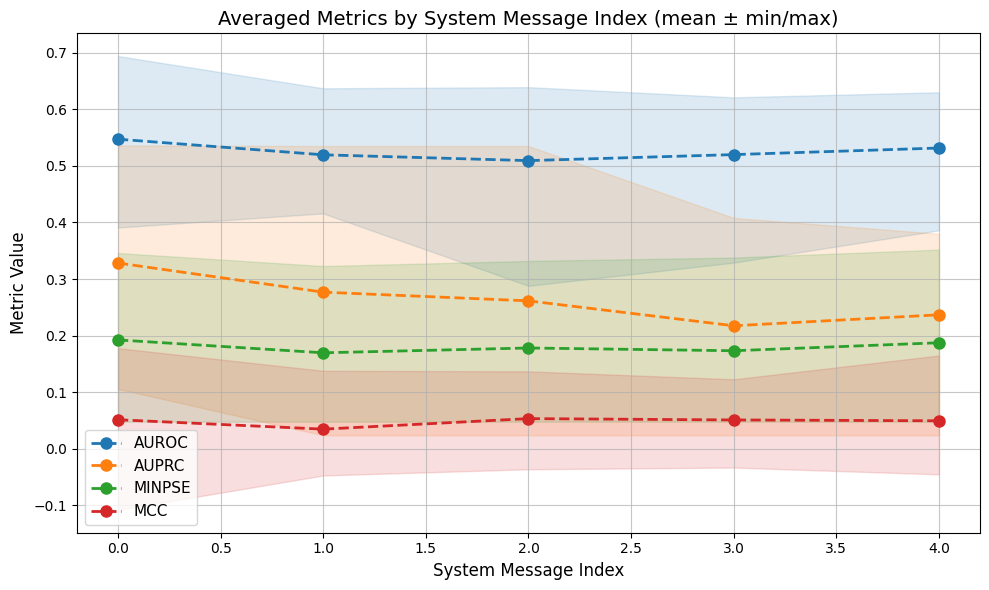

In [72]:
# Aggregated Performance Visualization
# Show averaged metrics across all combinations
if 'System Message Index' in df_metadata.columns and len(df_metrics_by_model_task) > 0:
    metrics_to_plot = ["auroc", "auprc", "minpse", "mcc"]
    # Use colorblind-friendly colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    plt.figure(figsize=(10, 6))

    for metric, color in zip(metrics_to_plot, colors):
        if metric in df_metrics_by_model_task.columns:
            # Group by System Message Index and aggregate
            grouped = df_metrics_by_model_task.groupby("System Message Index")[metric].agg(['mean', 'min', 'max'])
            x = grouped.index
            y_mean = grouped['mean']
            y_min = grouped['min']
            y_max = grouped['max']
            plt.plot(x, y_mean, marker="o", label=metric.upper(), color=color, linestyle='--', linewidth=2, markersize=8)
            plt.fill_between(x, y_min, y_max, alpha=0.15, color=color)

    plt.xlabel("System Message Index", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.title("Averaged Metrics by System Message Index (mean ± min/max)", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create aggregated performance plot - missing required data")

In [73]:
# Operational Timing and Token Usage Analysis
operational_cols = ["Tokenization Time", "Inference Time", "Input Tokens", "Output Tokens"]
available_operational_cols = [col for col in operational_cols if col in df_metadata.columns]

if available_operational_cols:
    print("\nOperational Metrics Summary:")
    print("Average metrics by model, task, and dataset:")
    
    grouping_cols = ["model_name", "task", "dataset"]
    available_grouping_cols = [col for col in grouping_cols if col in df_metadata.columns]
    
    if available_grouping_cols and available_operational_cols:
        operational_summary = df_metadata.groupby(available_grouping_cols).agg({
            col: "mean" for col in available_operational_cols
        }).reset_index().round(4)
        
        display(operational_summary.head(20))
    else:
        print("Missing required columns for operational analysis")
else:
    print("No operational metrics columns found in the data")


Operational Metrics Summary:
Average metrics by model, task, and dataset:


model_name       task dataset  Tokenization Time  Inference Time  \
0   DeepseekR1Llama8b        aki    eicu             0.0057         19.2432   
1   DeepseekR1Llama8b        aki   hirid             0.0057         20.0725   
2   DeepseekR1Llama8b  mortality    eicu             0.0126         46.9691   
3   DeepseekR1Llama8b  mortality   hirid             0.0120         46.5238   
4   DeepseekR1Llama8b  mortality    miiv             0.0118         52.9486   
5              Llama3        aki    eicu             0.0065          2.5838   
6              Llama3  mortality    eicu             0.0126          4.5129   
7              Llama3     sepsis    eicu             0.0066          4.4356   
8             Mistral        aki    eicu             0.0127          4.0689   
9             Mistral  mortality    eicu             0.0237          8.8057   
10            Mistral     sepsis    eicu             0.0129          3.9942   

    Input Tokens  Output Tokens  
0      3330.7799       804.9167  
1      3330.9758       836.0224  
2      7923.5800      1422.6540  
3      7927.2100      1433.6960  
4      7923.9100      1562.1980  
5      3360.7799        80.6837  
6      7953.5800       112.3680  
7      3393.7786       146.8667  
8      4322.7167       124.7850  
9     10627.7800       205.9060  
10     4352.0673       123.7267


OPERATIONAL PERFORMANCE ANALYSIS BY SYSTEM MESSAGE

Operational Metrics by System Message Index:


System Message Index  Tokenization Time_mean  Tokenization Time_std  \
0                     0                  0.0082                 0.0034   
1                     1                  0.0087                 0.0036   
2                     2                  0.0089                 0.0038   
3                     3                  0.0091                 0.0038   
4                     4                  0.0093                 0.0039   

   Tokenization Time_min  Tokenization Time_max  Tokenization Time_count  \
0                 0.0051                 0.0244                     6394   
1                 0.0053                 0.0260                     6394   
2                 0.0054                 0.0259                     6394   
3                 0.0055                 0.0254                     6394   
4                 0.0056                 0.0287                     6394   

   Inference Time_mean  Inference Time_std  Inference Time_min  \
0              11.6566             12.1225              2.2626   
1              10.7201             27.3591              1.9263   
2              10.3658             16.0011              1.9620   
3              10.8630             15.8871              1.9758   
4              10.6876             19.5741              2.0028   

   Inference Time_max  ...  Input Tokens_mean  Input Tokens_std  \
0             93.7106  ...          3825.8008         1388.8963   
1            939.8377  ...          4008.8843         1392.1002   
2            950.5908  ...          4100.9859         1395.0945   
3            943.2954  ...          4134.5683         1396.2006   
4            945.8200  ...          4210.9628         1398.4072   

   Input Tokens_min  Input Tokens_max  Input Tokens_count  Output Tokens_mean  \
0              3125             10497                6394            435.7365   
1              3285             10699                6394            386.9360   
2              3370             10806                6394            381.9970   
3              3401             10845                6394            402.0139   
4              3472             10933                6394            390.5460   

   Output Tokens_std  Output Tokens_min  Output Tokens_max  \
0           449.8296                 70               2874   
1           677.5580                 58              20000   
2           472.2448                 59              20000   
3           477.2881                 60              20000   
4           524.0465                 60              20000   

   Output Tokens_count  
0                 6394  
1                 6394  
2                 6394  
3                 6394  
4                 6394  

[5 rows x 21 columns]

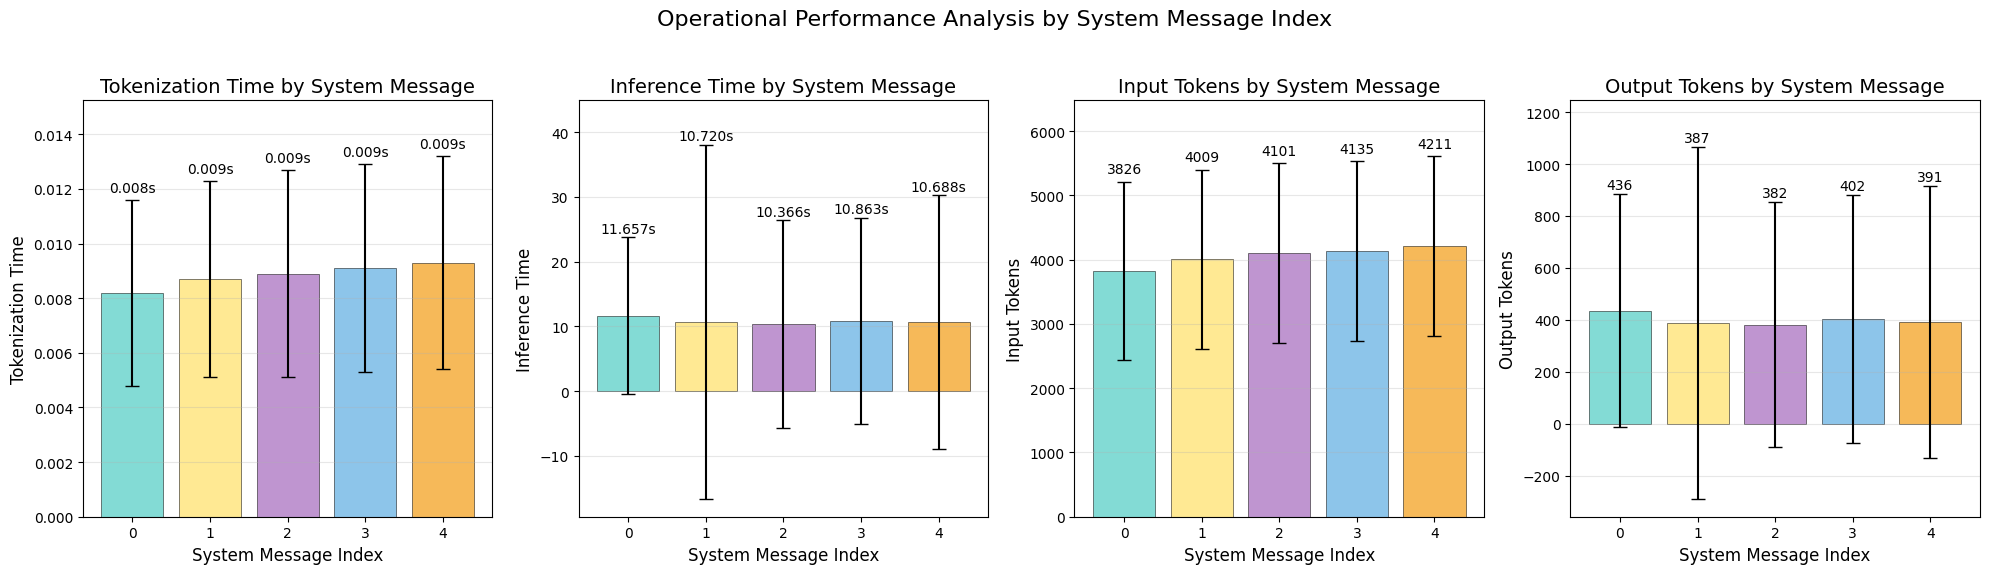


EFFICIENCY ANALYSIS

Efficiency Metrics by System Message:


System_Message_Index  Total_Processing_Time  Total_Tokens  \
0                     0                11.6649     4261.5372   
1                     1                10.7288     4395.8203   
2                     2                10.3747     4482.9830   
3                     3                10.8721     4536.5823   
4                     4                10.6968     4601.5088   

   Tokens_per_Second  Input_Output_Ratio  Sample_Count  
0           365.3313              8.7801          6394  
1           409.7230             10.3606          6394  
2           432.1060             10.7356          6394  
3           417.2685             10.2846          6394  
4           430.1746             10.7822          6394

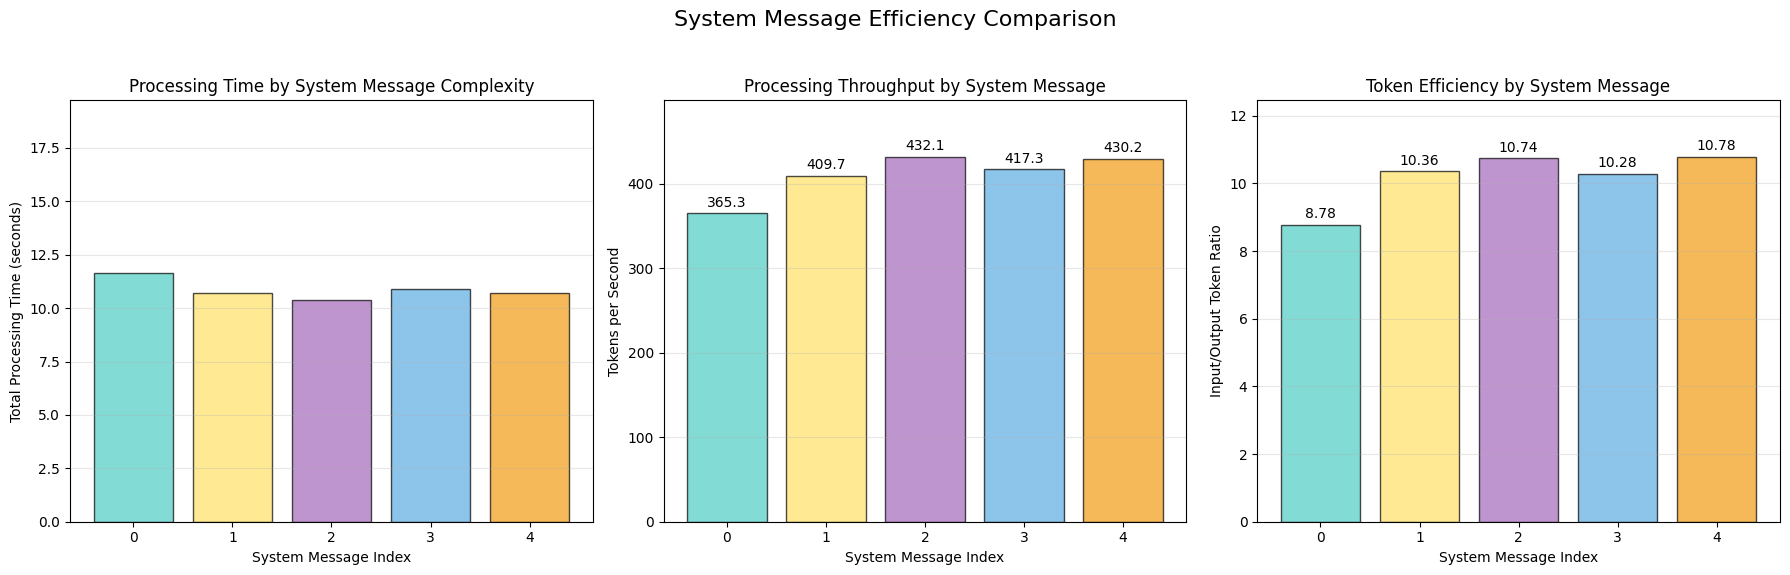


MODEL-SPECIFIC OPERATIONAL ANALYSIS


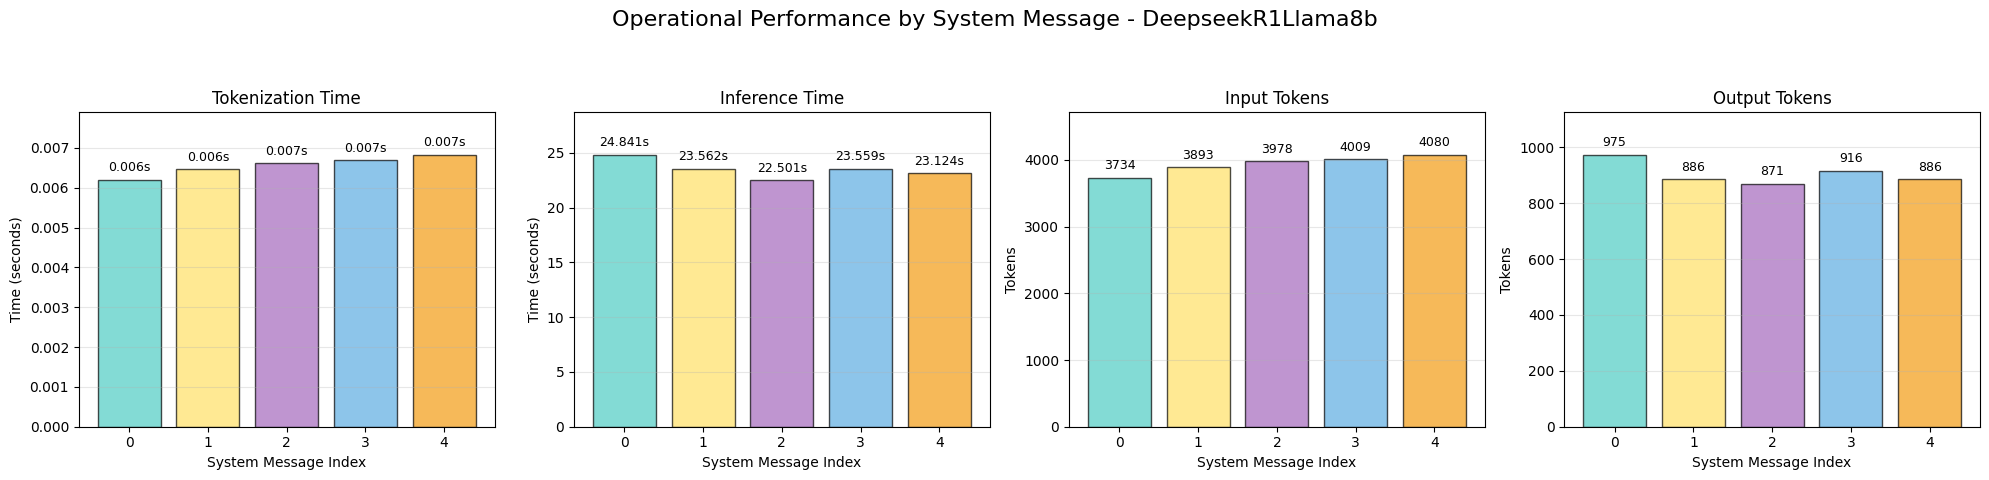

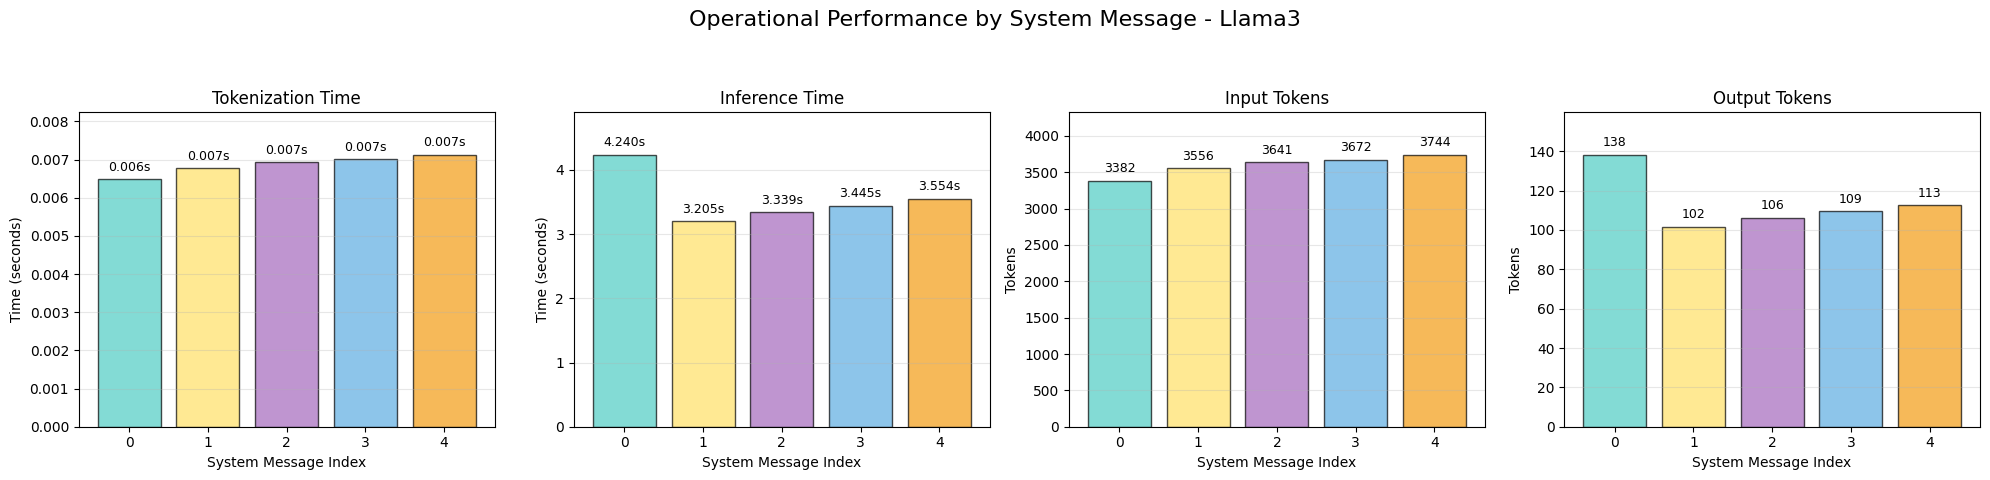

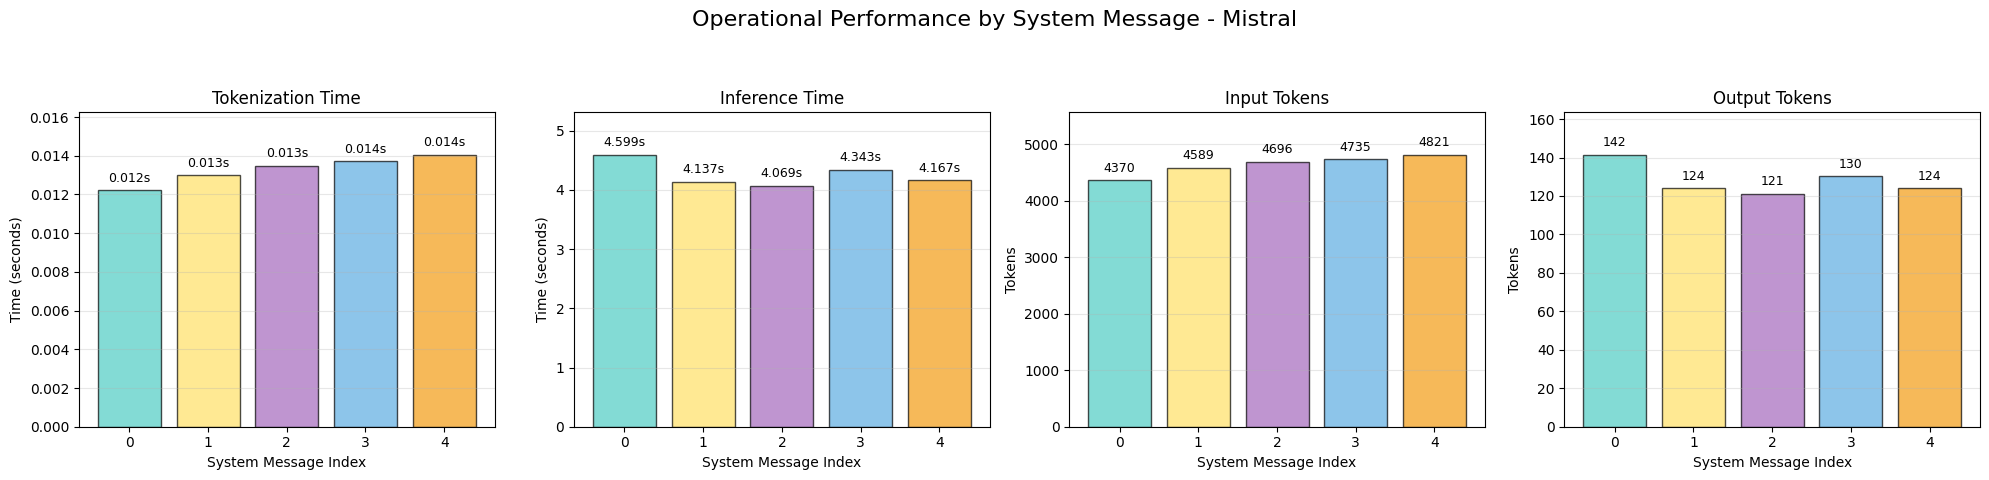


KEY OPERATIONAL INSIGHTS
✅ Most Efficient System Message: 2.0 (432.1 tokens/sec)
⚠️  Least Efficient System Message: 0.0 (365.3 tokens/sec)
📊 Efficiency Difference: 18.3% improvement from worst to best

💰 Token Usage:
   • Highest: System Message 4.0 (4602 tokens)
   • Lowest: System Message 0.0 (4262 tokens)
   • Token Overhead: 8.0% increase from simplest to most complex


In [74]:
# Comprehensive Operational Metrics Visualization by System Message
if available_operational_cols and 'System Message Index' in df_metadata.columns:
    print("\n" + "="*80)
    print("OPERATIONAL PERFORMANCE ANALYSIS BY SYSTEM MESSAGE")
    print("="*80)
    
    # Create output directory for operational plots
    output_dir_ops = os.path.join(OUTPUT_BASE_DIR, 'operational_analysis')
    os.makedirs(output_dir_ops, exist_ok=True)
    
    # Calculate operational metrics by system message index
    operational_by_sysmsg = df_metadata.groupby(['System Message Index']).agg({
        col: ['mean', 'std', 'min', 'max', 'count'] for col in available_operational_cols
    }).round(4)
    
    # Flatten column names
    operational_by_sysmsg.columns = ['_'.join(col).strip() for col in operational_by_sysmsg.columns]
    operational_by_sysmsg = operational_by_sysmsg.reset_index()
    
    print(f"\nOperational Metrics by System Message Index:")
    display(operational_by_sysmsg)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle('Operational Performance Analysis by System Message Index', fontsize=16)
    
    # Define colors for system messages
    sys_msg_colors = [SYSTEM_MESSAGE_COLORS.get(i, "#000000") for i in sorted(df_metadata['System Message Index'].unique())]
    
    metrics_to_plot = available_operational_cols
    axes_flat = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Get data for this metric
            sys_msg_indices = sorted(df_metadata['System Message Index'].unique())
            means = [operational_by_sysmsg[operational_by_sysmsg['System Message Index'] == idx][f'{metric}_mean'].values[0] 
                    for idx in sys_msg_indices]
            stds = [operational_by_sysmsg[operational_by_sysmsg['System Message Index'] == idx][f'{metric}_std'].values[0] 
                   for idx in sys_msg_indices]
            
            # Create bar plot with error bars
            bars = ax.bar(range(len(sys_msg_indices)), means, yerr=stds, 
                         color=sys_msg_colors[:len(sys_msg_indices)], alpha=0.7, 
                         capsize=5, edgecolor='black', linewidth=0.5)
            
            # Customize the plot
            ax.set_xlabel('System Message Index', fontsize=12)
            ax.set_ylabel(f'{metric}', fontsize=12)
            ax.set_title(f'{metric} by System Message', fontsize=14)
            ax.set_xticks(range(len(sys_msg_indices)))
            ax.set_xticklabels([f'{idx}' for idx in sys_msg_indices])
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for j, (bar, mean_val, std_val) in enumerate(zip(bars, means, stds)):
                height = bar.get_height()
                if metric in ['Tokenization Time', 'Inference Time']:
                    label = f'{mean_val:.3f}s'
                else:
                    label = f'{mean_val:.0f}'
                ax.text(bar.get_x() + bar.get_width()/2., height + std_val + max(means)*0.02,
                       label, ha='center', va='bottom', fontsize=10)
            
            # Add extra padding to y-axis to prevent label collision
            current_ylim = ax.get_ylim()
            ax.set_ylim(current_ylim[0], current_ylim[1] * 1.1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(output_dir_ops, 'operational_metrics_by_system_message.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate and display efficiency metrics
    print(f"\n{'='*60}")
    print("EFFICIENCY ANALYSIS")
    print(f"{'='*60}")
    
    efficiency_analysis = []
    for sys_msg_idx in sorted(df_metadata['System Message Index'].unique()):
        sys_msg_data = df_metadata[df_metadata['System Message Index'] == sys_msg_idx]
        
        # Calculate efficiency metrics
        if len(sys_msg_data) > 0:
            total_time = sys_msg_data['Tokenization Time'].mean() + sys_msg_data['Inference Time'].mean()
            total_tokens = sys_msg_data['Input Tokens'].mean() + sys_msg_data['Output Tokens'].mean()
            
            efficiency_metrics = {
                'System_Message_Index': sys_msg_idx,
                'Total_Processing_Time': total_time,
                'Total_Tokens': total_tokens,
                'Tokens_per_Second': total_tokens / total_time if total_time > 0 else 0,
                'Input_Output_Ratio': sys_msg_data['Input Tokens'].mean() / sys_msg_data['Output Tokens'].mean() 
                                    if sys_msg_data['Output Tokens'].mean() > 0 else 0,
                'Sample_Count': len(sys_msg_data)
            }
            efficiency_analysis.append(efficiency_metrics)
    
    efficiency_df = pd.DataFrame(efficiency_analysis)
    print("\nEfficiency Metrics by System Message:")
    display(efficiency_df.round(4))
    
    # Create efficiency comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('System Message Efficiency Comparison', fontsize=16)
    
    # Plot 1: Total Processing Time vs System Message Complexity
    ax1 = axes[0]
    sys_indices = efficiency_df['System_Message_Index'].values
    processing_times = efficiency_df['Total_Processing_Time'].values
    bars1 = ax1.bar(sys_indices, processing_times, 
                   color=[SYSTEM_MESSAGE_COLORS.get(idx, "#000000") for idx in sys_indices], 
                   alpha=0.7, edgecolor='black')
    ax1.set_xlabel('System Message Index')
    ax1.set_ylabel('Total Processing Time (seconds)')
    ax1.set_title('Processing Time by System Message Complexity')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, time_val in zip(bars1, processing_times):
        # Add extra padding to y-axis to prevent label collision
        current_ylim = ax1.get_ylim()
        ax1.set_ylim(current_ylim[0], current_ylim[1] * 1.1)
    
    # Plot 2: Tokens per Second
    ax2 = axes[1]
    tokens_per_sec = efficiency_df['Tokens_per_Second'].values
    bars2 = ax2.bar(sys_indices, tokens_per_sec,
                   color=[SYSTEM_MESSAGE_COLORS.get(idx, "#000000") for idx in sys_indices], 
                   alpha=0.7, edgecolor='black')
    ax2.set_xlabel('System Message Index')
    ax2.set_ylabel('Tokens per Second')
    ax2.set_title('Processing Throughput by System Message')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, tps_val in zip(bars2, tokens_per_sec):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(tokens_per_sec)*0.01,
                f'{tps_val:.1f}', ha='center', va='bottom', fontsize=10)
        
    # Add extra padding to y-axis to prevent label collision
    current_ylim = ax2.get_ylim()
    ax2.set_ylim(current_ylim[0], current_ylim[1] * 1.1)
    
    # Plot 3: Input/Output Token Ratio
    ax3 = axes[2]
    io_ratios = efficiency_df['Input_Output_Ratio'].values
    bars3 = ax3.bar(sys_indices, io_ratios,
                   color=[SYSTEM_MESSAGE_COLORS.get(idx, "#000000") for idx in sys_indices], 
                   alpha=0.7, edgecolor='black')
    ax3.set_xlabel('System Message Index')
    ax3.set_ylabel('Input/Output Token Ratio')
    ax3.set_title('Token Efficiency by System Message')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, ratio_val in zip(bars3, io_ratios):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(io_ratios)*0.01,
                f'{ratio_val:.2f}', ha='center', va='bottom', fontsize=10)
        
    # Add extra padding to y-axis to prevent label collision
    current_ylim = ax3.get_ylim()
    ax3.set_ylim(current_ylim[0], current_ylim[1] * 1.1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(output_dir_ops, 'system_message_efficiency_comparison.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Model-specific operational analysis
    if 'model_name' in df_metadata.columns:
        print(f"\n{'='*60}")
        print("MODEL-SPECIFIC OPERATIONAL ANALYSIS")
        print(f"{'='*60}")
        
        models = [m for m in df_metadata['model_name'].unique() if m != "Unknown"]
        
        # Create model comparison visualization with 4 metrics per model in one row
        for i, model in enumerate(models):
            model_data = df_metadata[df_metadata['model_name'] == model]
            
            # Calculate operational metrics by system message for this model
            model_ops = model_data.groupby('System Message Index')[available_operational_cols].mean()
            
            if len(model_ops) > 0:
                # Create subplot for this model with all 4 metrics in one row
                fig, axes = plt.subplots(1, 4, figsize=(20, 5))
                fig.suptitle(f'Operational Performance by System Message - {model}', fontsize=16)
                
                sys_indices = model_ops.index
                colors_model = [SYSTEM_MESSAGE_COLORS.get(idx, "#000000") for idx in sys_indices]
                
                # Plot each operational metric
                for j, metric in enumerate(available_operational_cols):
                    ax = axes[j]
                    values = model_ops[metric].values
                    
                    bars = ax.bar(sys_indices, values, color=colors_model, alpha=0.7, edgecolor='black')
                    ax.set_title(f'{metric}', fontsize=12)
                    ax.set_xlabel('System Message Index')
                    
                    if metric in ['Tokenization Time', 'Inference Time']:
                        ax.set_ylabel('Time (seconds)')
                        label_format = '{:.3f}s'
                    else:
                        ax.set_ylabel('Tokens')
                        label_format = '{:.0f}'
                    
                    ax.grid(axis='y', alpha=0.3)
                    
                    # Add value labels
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                                label_format.format(val), ha='center', va='bottom', fontsize=9)
                    
                    # Add extra padding to y-axis to prevent label collision
                    current_ylim = ax.get_ylim()
                    ax.set_ylim(current_ylim[0], current_ylim[1] * 1.1)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.92])
                plt.savefig(os.path.join(output_dir_ops, f'{model}_operational_analysis.png'), 
                            dpi=300, bbox_inches='tight')
                plt.show()
        
        # Print summary insights
        print(f"\n{'='*60}")
        print("KEY OPERATIONAL INSIGHTS")
        print(f"{'='*60}")
        
        # Find most and least efficient system messages
        most_efficient = efficiency_df.loc[efficiency_df['Tokens_per_Second'].idxmax()]
        least_efficient = efficiency_df.loc[efficiency_df['Tokens_per_Second'].idxmin()]
        
        print(f"✅ Most Efficient System Message: {most_efficient['System_Message_Index']} "
              f"({most_efficient['Tokens_per_Second']:.1f} tokens/sec)")
        print(f"⚠️  Least Efficient System Message: {least_efficient['System_Message_Index']} "
              f"({least_efficient['Tokens_per_Second']:.1f} tokens/sec)")
        
        efficiency_gain = ((most_efficient['Tokens_per_Second'] - least_efficient['Tokens_per_Second']) / 
                          least_efficient['Tokens_per_Second'] * 100)
        print(f"📊 Efficiency Difference: {efficiency_gain:.1f}% improvement from worst to best")
        
        # Token usage analysis
        max_tokens = efficiency_df.loc[efficiency_df['Total_Tokens'].idxmax()]
        min_tokens = efficiency_df.loc[efficiency_df['Total_Tokens'].idxmin()]
        
        print(f"\n💰 Token Usage:")
        print(f"   • Highest: System Message {max_tokens['System_Message_Index']} "
              f"({max_tokens['Total_Tokens']:.0f} tokens)")
        print(f"   • Lowest: System Message {min_tokens['System_Message_Index']} "
              f"({min_tokens['Total_Tokens']:.0f} tokens)")
        
        token_overhead = ((max_tokens['Total_Tokens'] - min_tokens['Total_Tokens']) / 
                         min_tokens['Total_Tokens'] * 100)
        print(f"   • Token Overhead: {token_overhead:.1f}% increase from simplest to most complex")

else:
    print("Cannot perform operational analysis - missing required columns or System Message Index")

---

# Model-Specific Deep Dive Analysis

Detailed analysis for individual models to understand system message performance patterns.

Available models for analysis: ['DeepseekR1Llama8b' 'Llama3' 'Mistral']

ANALYSIS FOR MODEL: DeepseekR1Llama8b

Summary:
- System message 1 with best performance
- A lot of inconsistent probability/label pairs

Total records for DeepseekR1Llama8b: 11330
Tasks: ['mortality' 'aki']
Datasets: ['miiv' 'hirid' 'eicu']
System Message Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Probability-Diagnosis Inconsistency Analysis for DeepseekR1Llama8b:
System Message 0: 25/2266 predictions (0.011) are inconsistent with the probability.
System Message 1: 68/2266 predictions (0.030) are inconsistent with the probability.
System Message 2: 25/2266 predictions (0.011) are inconsistent with the probability.
System Message 3: 37/2266 predictions (0.016) are inconsistent with the probability.
System Message 4: 43/2266 predictions (0.019) are inconsistent with the probability.

Overall Performance by System Message for DeepseekR1Llama8b:


/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_4153/1498062063.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


System Message Index  auroc  auprc  normalized_auprc  specificity  \
0                     0  0.543  0.263             1.206        0.748   
1                     1  0.565  0.285             1.308        0.774   
2                     2  0.546  0.250             1.146        0.790   
3                     3  0.555  0.260             1.194        0.784   
4                     4  0.573  0.283             1.300        0.799   

   f1_score  accuracy  balanced_accuracy  precision  recall    mcc  kappa  \
0     0.291     0.655              0.536      0.264   0.324  0.067  0.066   
1     0.300     0.675              0.547      0.283   0.320  0.090  0.089   
2     0.297     0.684              0.548      0.289   0.306  0.094  0.094   
3     0.290     0.679              0.543      0.280   0.302  0.083  0.083   
4     0.302     0.692              0.552      0.298   0.306  0.104  0.104   

   minpse  
0   0.266  
1   0.295  
2   0.293  
3   0.284  
4   0.300


Detailed Performance Analysis for DeepseekR1Llama8b:
  Processing DeepseekR1Llama8b - AKI - HiRID
  Processing DeepseekR1Llama8b - AKI - eICU
  Processing DeepseekR1Llama8b - AKI - eICU
  Processing DeepseekR1Llama8b - Mortality - HiRID
  Processing DeepseekR1Llama8b - Mortality - HiRID
  Processing DeepseekR1Llama8b - Mortality - MIMIC-IV
  Processing DeepseekR1Llama8b - Mortality - MIMIC-IV
  Processing DeepseekR1Llama8b - Mortality - eICU
  Processing DeepseekR1Llama8b - Mortality - eICU


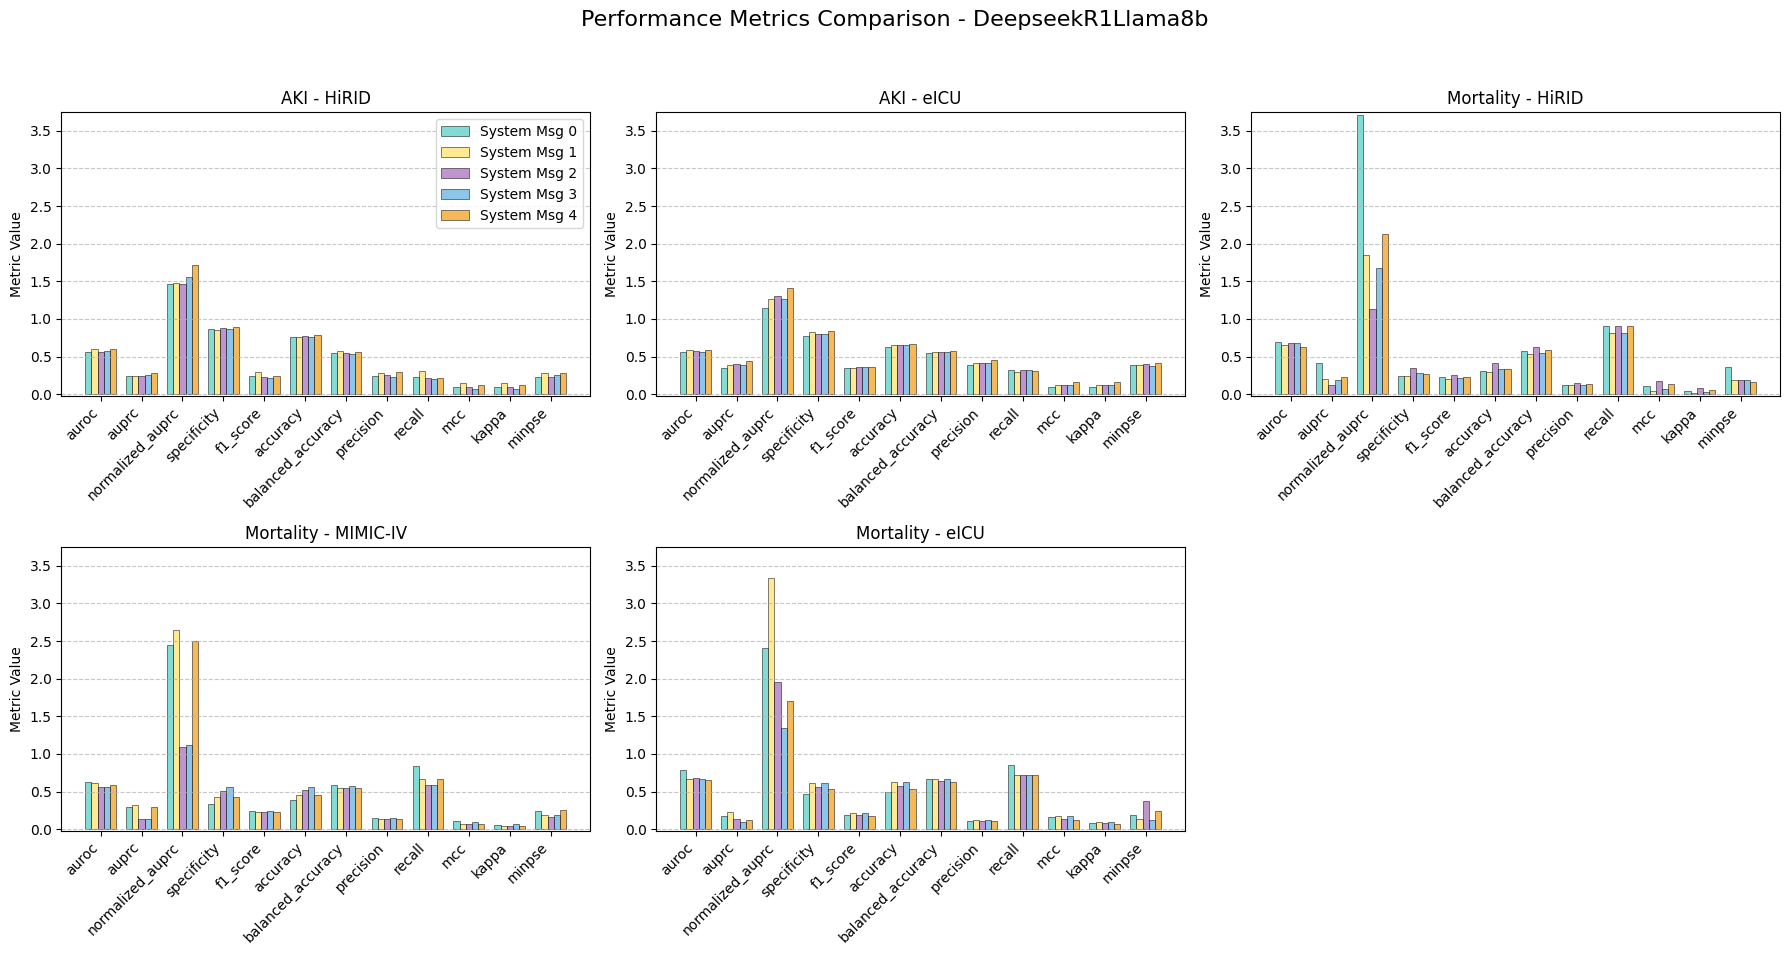


ANALYSIS FOR MODEL: Llama3

Summary:
- System message 0 has best performance
- System Message 0 does not reply with correct label
- Probability and label consistent for all samples

Total records for Llama3: 10320
Tasks: ['sepsis' 'aki' 'mortality']
Datasets: ['eicu']
System Message Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Probability-Diagnosis Inconsistency Analysis for Llama3:
System Message 0: 0/2064 predictions (0.000) are inconsistent with the probability.
System Message 1: 0/2064 predictions (0.000) are inconsistent with the probability.
System Message 2: 0/2064 predictions (0.000) are inconsistent with the probability.
System Message 3: 0/2064 predictions (0.000) are inconsistent with the probability.
System Message 4: 0/2064 predictions (0.000) are inconsistent with the probability.

Overall Performance by System Message for Llama3:


/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_4153/1498062063.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


System Message Index  auroc  auprc  normalized_auprc  specificity  \
0                     0  0.510  0.396             2.275        0.319   
1                     1  0.367  0.142             0.815        0.565   
2                     2  0.308  0.149             0.859        0.608   
3                     3  0.324  0.166             0.952        0.523   
4                     4  0.369  0.179             1.029        0.365   

   f1_score  accuracy  balanced_accuracy  precision  recall    mcc  kappa  \
0     0.247     0.367              0.458      0.156   0.596 -0.068 -0.040   
1     0.098     0.494              0.362      0.071   0.159 -0.215 -0.186   
2     0.102     0.529              0.380      0.076   0.153 -0.190 -0.171   
3     0.122     0.469              0.367      0.085   0.212 -0.203 -0.168   
4     0.170     0.366              0.369      0.110   0.373 -0.202 -0.135   

   minpse  
0   0.207  
1   0.174  
2   0.174  
3   0.174  
4   0.174


Detailed Performance Analysis for Llama3:
  Processing Llama3 - AKI - eICU
  Processing Llama3 - Mortality - eICU
  Processing Llama3 - Mortality - eICU
  Processing Llama3 - Sepsis - eICU
  Processing Llama3 - Sepsis - eICU


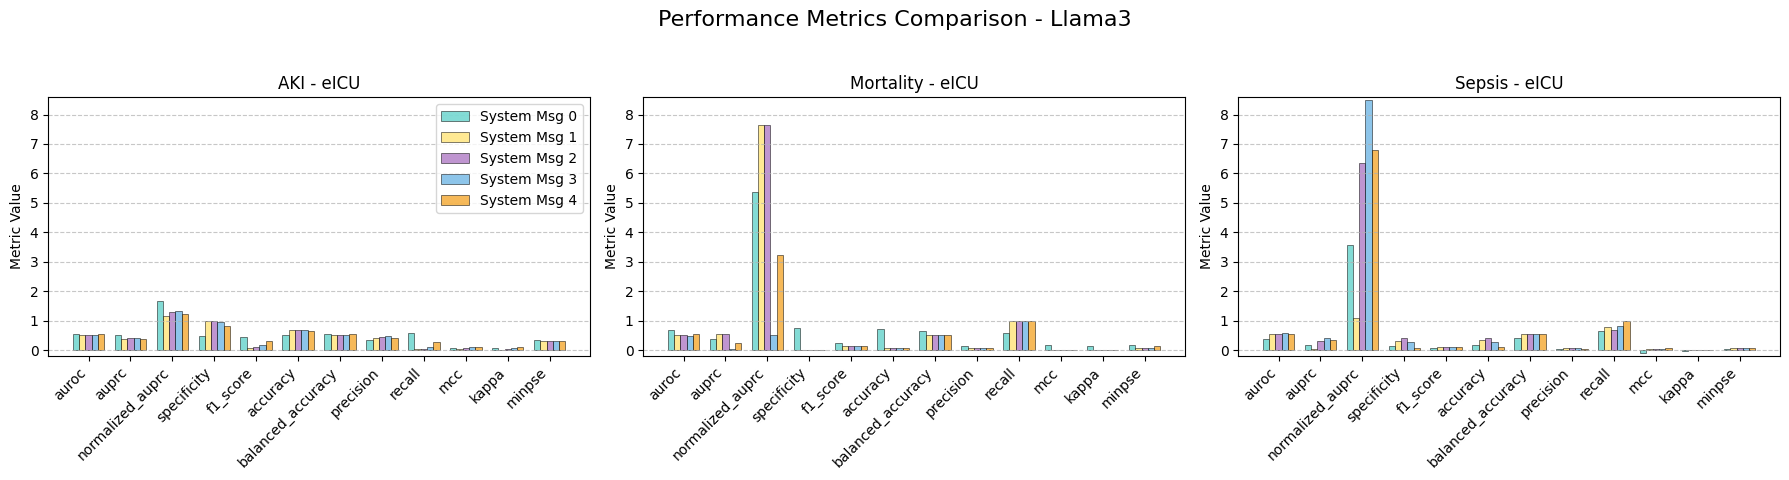


ANALYSIS FOR MODEL: Mistral

Summary:
- System Message 0 response not using correct label
- System Message 1 has best performance

Total records for Mistral: 10320
Tasks: ['aki' 'mortality' 'sepsis']
Datasets: ['eicu']
System Message Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Probability-Diagnosis Inconsistency Analysis for Mistral:
System Message 0: 100/2064 predictions (0.048) are inconsistent with the probability.
System Message 1: 995/2064 predictions (0.482) are inconsistent with the probability.
System Message 2: 108/2064 predictions (0.052) are inconsistent with the probability.
System Message 3: 112/2064 predictions (0.054) are inconsistent with the probability.
System Message 4: 335/2064 predictions (0.162) are inconsistent with the probability.

Overall Performance by System Message for Mistral:


/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_4153/1498062063.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


System Message Index  auroc  auprc  normalized_auprc  specificity  \
0                     0  0.481  0.163             0.940        0.787   
1                     1  0.705  0.443             2.548        0.523   
2                     2  0.369  0.150             0.864        0.875   
3                     3  0.369  0.152             0.877        0.884   
4                     4  0.500  0.237             1.365        0.714   

   f1_score  accuracy  balanced_accuracy  precision  recall    mcc  kappa  \
0     0.174     0.683              0.489      0.159   0.192 -0.020 -0.020   
1     0.420     0.583              0.696      0.277   0.869  0.299  0.213   
2     0.215     0.756              0.534      0.245   0.192  0.074  0.073   
3     0.192     0.759              0.524      0.230   0.164  0.056  0.055   
4     0.338     0.673              0.597      0.261   0.479  0.157  0.145   

   minpse  
0   0.174  
1   0.304  
2   0.192  
3   0.174  
4   0.261


Detailed Performance Analysis for Mistral:
  Processing Mistral - AKI - eICU
  Processing Mistral - Mortality - eICU
  Processing Mistral - Mortality - eICU
  Processing Mistral - Sepsis - eICU
  Processing Mistral - Sepsis - eICU


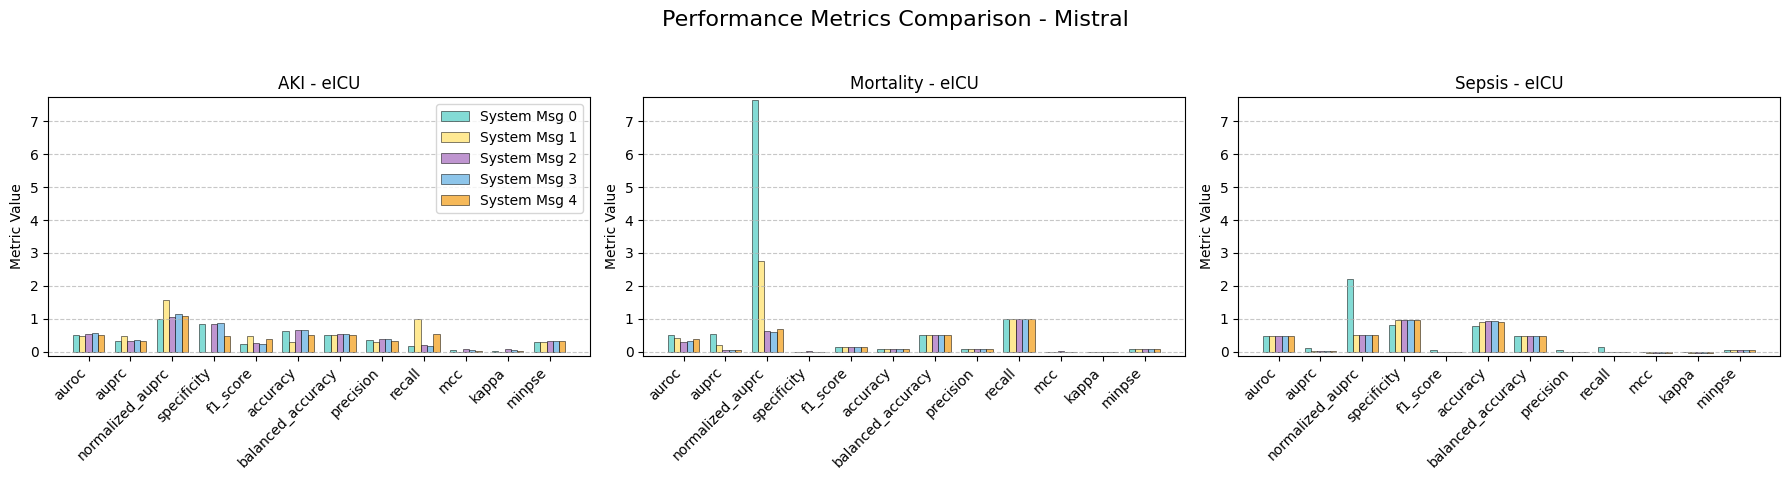

In [75]:
# Model-Specific Analysis
# Get unique models from the data
if 'model_name' in df_metadata.columns:
    unique_models = df_metadata['model_name'].unique()
    print(f"Available models for analysis: {unique_models}")
    
    # Model-specific findings summaries
    model_summaries = {
        "Mistral": [
            "System Message 0 response not using correct label",
            "System Message 1 has best performance"
        ],
        "Llama3": [
            "System message 0 has best performance", 
            "System Message 0 does not reply with correct label",
            "Probability and label consistent for all samples"
        ],
        "Gemma3": [
            "System Message 1 was not sufficient for the model to understand how to phrase the output",
            "Long inference time of ca. 40sec",
            "System Message 2 with the best performance",
            "Many misclassified samples (probabilities and label not matching)"
        ],
        "DeepseekR1Llama8b": [
            "System message 1 with best performance",
            "A lot of inconsistent probability/label pairs"
        ]
    }
    
    # Analyze each model separately
    for model in unique_models:
        if model != "Unknown":
            print(f"\n{'='*60}")
            print(f"ANALYSIS FOR MODEL: {model}")
            print(f"{'='*60}")
            
            # Display model-specific summary if available
            if model in model_summaries:
                print(f"\nSummary:")
                for point in model_summaries[model]:
                    print(f"- {point}")
                print()
            
            # Filter data for this model
            model_data = get_predictions_by_model(df_metadata, model)
            
            if len(model_data) > 0:
                print(f"Total records for {model}: {len(model_data)}")
                
                # Show unique tasks and datasets for this model
                print(f"Tasks: {model_data['task'].unique()}")
                print(f"Datasets: {model_data['dataset'].unique()}")
                if 'System Message Index' in model_data.columns:
                    print(f"System Message Indices: {sorted(model_data['System Message Index'].unique())}")
                
                # Analyze probability-diagnosis inconsistency
                print(f"\nProbability-Diagnosis Inconsistency Analysis for {model}:")
                inconsistency_results = analyze_probability_diagnosis_inconsistency(model_data)
                
                # Calculate overall metrics by system message index for this model
                if 'System Message Index' in model_data.columns:
                    print(f"\nOverall Performance by System Message for {model}:")
                    model_grouped = (
                        model_data.groupby("System Message Index")
                        .apply(
                            lambda x: calculate_all_metrics(
                                x["Target Label"].values, x["Predicted Probability"].values
                            ) if len(x) > 0 else {}
                        )
                        .reset_index()
                    )
                    
                    if len(model_grouped) > 0 and 0 in model_grouped.columns:
                        metrics_df = model_grouped[0].apply(pd.Series)
                        model_grouped = pd.concat(
                            [model_grouped.drop(columns=0), metrics_df], axis=1
                        )
                        display(model_grouped)
                        
                        # Create bar chart for this model's performance
                        if len(model_data) > 100:  # Only create charts if we have sufficient data
                            print(f"\nDetailed Performance Analysis for {model}:")
                            
                            # Create output directory for individual bar charts
                            output_dir_bar = os.path.join(OUTPUT_BASE_DIR, 'metrics_bar_charts')
                            os.makedirs(output_dir_bar, exist_ok=True)
                            
                            # Store data for combined plot
                            bar_chart_data = []
                            
                            # Analyze by task-dataset combinations and save individual charts
                            task_dataset_combos = model_data.groupby(["Task", "Dataset"])
                            for (task, dataset), group in task_dataset_combos:
                                if len(group) > 50:  # Minimum data threshold
                                    print(f"  Processing {model} - {task} - {dataset}")
                                    
                                    save_filename = f"{model}_{task}_{dataset}_metrics_bar_chart.png"
                                    save_path = os.path.join(output_dir_bar, save_filename)
                                    
                                    # Create and save individual chart (but don't display)
                                    fig = plot_metrics_bar_chart(group, model, task, dataset, save_path)
                                    
                                    # Store data for combined plot
                                    bar_chart_data.append({
                                        'task': task,
                                        'dataset': dataset,
                                        'group': group,
                                        'title': f"{model} - {task} - {dataset}"
                                    })
                            
                            # Create and display combined figure if we have multiple charts
                            if len(bar_chart_data) > 1:
                                
                                # Calculate grid dimensions
                                n_charts = len(bar_chart_data)
                                n_cols = min(3, n_charts)  # Max 3 columns
                                n_rows = math.ceil(n_charts / n_cols)
                                
                                fig_combined, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
                                fig_combined.suptitle(f'Performance Metrics Comparison - {model}', fontsize=16, y=0.98)
                                
                                # Make axes iterable if single subplot
                                if n_charts == 1:
                                    axes = [axes]
                                elif n_rows == 1:
                                    axes = axes.reshape(1, -1)
                                elif n_cols == 1:
                                    axes = axes.reshape(-1, 1)
                                
                                # Flatten axes for easier iteration
                                axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
                                
                                # First pass: calculate all metrics and find global min/max for consistent y-axis
                                all_metrics_data = []
                                all_values = []
                                
                                for chart_idx, chart_data in enumerate(bar_chart_data):
                                    group = chart_data['group']
                                    
                                    # Calculate metrics for this combination
                                    metrics_by_sys_msg_idx = {}
                                    for idx in group["System Message Index"].unique():
                                        subset = group[group["System Message Index"] == idx]
                                        y_true = subset['Target Label'].values
                                        y_pred = subset['Predicted Probability'].values
                                        metrics = calculate_all_metrics(y_true, y_pred)
                                        metrics_by_sys_msg_idx[idx] = metrics
                                    
                                    all_metrics_data.append(metrics_by_sys_msg_idx)
                                    
                                    # Collect all values for y-axis range calculation
                                    for idx_metrics in metrics_by_sys_msg_idx.values():
                                        all_values.extend(idx_metrics.values())
                                
                                # Calculate global y-axis range with some padding
                                if all_values:
                                    y_min = min(all_values)
                                    y_max = max(all_values)
                                    y_range = y_max - y_min
                                    y_padding = y_range * 0.01 if y_range > 0 else 0.01  # 1% padding
                                    
                                    # Set appropriate bounds based on metric types
                                    global_y_min = max(-1, y_min - y_padding)  # Allow negative for MCC/Kappa
                                    
                                    # Don't artificially limit y_max - let it be determined by actual data
                                    if y_max <= 1.0 and y_min >= 0:
                                        # Standard 0-1 metrics, but allow some padding above 1 if needed
                                        global_y_max = min(1.2, y_max + y_padding)
                                    else:
                                        # Metrics that can exceed 1 (like Normalized AUPRC) or go negative
                                        global_y_max = y_max + y_padding
                                        
                                    # Ensure minimum range for visibility
                                    if global_y_max - global_y_min < 0.1:
                                        center = (global_y_max + global_y_min) / 2
                                        global_y_min = center - 0.05
                                        global_y_max = center + 0.05
                                else:
                                    global_y_min, global_y_max = 0, 1
                                
                                # Second pass: create plots with consistent y-axis
                                for chart_idx, chart_data in enumerate(bar_chart_data):
                                    if chart_idx < len(axes_flat):
                                        ax = axes_flat[chart_idx]
                                        task = chart_data['task']
                                        dataset = chart_data['dataset']
                                        
                                        # Get pre-calculated metrics
                                        metrics_by_sys_msg_idx = all_metrics_data[chart_idx]
                                        
                                        # Prepare data for plotting
                                        indices = list(metrics_by_sys_msg_idx.keys())
                                        metrics_names = list(next(iter(metrics_by_sys_msg_idx.values())).keys())
                                        
                                        # Create grouped bar plot
                                        bar_width = 0.15
                                        x = np.arange(len(metrics_names))
                                        colors = SYSTEM_MESSAGE_COLOR_LIST
                                        
                                        for i, idx in enumerate(indices):
                                            values = [metrics_by_sys_msg_idx[idx][metric] for metric in metrics_names]
                                            color = colors[i % len(colors)]
                                            ax.bar(x + i * bar_width, values, width=bar_width, 
                                                  label=f'System Msg {idx}', color=color, alpha=0.7, 
                                                  edgecolor='black', linewidth=0.5)
                                        
                                        ax.set_xticks(x + bar_width * (len(indices) - 1) / 2)
                                        ax.set_xticklabels(metrics_names, rotation=45, ha='right')
                                        ax.set_ylabel('Metric Value')
                                        ax.set_title(f'{task} - {dataset}', fontsize=12)
                                        ax.grid(axis='y', linestyle='--', alpha=0.7)
                                        
                                        # Set consistent y-axis range for all subplots
                                        ax.set_ylim(global_y_min, global_y_max)
                                        
                                        # Only add legend to first subplot
                                        if chart_idx == 0:
                                            ax.legend()
                                
                                # Hide unused subplots
                                for i in range(len(bar_chart_data), len(axes_flat)):
                                    axes_flat[i].axis('off')
                                
                                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                                
                                # Save combined figure
                                combined_save_path = os.path.join(output_dir_bar, f"{model}_combined_metrics_bar_charts.png")
                                plt.savefig(combined_save_path, dpi=300, bbox_inches='tight')
                                
                                # Display the combined figure in the notebook
                                plt.show()
                            
                            elif len(bar_chart_data) == 1:
                                # For single chart, still create a standalone display version
                                chart_data = bar_chart_data[0]
                                
                                # Recreate the plot for display
                                fig_display, ax_display = plt.subplots(figsize=(12, 6))
                                group = chart_data['group']
                                
                                # Calculate metrics
                                metrics_by_sys_msg_idx = {}
                                for idx in group["System Message Index"].unique():
                                    subset = group[group["System Message Index"] == idx]
                                    y_true = subset['Target Label'].values
                                    y_pred = subset['Predicted Probability'].values
                                    metrics = calculate_all_metrics(y_true, y_pred)
                                    metrics_by_sys_msg_idx[idx] = metrics
                                
                                # Plot
                                indices = list(metrics_by_sys_msg_idx.keys())
                                metrics_names = list(next(iter(metrics_by_sys_msg_idx.values())).keys())
                                bar_width = 0.15
                                x = np.arange(len(metrics_names))
                                colors = SYSTEM_MESSAGE_COLOR_LIST
                                
                                for i, idx in enumerate(indices):
                                    values = [metrics_by_sys_msg_idx[idx][metric] for metric in metrics_names]
                                    color = colors[i % len(colors)]
                                    ax_display.bar(x + i * bar_width, values, width=bar_width, 
                                                  label=f'System Msg {idx}', color=color, alpha=0.7, 
                                                  edgecolor='black', linewidth=0.5)
                                
                                ax_display.set_xticks(x + bar_width * (len(indices) - 1) / 2)
                                ax_display.set_xticklabels(metrics_names, rotation=45, ha='right')
                                ax_display.set_ylabel('Metric Value')
                                ax_display.set_title(f'Performance Metrics Comparison - {chart_data["title"]}')
                                ax_display.grid(axis='y', linestyle='--', alpha=0.7)
                                ax_display.legend()
                                
                                plt.tight_layout()
                                
                                # Save single chart
                                single_save_path = os.path.join(output_dir_bar, f"{model}_single_metrics_bar_chart.png")
                                plt.savefig(single_save_path, dpi=300, bbox_inches='tight')
                                
                                plt.show()
                            
                            else:
                                print(f"  ⚠️ No charts created for {model} - insufficient data")
            else:
                print(f"No data found for model: {model}")
else:
    print("No model_name column found in the data")

---

# Prediction Distribution Analysis

Analysis of prediction probability distributions to understand model calibration and prediction patterns.

Prediction Distribution Analysis by System Message Index:

Analyzing prediction distributions for all System Message Indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Model: DeepseekR1Llama8b

Distribution for AKI-HiRID (n=4910):
  System Message 0:
    Records: 982
    Positive samples: 159
    Negative samples: 823
    Positive rate (actual): 0.162
    Mean predicted probability: 0.152
    Std predicted probability: 0.303
    Calibration error (|pred_mean - pos_rate|): 0.009
    AUPRC: 0.237
  System Message 1:
    Records: 982
    Positive samples: 159
    Negative samples: 823
    Positive rate (actual): 0.162
    Mean predicted probability: 0.224
    Std predicted probability: 0.261
    Calibration error (|pred_mean - pos_rate|): 0.062
    AUPRC: 0.238
  System Message 2:
    Records: 982
    Positive samples: 159
    Negative samples: 823
    Positive rate (actual): 0.162
    Mean predicted probability: 0.243
    Std predicted probability: 0.222
    Cali

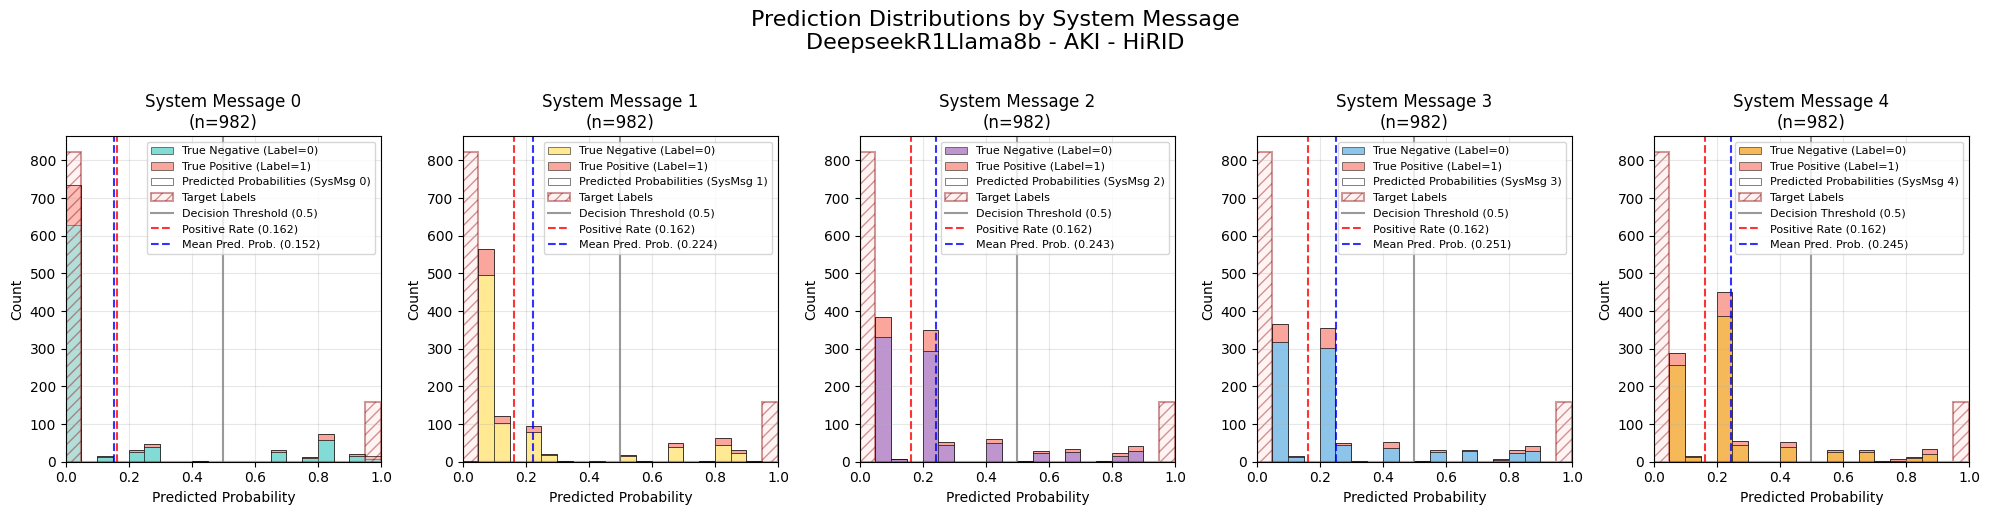

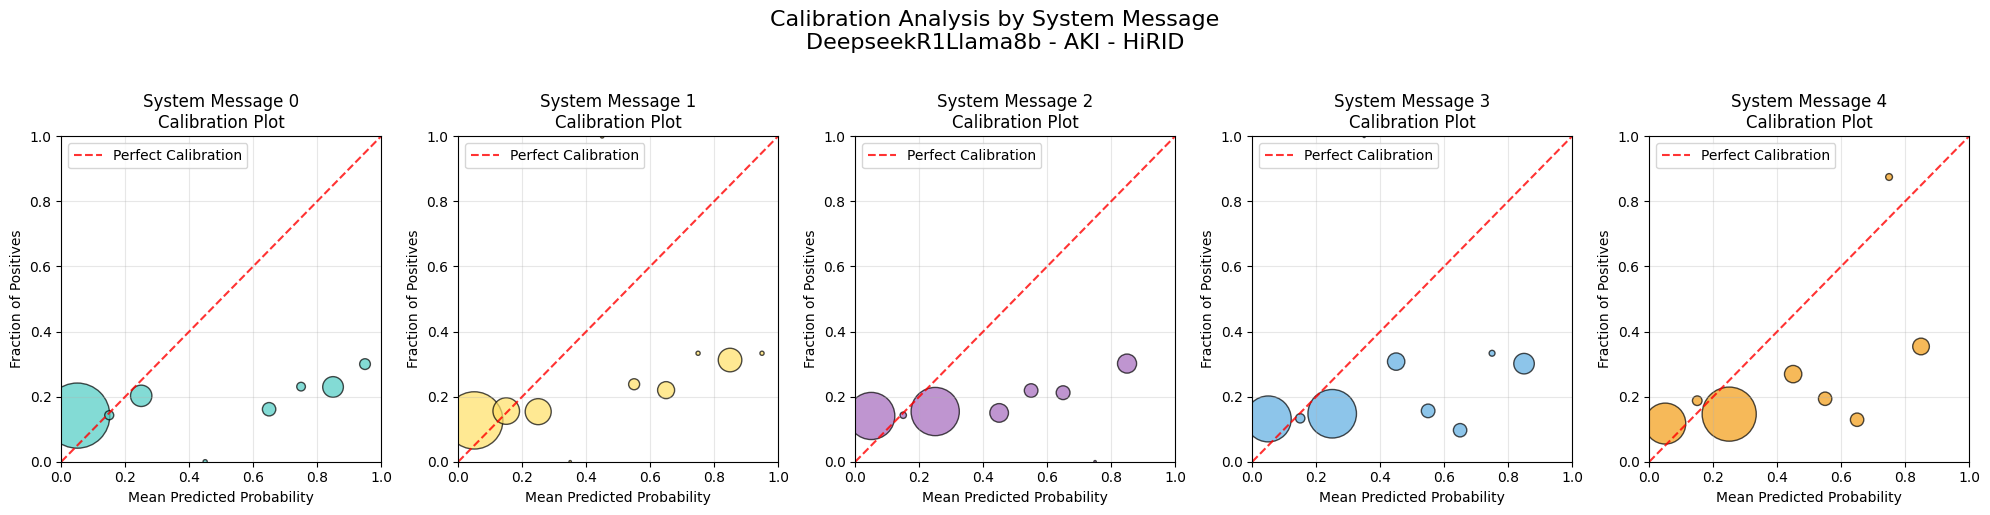


Distribution for AKI-eICU (n=4920):
  System Message 0:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.232
    Std predicted probability: 0.358
    Calibration error (|pred_mean - pos_rate|): 0.078
    AUPRC: 0.353
  System Message 1:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.261
    Std predicted probability: 0.295
    Calibration error (|pred_mean - pos_rate|): 0.049
    AUPRC: 0.392
  System Message 2:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.299
    Std predicted probability: 0.283
    Calibration error (|pred_mean - pos_rate|): 0.011
    AUPRC: 0.403
  System Message 3:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0

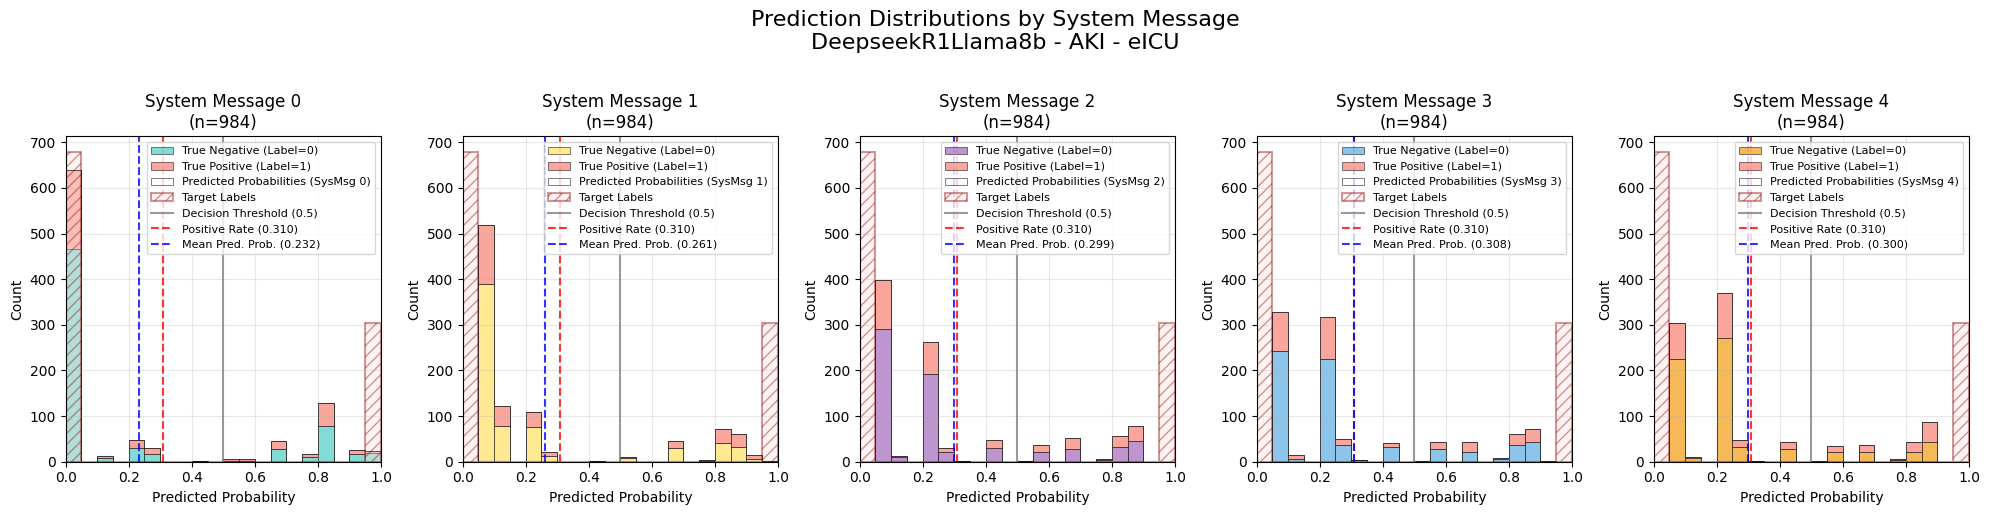

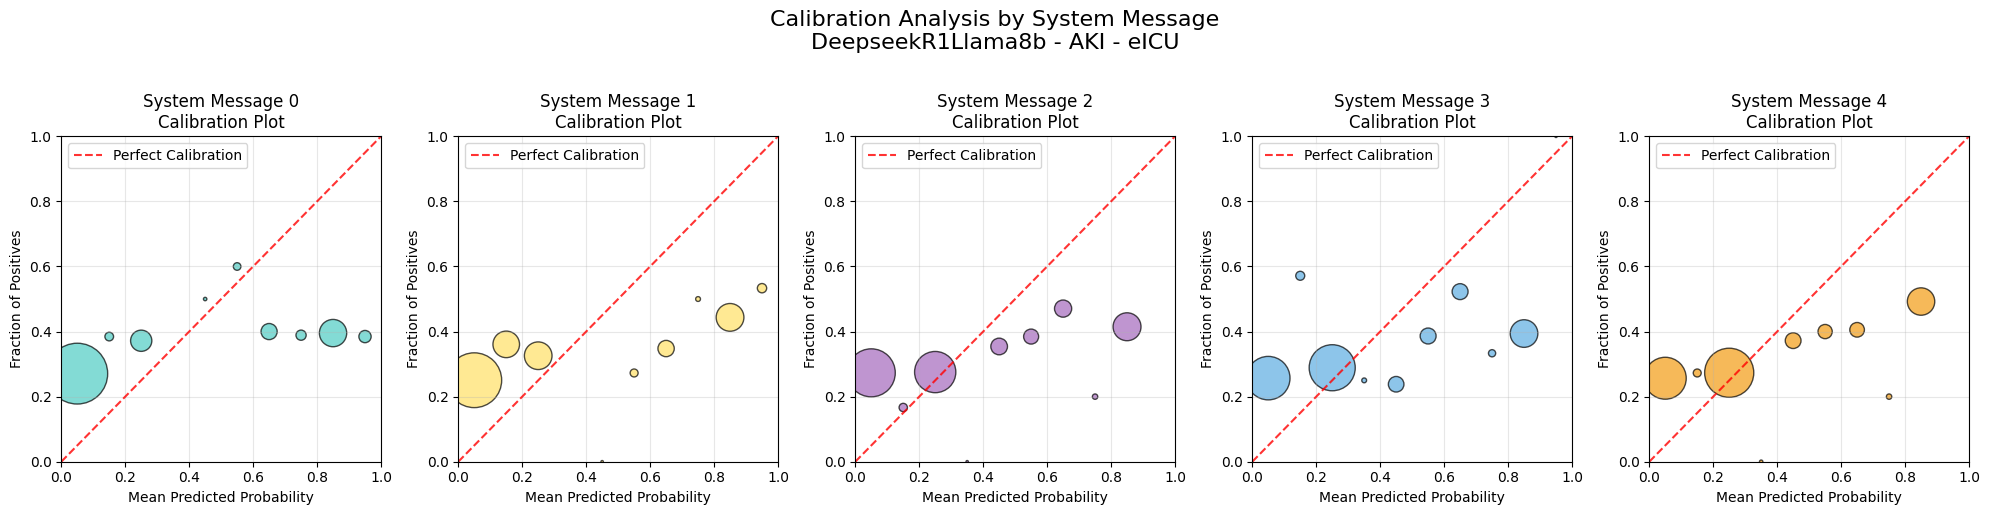


Distribution for Mortality-HiRID (n=500):
  System Message 0:
    Records: 100
    Positive samples: 11
    Negative samples: 89
    Positive rate (actual): 0.110
    Mean predicted probability: 0.661
    Std predicted probability: 0.269
    Calibration error (|pred_mean - pos_rate|): 0.551
    AUPRC: 0.408
  System Message 1:
    Records: 100
    Positive samples: 11
    Negative samples: 89
    Positive rate (actual): 0.110
    Mean predicted probability: 0.652
    Std predicted probability: 0.270
    Calibration error (|pred_mean - pos_rate|): 0.542
    AUPRC: 0.203
  System Message 2:
    Records: 100
    Positive samples: 11
    Negative samples: 89
    Positive rate (actual): 0.110
    Mean predicted probability: 0.611
    Std predicted probability: 0.243
    Calibration error (|pred_mean - pos_rate|): 0.501
    AUPRC: 0.124
  System Message 3:
    Records: 100
    Positive samples: 11
    Negative samples: 89
    Positive rate (actual): 0.110
    Mean predicted probability: 0.6

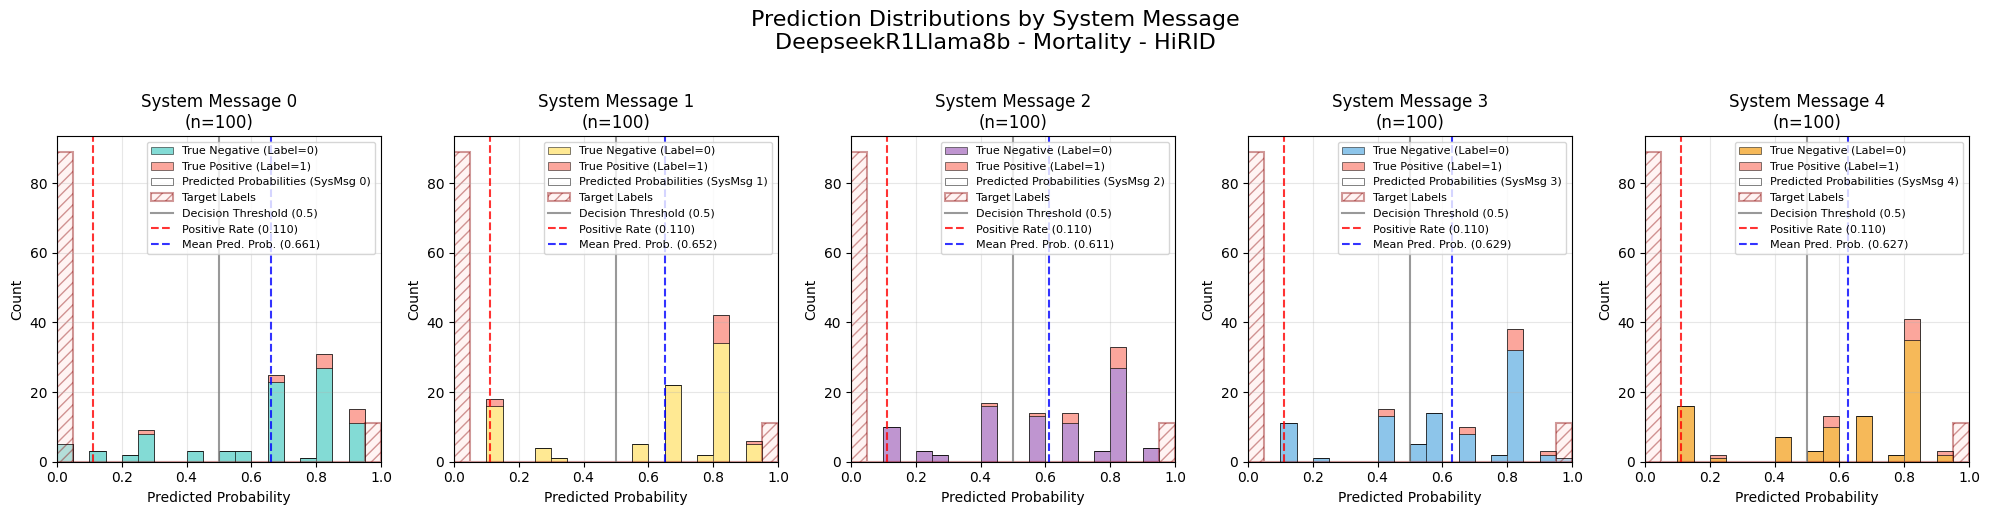

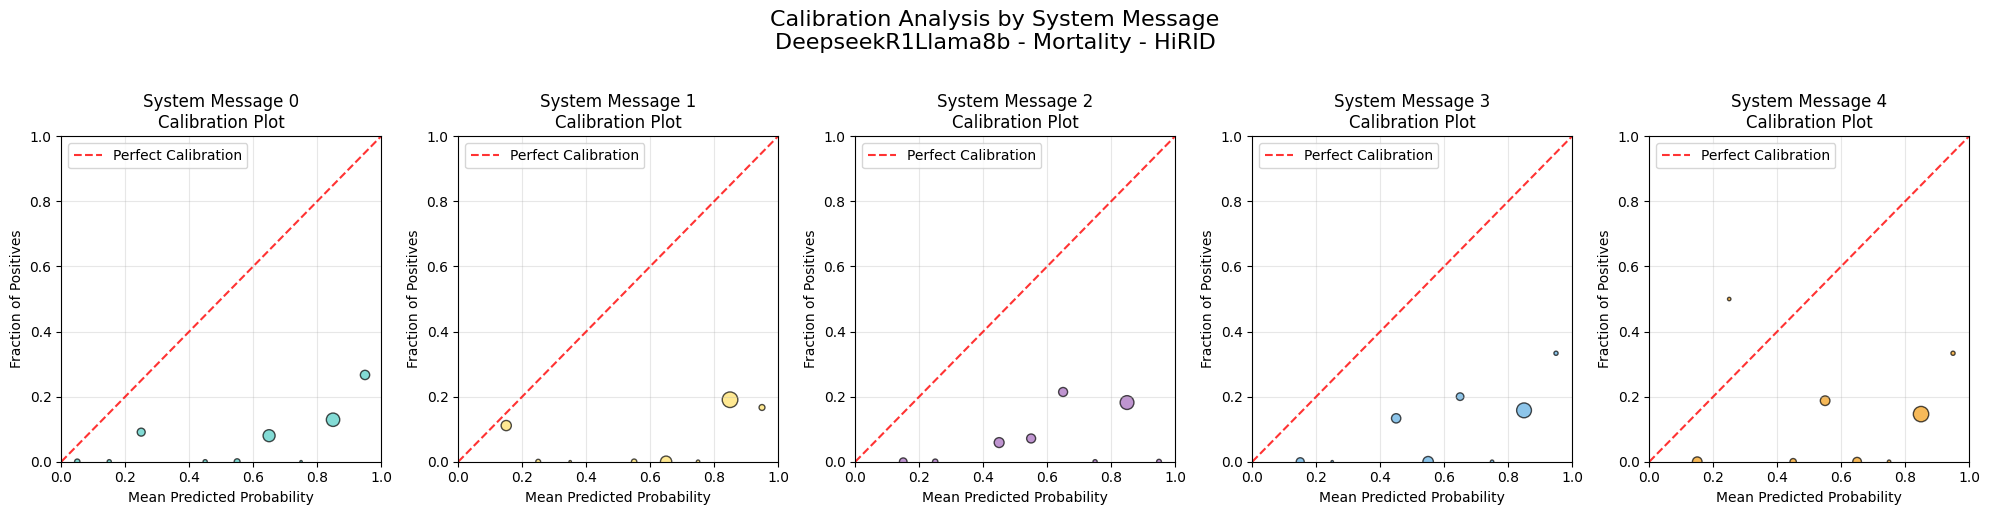


Distribution for Mortality-MIMIC-IV (n=500):
  System Message 0:
    Records: 100
    Positive samples: 12
    Negative samples: 88
    Positive rate (actual): 0.120
    Mean predicted probability: 0.595
    Std predicted probability: 0.263
    Calibration error (|pred_mean - pos_rate|): 0.475
    AUPRC: 0.293
  System Message 1:
    Records: 100
    Positive samples: 12
    Negative samples: 88
    Positive rate (actual): 0.120
    Mean predicted probability: 0.528
    Std predicted probability: 0.282
    Calibration error (|pred_mean - pos_rate|): 0.408
    AUPRC: 0.317
  System Message 2:
    Records: 100
    Positive samples: 12
    Negative samples: 88
    Positive rate (actual): 0.120
    Mean predicted probability: 0.490
    Std predicted probability: 0.248
    Calibration error (|pred_mean - pos_rate|): 0.370
    AUPRC: 0.131
  System Message 3:
    Records: 100
    Positive samples: 12
    Negative samples: 88
    Positive rate (actual): 0.120
    Mean predicted probability: 

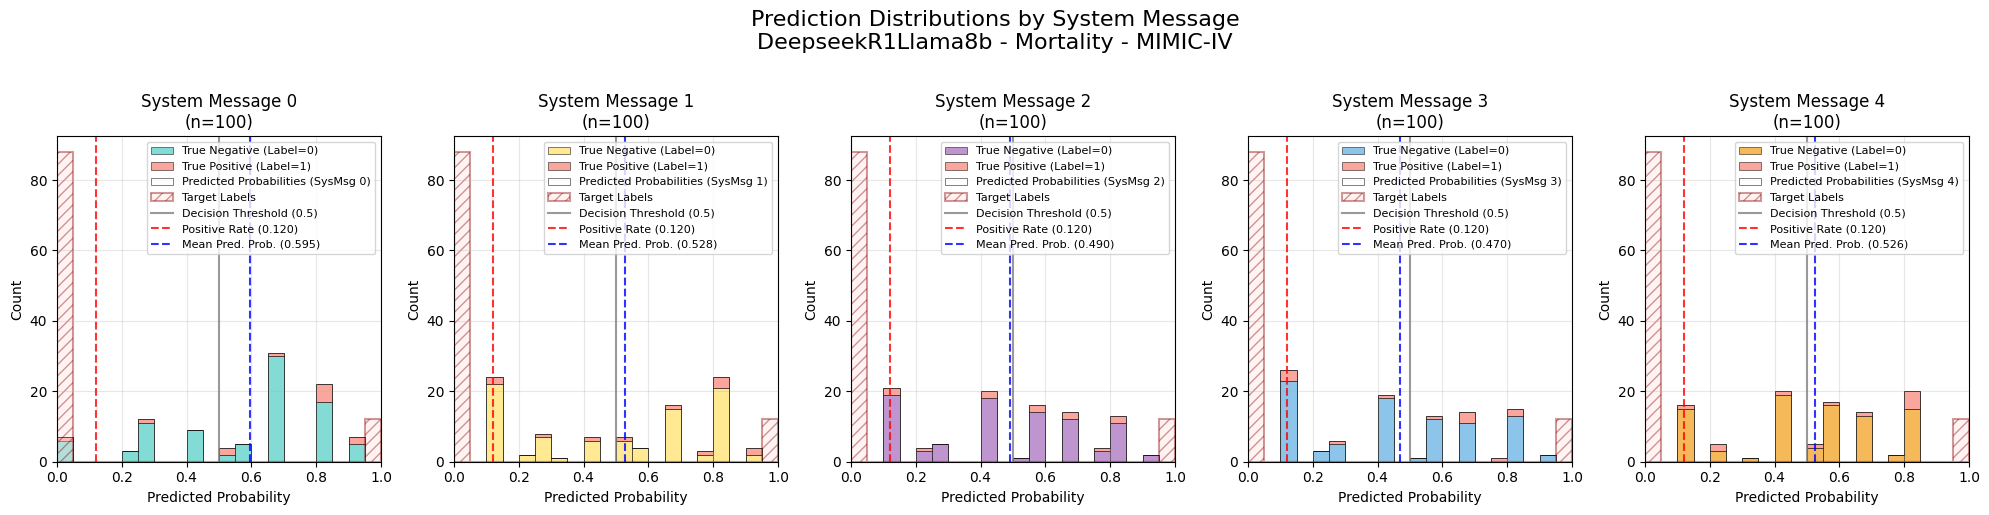

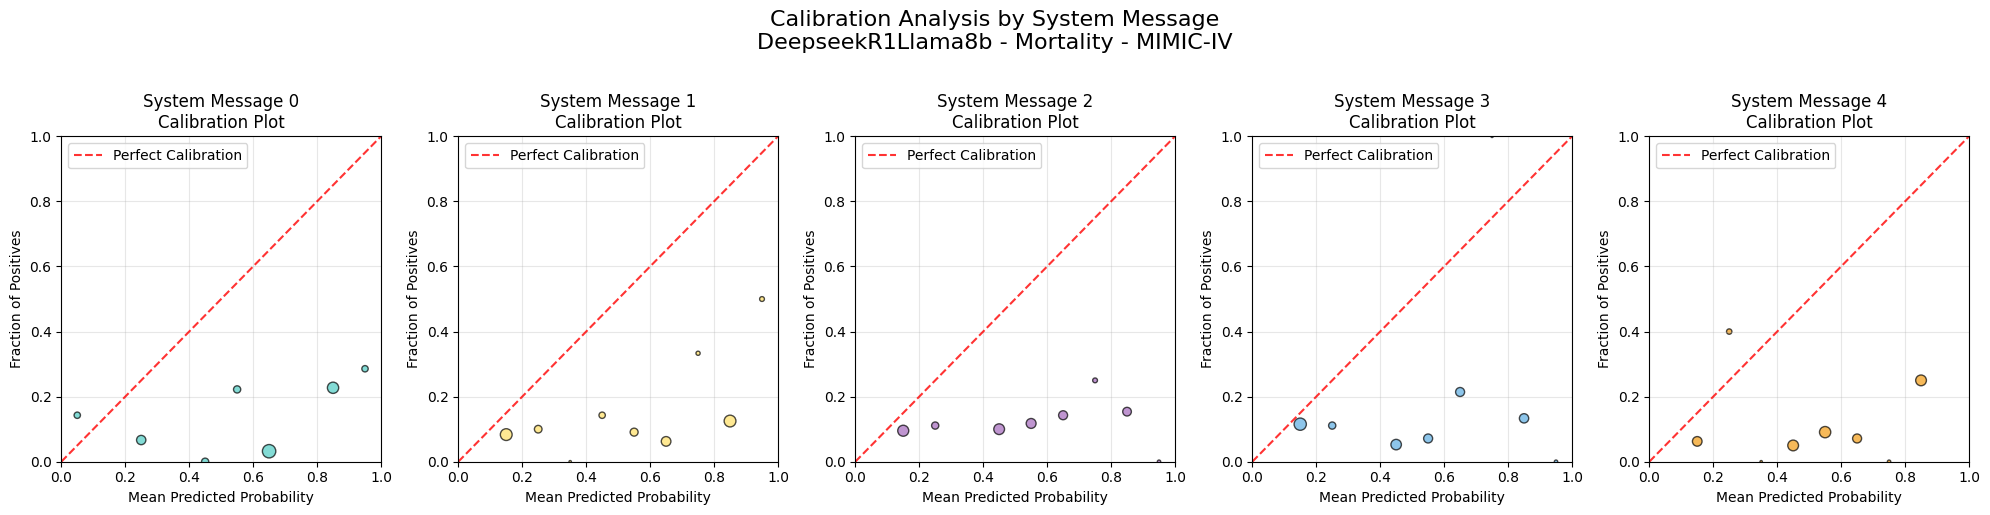


Distribution for Mortality-eICU (n=500):
  System Message 0:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.510
    Std predicted probability: 0.324
    Calibration error (|pred_mean - pos_rate|): 0.440
    AUPRC: 0.169
  System Message 1:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.434
    Std predicted probability: 0.276
    Calibration error (|pred_mean - pos_rate|): 0.364
    AUPRC: 0.234
  System Message 2:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.453
    Std predicted probability: 0.243
    Calibration error (|pred_mean - pos_rate|): 0.383
    AUPRC: 0.137
  System Message 3:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.440
  

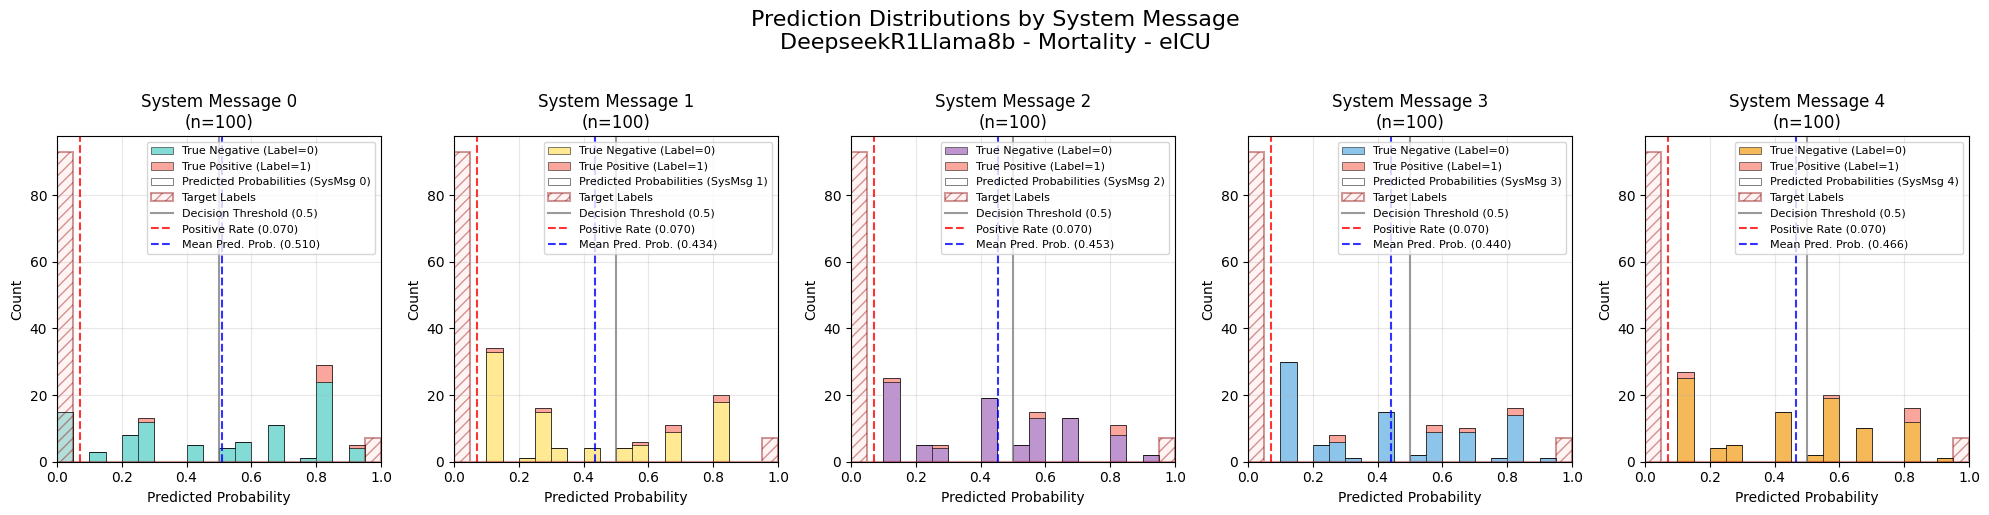

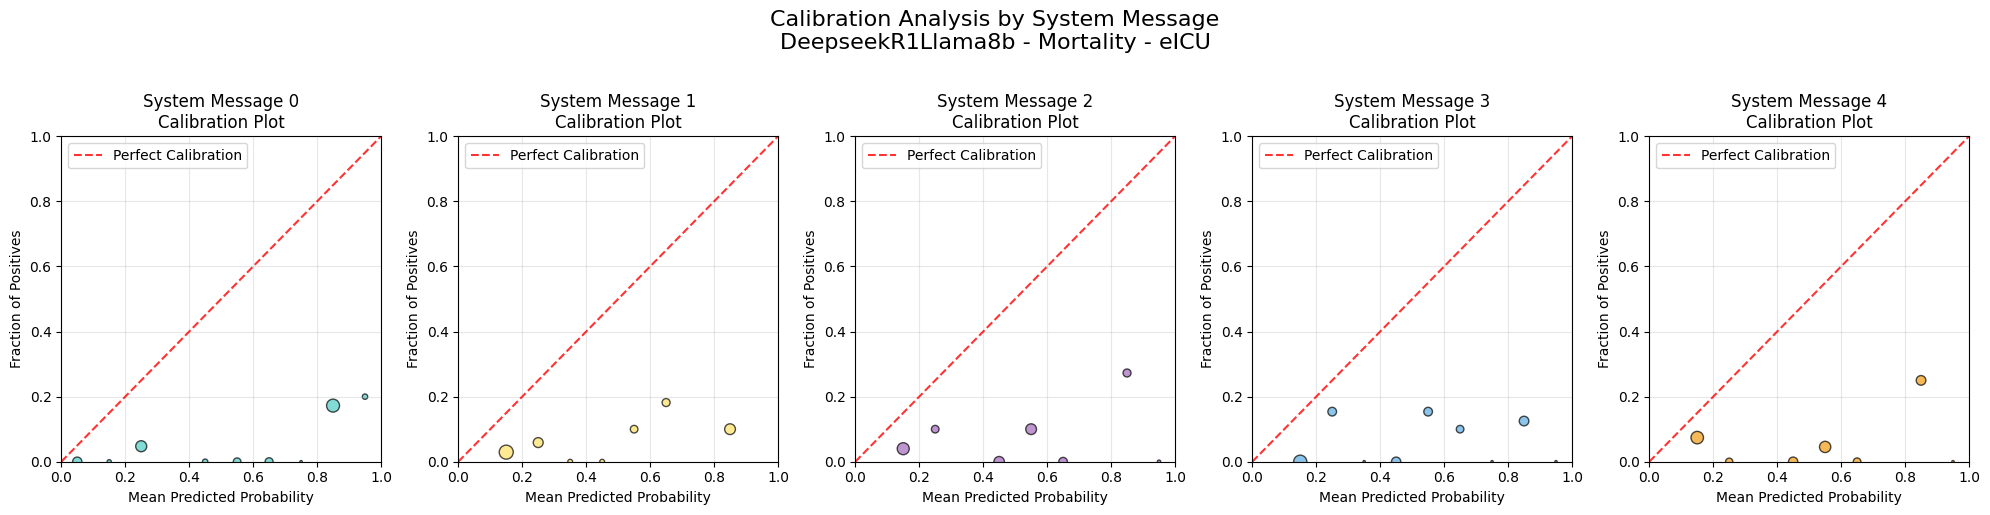


Model: Llama3

Distribution for AKI-eICU (n=4920):
  System Message 0:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.505
    Std predicted probability: 0.471
    Calibration error (|pred_mean - pos_rate|): 0.195
    AUPRC: 0.521
  System Message 1:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.031
    Std predicted probability: 0.169
    Calibration error (|pred_mean - pos_rate|): 0.279
    AUPRC: 0.360
  System Message 2:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.082
    Std predicted probability: 0.163
    Calibration error (|pred_mean - pos_rate|): 0.228
    AUPRC: 0.396
  System Message 3:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted

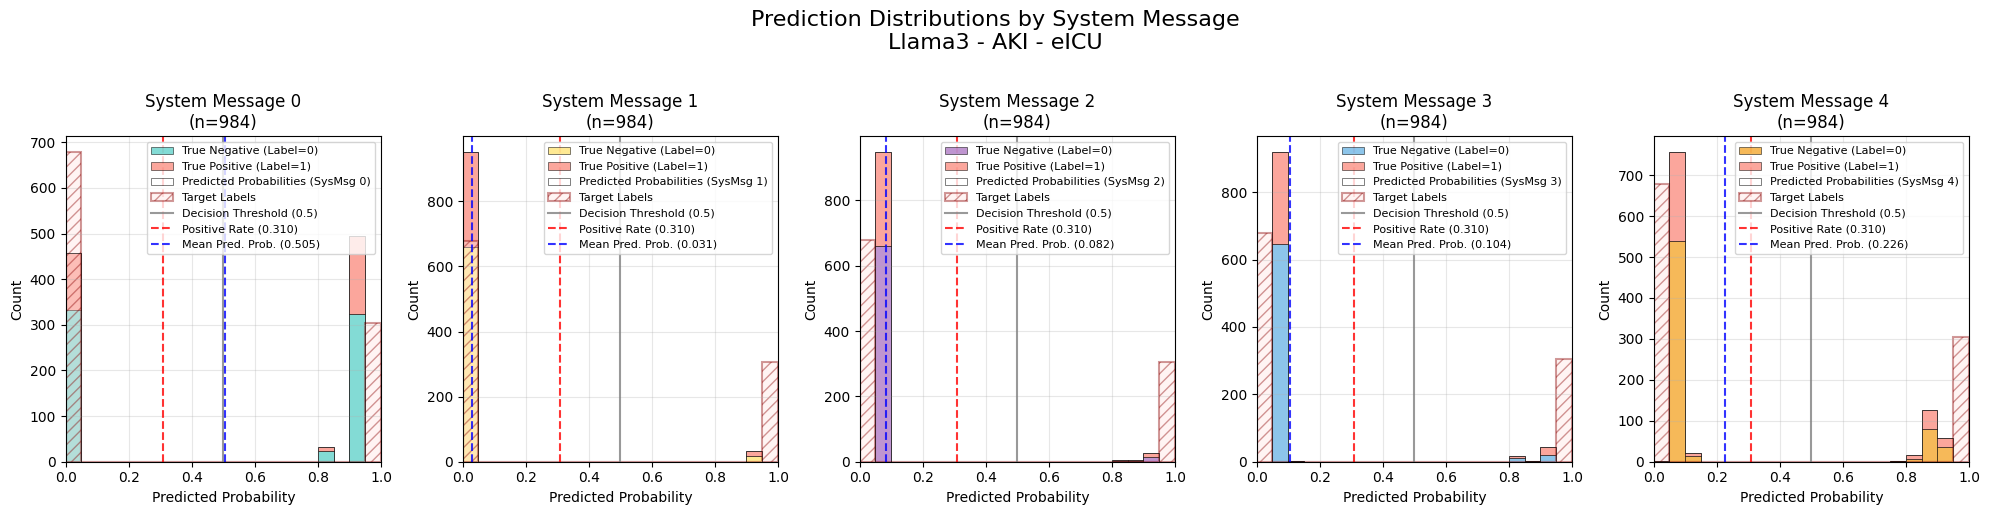

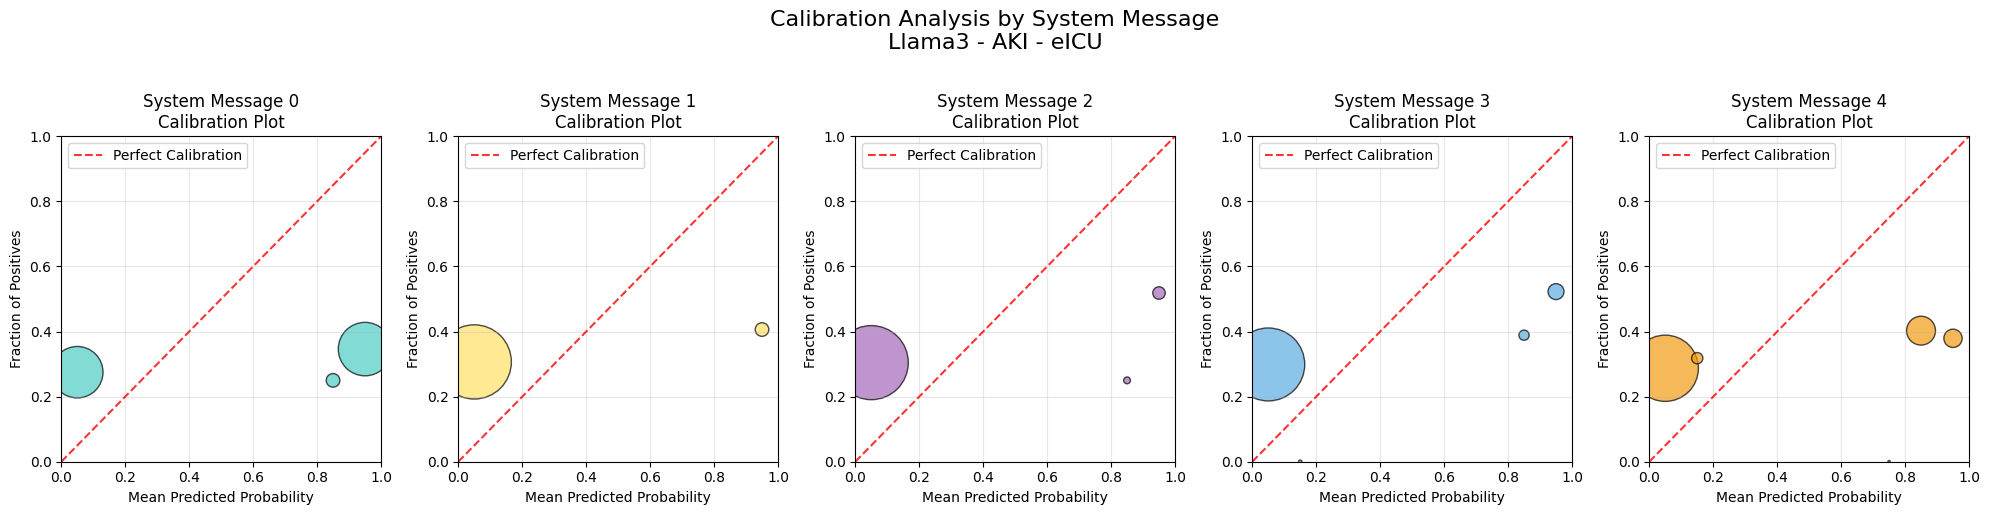


Distribution for Mortality-eICU (n=500):
  System Message 0:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.263
    Std predicted probability: 0.424
    Calibration error (|pred_mean - pos_rate|): 0.193
    AUPRC: 0.377
  System Message 1:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.850
    Std predicted probability: 0.000
    Calibration error (|pred_mean - pos_rate|): 0.780
    AUPRC: 0.535
  System Message 2:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.850
    Std predicted probability: 0.000
    Calibration error (|pred_mean - pos_rate|): 0.780
    AUPRC: 0.535
  System Message 3:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.852
  

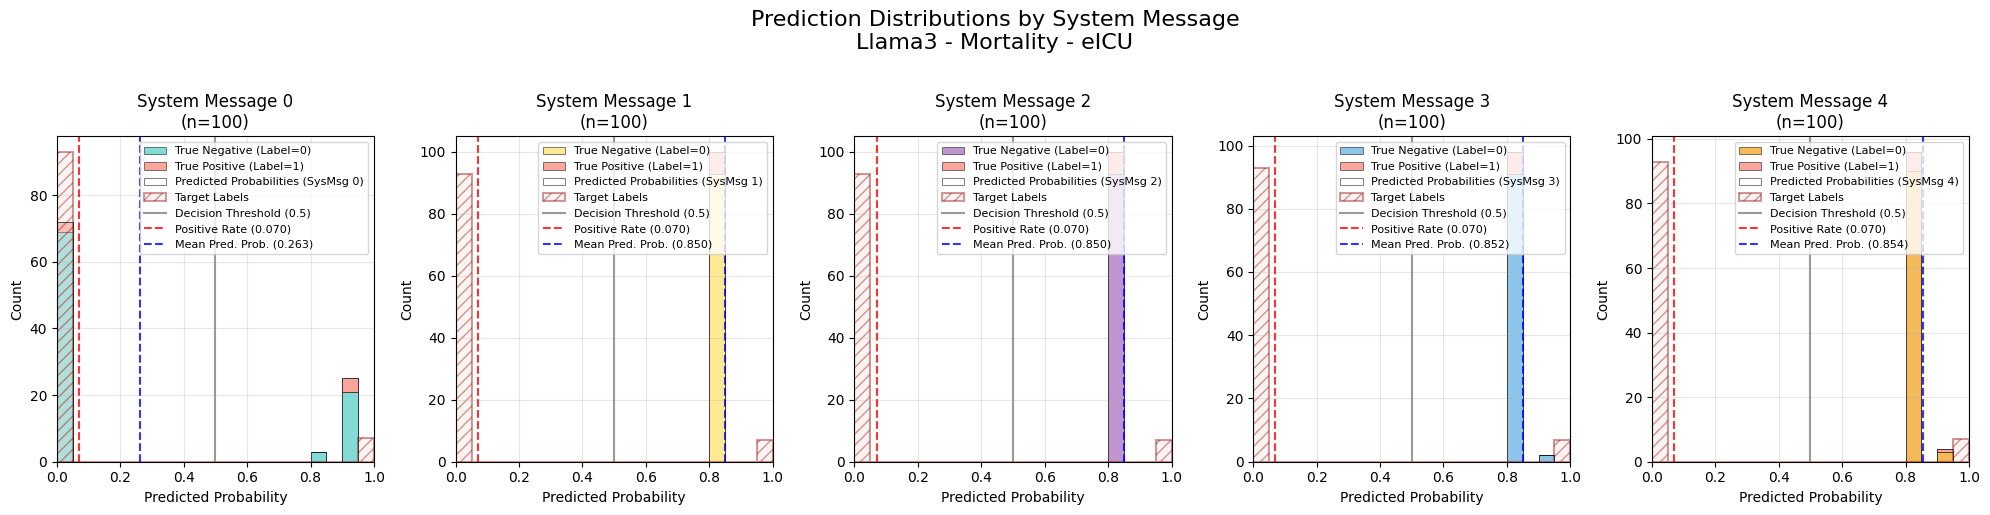

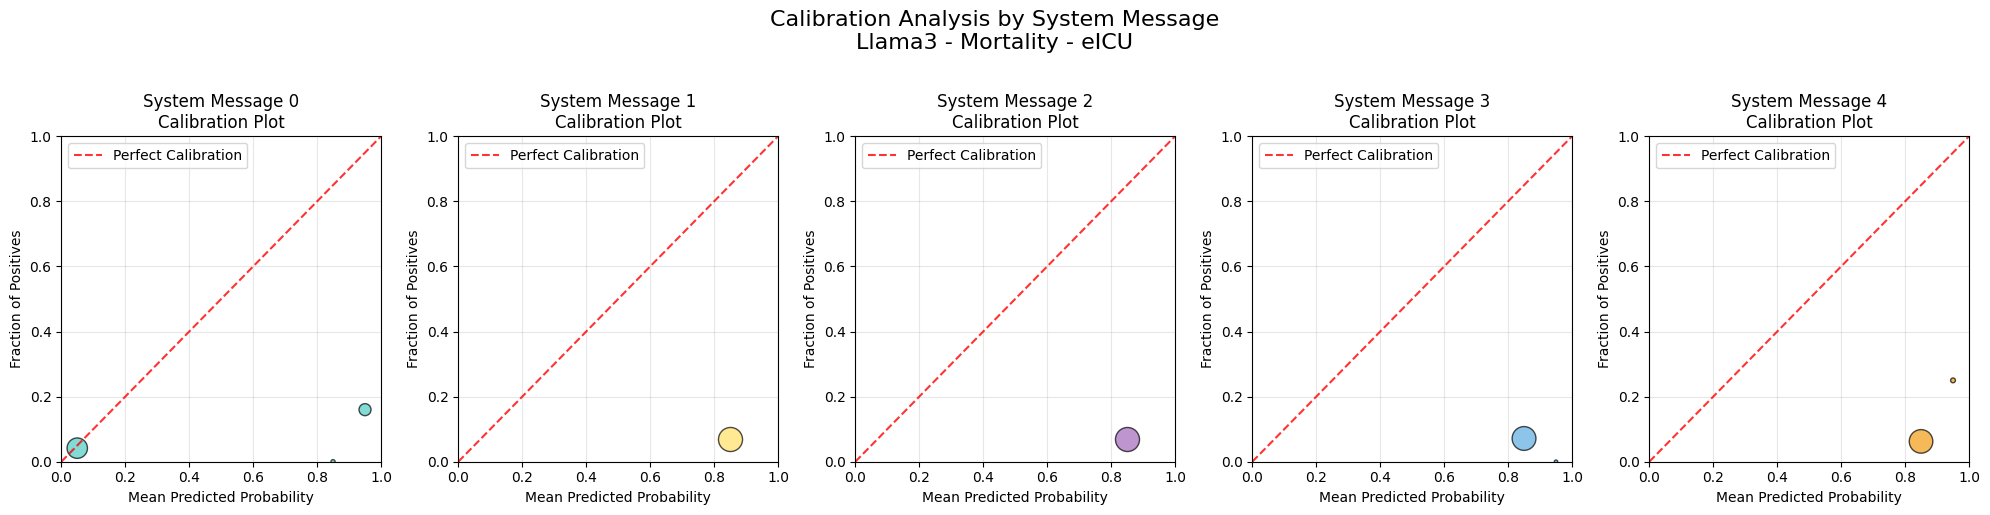


Distribution for Sepsis-eICU (n=4900):
  System Message 0:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.752
    Std predicted probability: 0.334
    Calibration error (|pred_mean - pos_rate|): 0.704
    AUPRC: 0.171
  System Message 1:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.583
    Std predicted probability: 0.400
    Calibration error (|pred_mean - pos_rate|): 0.535
    AUPRC: 0.052
  System Message 2:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.622
    Std predicted probability: 0.345
    Calibration error (|pred_mean - pos_rate|): 0.574
    AUPRC: 0.306
  System Message 3:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.

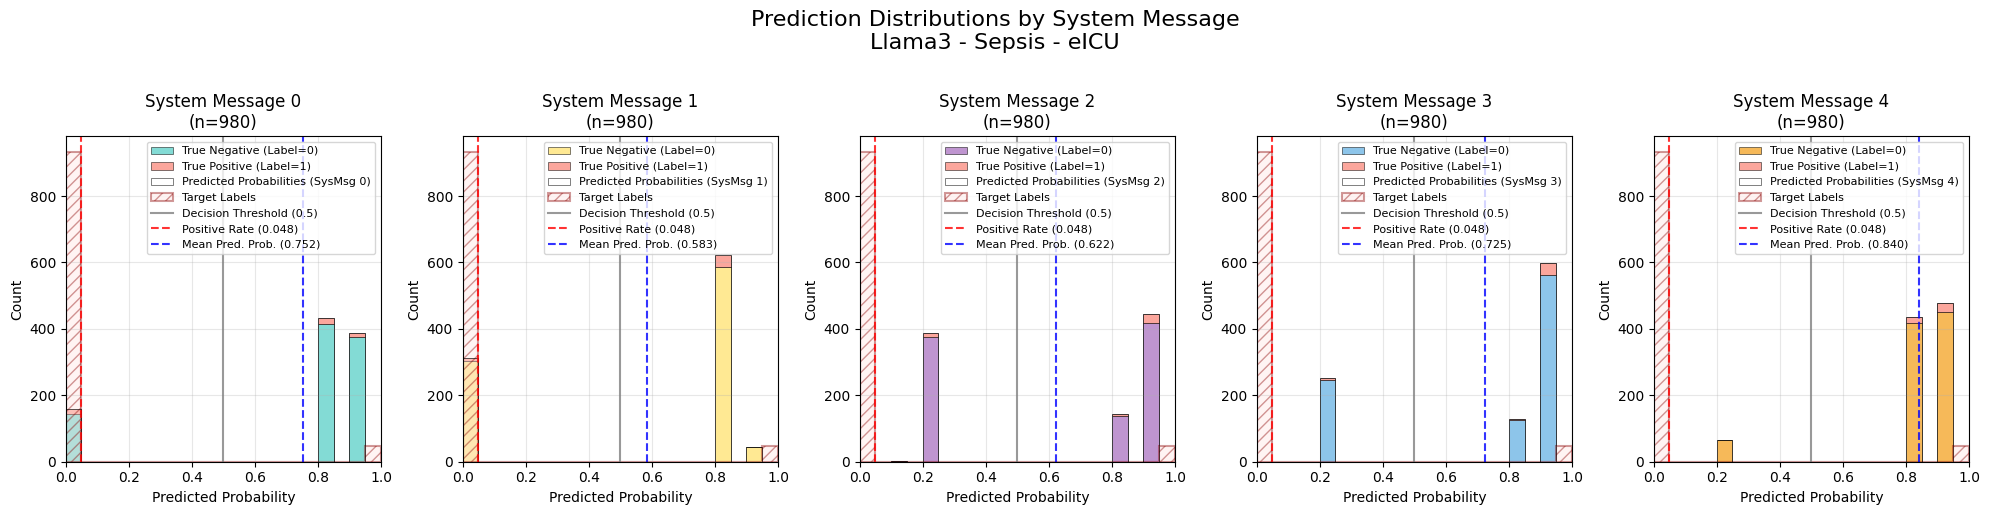

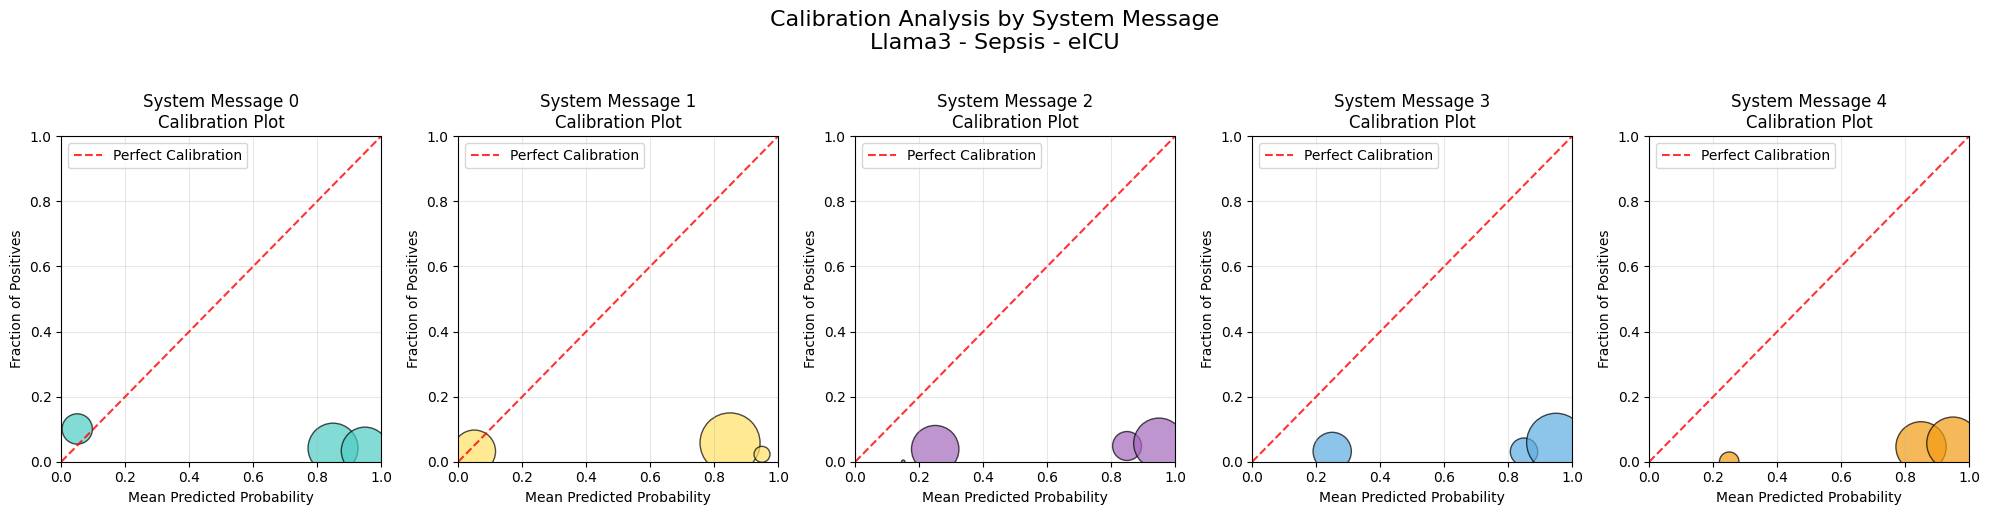


Model: Mistral

Distribution for AKI-eICU (n=4920):
  System Message 0:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.133
    Std predicted probability: 0.306
    Calibration error (|pred_mean - pos_rate|): 0.177
    AUPRC: 0.311
  System Message 1:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.956
    Std predicted probability: 0.061
    Calibration error (|pred_mean - pos_rate|): 0.646
    AUPRC: 0.489
  System Message 2:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicted probability: 0.200
    Std predicted probability: 0.260
    Calibration error (|pred_mean - pos_rate|): 0.110
    AUPRC: 0.328
  System Message 3:
    Records: 984
    Positive samples: 305
    Negative samples: 679
    Positive rate (actual): 0.310
    Mean predicte

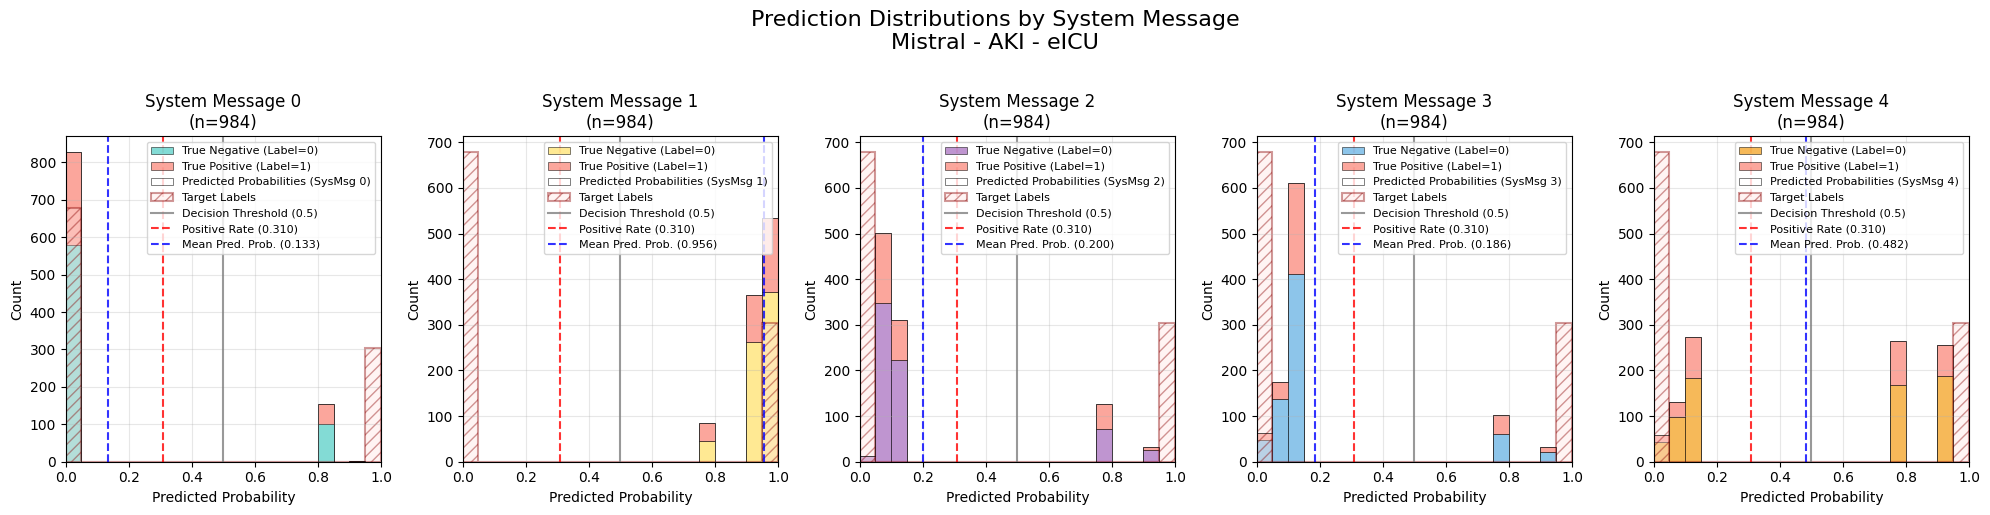

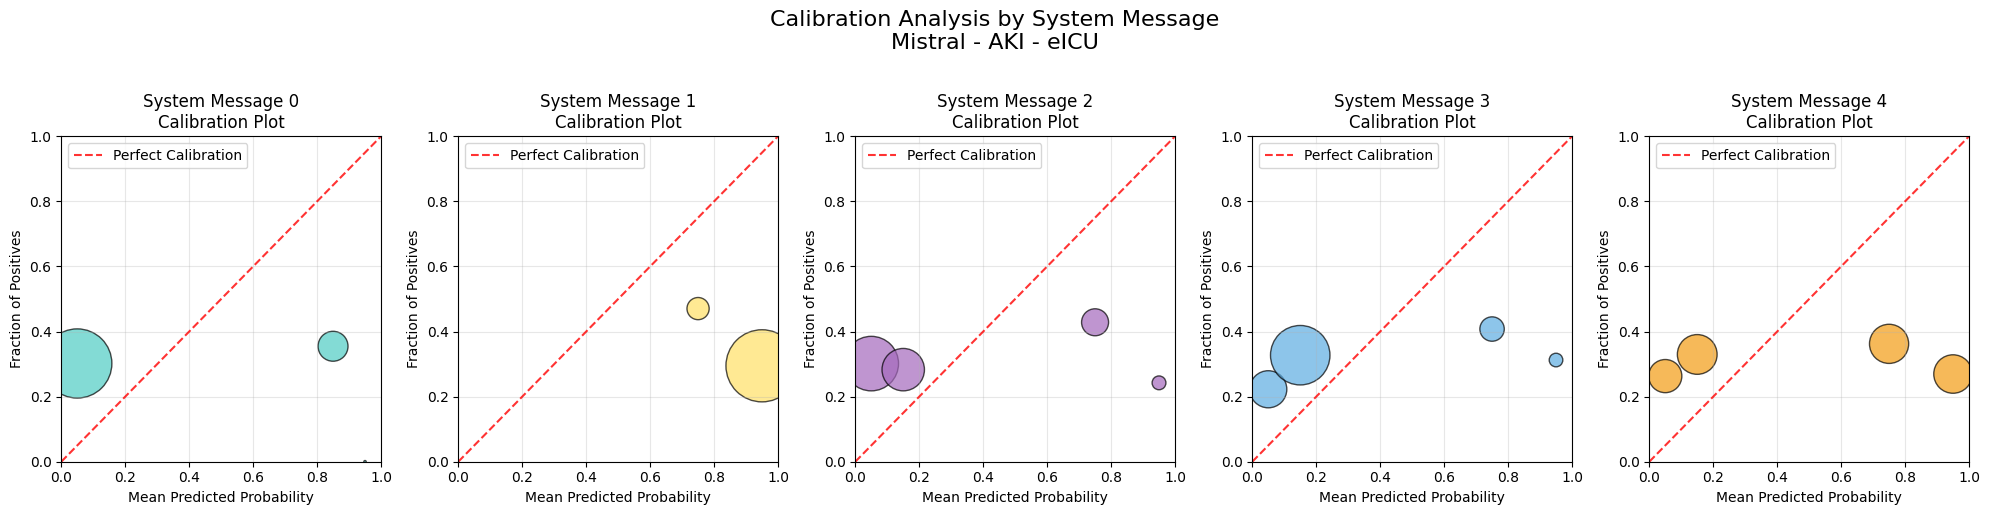


Distribution for Mortality-eICU (n=500):
  System Message 0:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.949
    Std predicted probability: 0.007
    Calibration error (|pred_mean - pos_rate|): 0.879
    AUPRC: 0.536
  System Message 1:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.898
    Std predicted probability: 0.045
    Calibration error (|pred_mean - pos_rate|): 0.828
    AUPRC: 0.192
  System Message 2:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.853
    Std predicted probability: 0.080
    Calibration error (|pred_mean - pos_rate|): 0.783
    AUPRC: 0.044
  System Message 3:
    Records: 100
    Positive samples: 7
    Negative samples: 93
    Positive rate (actual): 0.070
    Mean predicted probability: 0.874
  

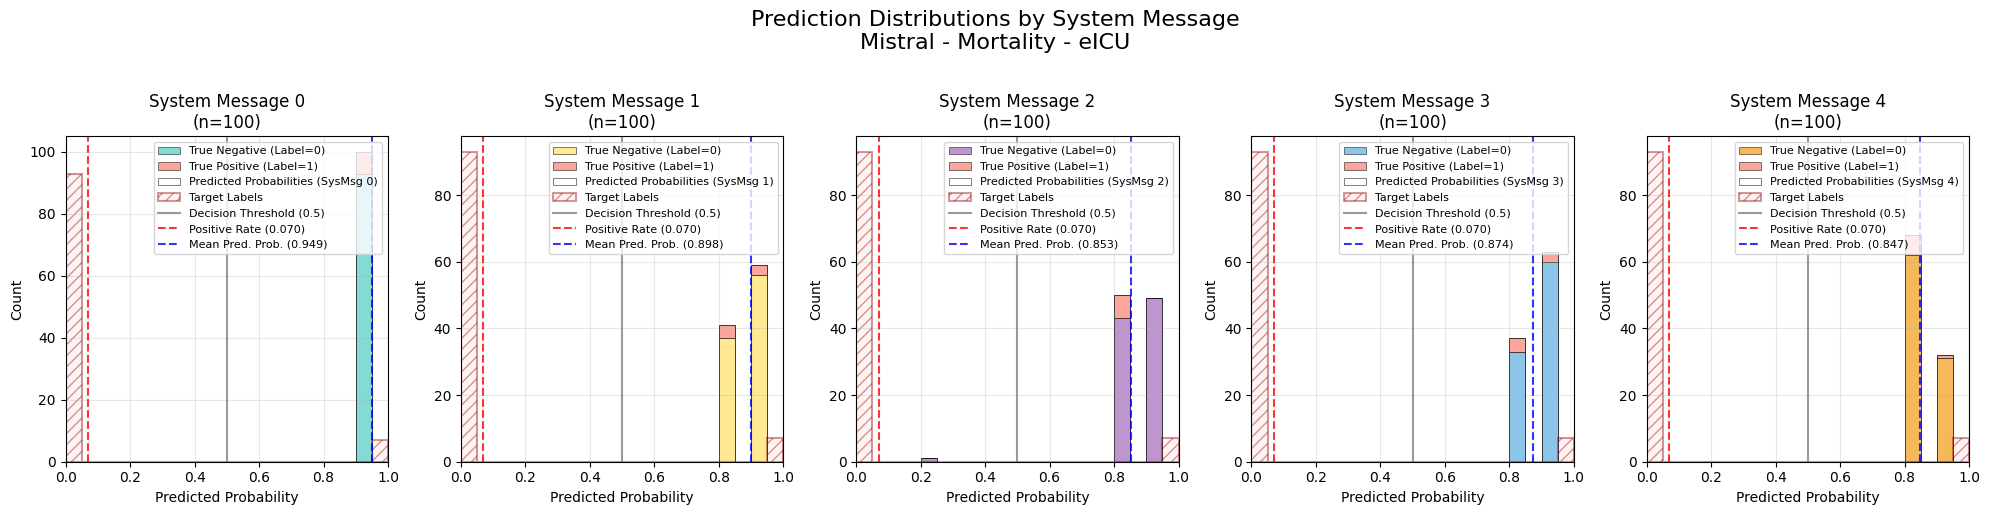

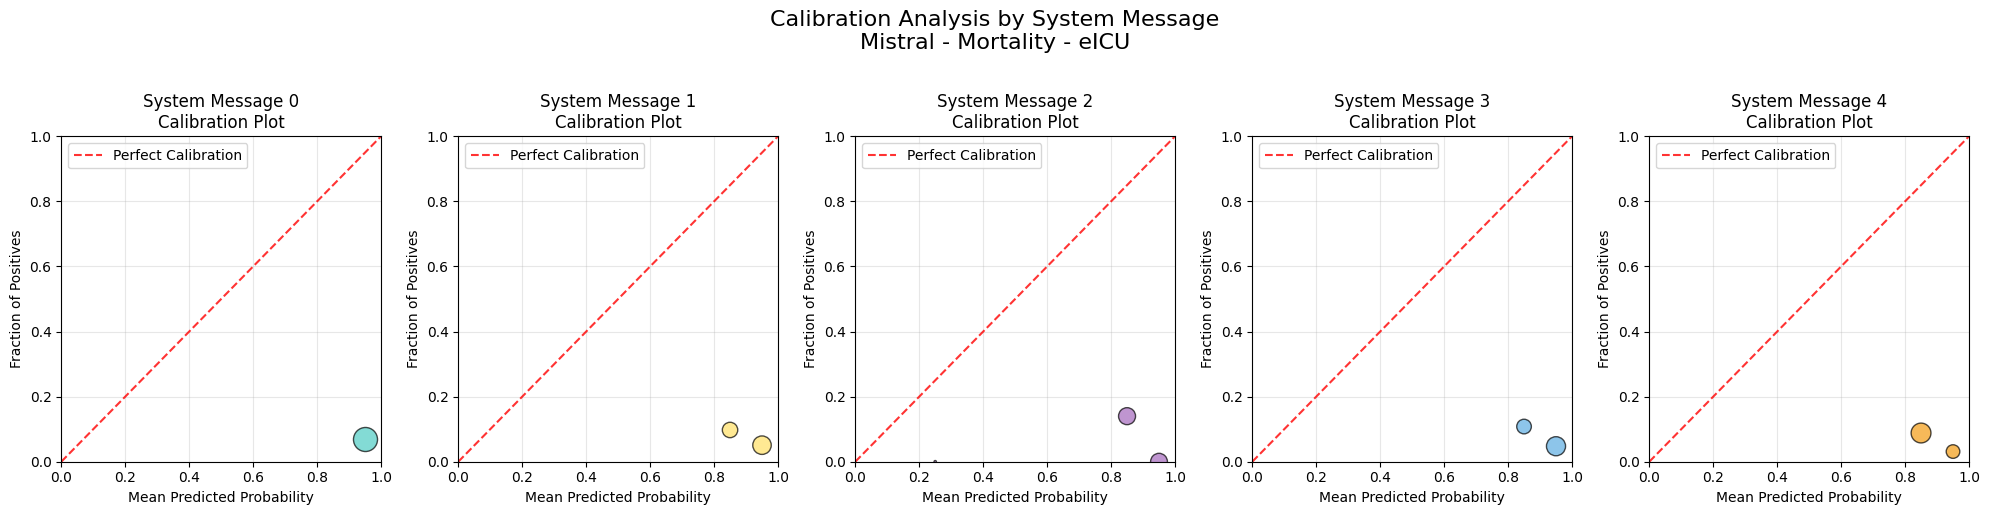


Distribution for Sepsis-eICU (n=4900):
  System Message 0:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.157
    Std predicted probability: 0.326
    Calibration error (|pred_mean - pos_rate|): 0.109
    AUPRC: 0.106
  System Message 1:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.152
    Std predicted probability: 0.155
    Calibration error (|pred_mean - pos_rate|): 0.104
    AUPRC: 0.024
  System Message 2:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.138
    Std predicted probability: 0.111
    Calibration error (|pred_mean - pos_rate|): 0.090
    AUPRC: 0.024
  System Message 3:
    Records: 980
    Positive samples: 47
    Negative samples: 933
    Positive rate (actual): 0.048
    Mean predicted probability: 0.

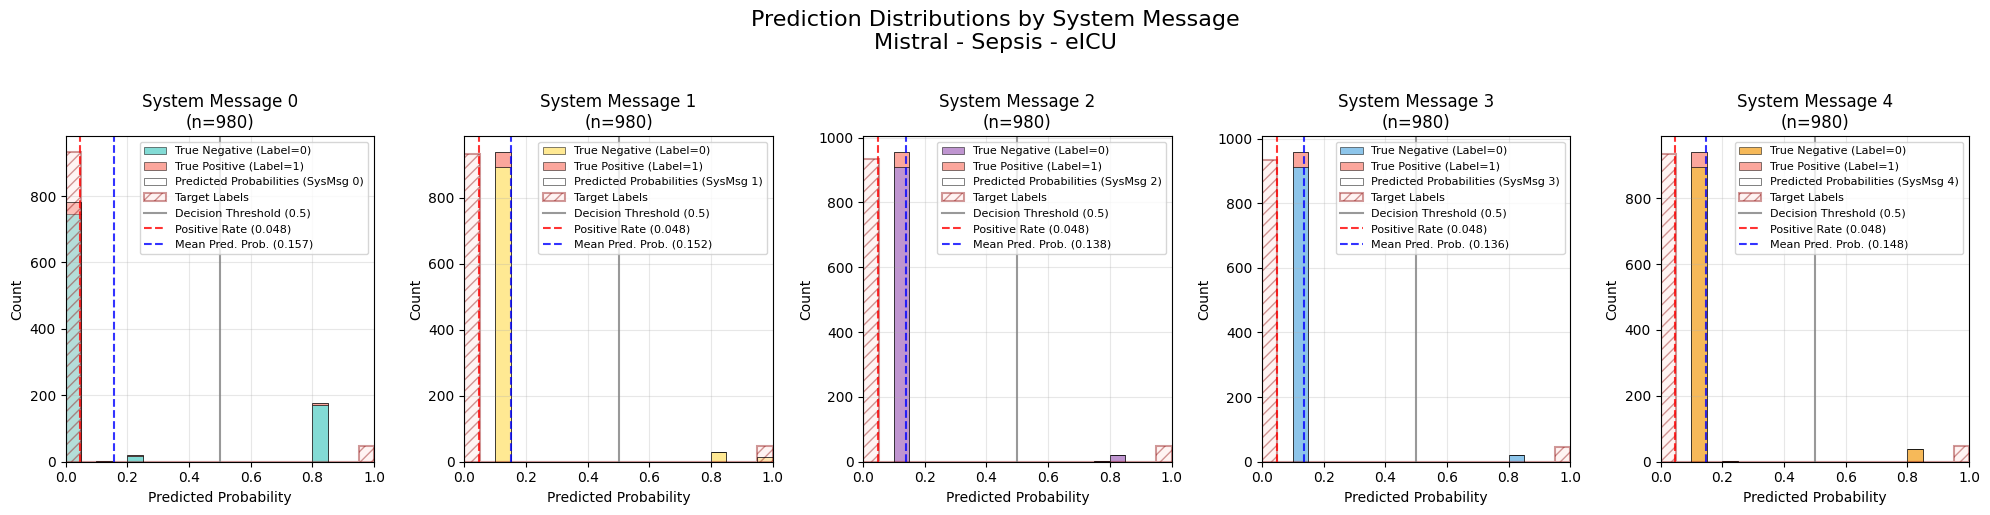

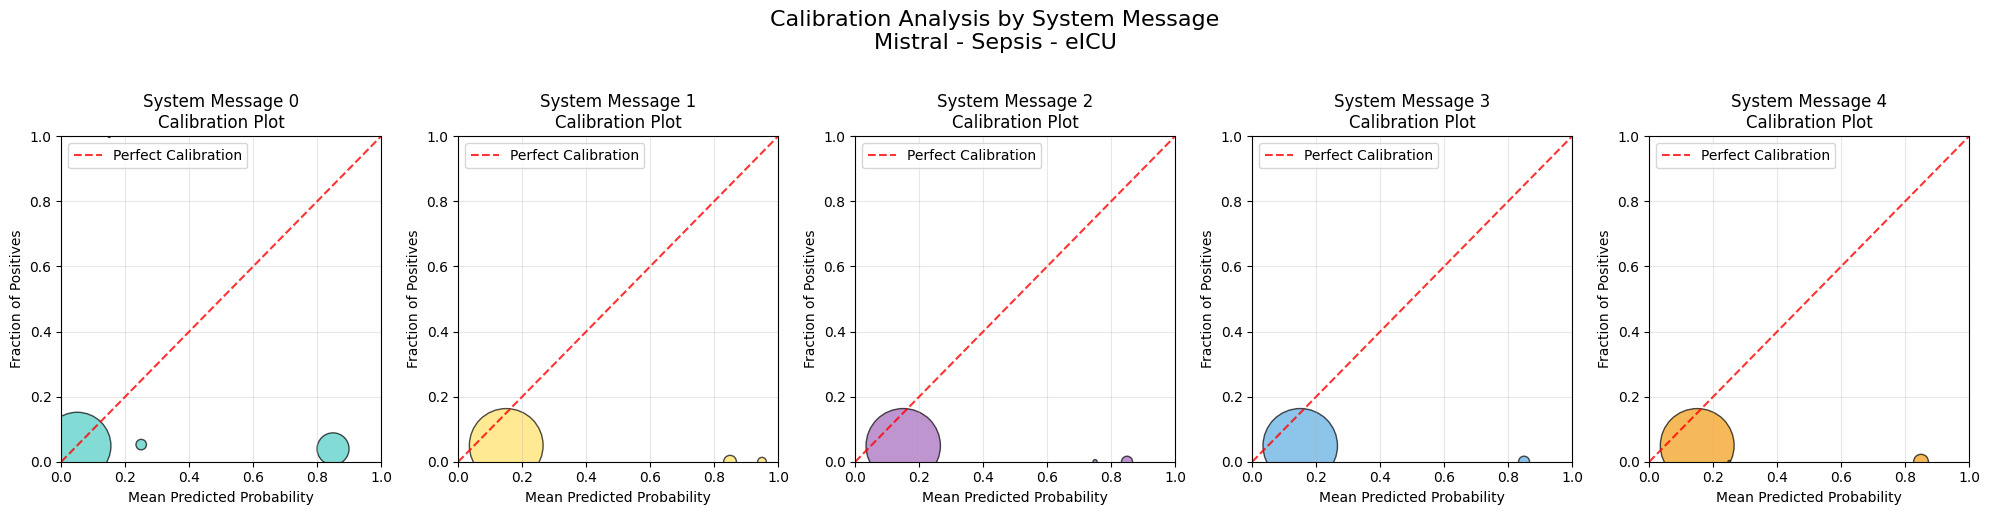

In [101]:
from matplotlib import cm

# Prediction Distribution Analysis
# Analyze distribution of predicted probabilities for each system message
if "System Message Index" in df_metadata.columns:
    print("Prediction Distribution Analysis by System Message Index:")

    # Create output directory for distribution plots
    output_dir_dist = os.path.join(OUTPUT_BASE_DIR, "prediction_distributions")
    os.makedirs(output_dir_dist, exist_ok=True)

    # Analyze all system message indices for detailed analysis
    unique_sys_msg_indices = sorted(df_metadata["System Message Index"].unique())

    print(
        f"\nAnalyzing prediction distributions for all System Message Indices: {unique_sys_msg_indices}"
    )

    # Analyze by model if multiple models exist
    if "model_name" in df_metadata.columns:
        models = df_metadata["model_name"].unique()
        for model in models:
            if model != "Unknown":
                df_model = df_metadata[df_metadata["model_name"] == model]
                task_dataset_combos = df_model.groupby(["Task", "Dataset"])

                print(f"\nModel: {model}")
                for (task, dataset), group in task_dataset_combos:
                    if len(group) > 20:  # Minimum threshold for meaningful distribution
                        print(f"\nDistribution for {task}-{dataset} (n={len(group)}):")

                        # Create subplot for all system messages
                        fig, axes = plt.subplots(
                            1,
                            len(unique_sys_msg_indices),
                            figsize=(4 * len(unique_sys_msg_indices), 5),
                        )
                        if len(unique_sys_msg_indices) == 1:
                            axes = [axes]  # Make it iterable if only one subplot

                        fig.suptitle(
                            f"Prediction Distributions by System Message\n{model} - {task} - {dataset}",
                            fontsize=16,
                            y=1.02,
                        )

                        for i, sys_msg_idx in enumerate(unique_sys_msg_indices):
                            ax = axes[i]

                            # Filter data for this specific system message
                            sys_msg_group = group[
                                group["System Message Index"] == sys_msg_idx
                            ]

                            if len(sys_msg_group) > 0:
                                # Histogram bins
                                bins = np.arange(0, 1.05, 0.05)

                                # Separate data by actual labels for stacked histogram
                                positive_samples = sys_msg_group[
                                    sys_msg_group["Target Label"] == 1
                                ]
                                negative_samples = sys_msg_group[
                                    sys_msg_group["Target Label"] == 0
                                ]

                                # Create stacked histogram showing actual labels (background)
                                # Use system message color for negatives, consistent red for positives
                                sys_msg_color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")
                                ax.hist(
                                    [
                                        negative_samples["Predicted Probability"],
                                        positive_samples["Predicted Probability"],
                                    ],
                                    bins=bins,
                                    alpha=0.7,  # More transparent for background
                                    label=[
                                        "True Negative (Label=0)",
                                        "True Positive (Label=1)",
                                    ],
                                    color=[sys_msg_color, "salmon"],
                                    edgecolor="black",
                                    linewidth=0.5,
                                    stacked=True,
                                )

                                # Overlay predicted probabilities with system message color
                                ax.hist(
                                    sys_msg_group['Predicted Probability'],
                                    bins=bins,
                                    alpha=0.7,
                                    label=f'Predicted Probabilities (SysMsg {sys_msg_idx})',
                                    edgecolor='black',
                                    color=SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000"),
                                    histtype='step',  # Only show outline
                                    linewidth=0.5
                                )

                                # Add target labels as separate step histogram
                                # Use a light fill with a subtle hatch pattern for the target labels histogram
                                ax.hist(
                                    sys_msg_group['Target Label'],
                                    bins=bins,
                                    alpha=0.4,
                                    label='Target Labels',
                                    edgecolor='darkred',
                                    facecolor='mistyrose',  # Light fill color
                                    histtype='stepfilled',
                                    linewidth=1.5,
                                    hatch='///'  # Subtle diagonal hatch pattern
                                )

                                # Add vertical line at 0.5 for decision threshold
                                ax.axvline(
                                    x=0.5,
                                    color="gray",
                                    linestyle="-",
                                    alpha=0.8,
                                    linewidth=1.5,
                                    label="Decision Threshold (0.5)",
                                )

                                # Calculate and add positive rate line
                                pos_rate = sys_msg_group["Target Label"].mean()
                                ax.axvline(
                                    x=pos_rate,
                                    color="red",
                                    linestyle="--",
                                    alpha=0.8,
                                    linewidth=1.5,
                                    label=f"Positive Rate ({pos_rate:.3f})",
                                )

                                # Calculate calibration statistics
                                pred_mean = sys_msg_group[
                                    "Predicted Probability"
                                ].mean()
                                ax.axvline(
                                    x=pred_mean,
                                    color="blue",
                                    linestyle="--",
                                    alpha=0.8,
                                    linewidth=1.5,
                                    label=f"Mean Pred. Prob. ({pred_mean:.3f})",
                                )

                                ax.set_xlabel("Predicted Probability", fontsize=10)
                                ax.set_ylabel("Count", fontsize=10)
                                ax.set_title(
                                    f"System Message {sys_msg_idx}\n(n={len(sys_msg_group)})",
                                    fontsize=12,
                                )
                                ax.legend(fontsize=8, loc="upper right")
                                ax.grid(alpha=0.3)

                                # Set x-axis limits and ticks for better readability
                                ax.set_xlim(0, 1)
                                ax.set_xticks(np.arange(0, 1.1, 0.2))

                                # Calculate and display basic statistics
                                pos_rate = sys_msg_group["Target Label"].mean()
                                pred_mean = sys_msg_group[
                                    "Predicted Probability"
                                ].mean()
                                pred_std = sys_msg_group["Predicted Probability"].std()

                                print(f"  System Message {sys_msg_idx}:")
                                print(f"    Records: {len(sys_msg_group)}")
                                print(f"    Positive samples: {len(positive_samples)}")
                                print(f"    Negative samples: {len(negative_samples)}")
                                print(f"    Positive rate (actual): {pos_rate:.3f}")
                                print(
                                    f"    Mean predicted probability: {pred_mean:.3f}"
                                )
                                print(f"    Std predicted probability: {pred_std:.3f}")

                                # Calculate calibration metrics
                                calibration_error = abs(pred_mean - pos_rate)
                                print(
                                    f"    Calibration error (|pred_mean - pos_rate|): {calibration_error:.3f}"
                                )

                                # Calculate specific metric for this subset
                                if len(sys_msg_group) > 0:
                                    auprc_val = calculate_auprc(
                                        sys_msg_group["Target Label"].values,
                                        sys_msg_group["Predicted Probability"].values,
                                    )
                                    # Handle case where calculate_auprc returns a dict or single value
                                    if isinstance(auprc_val, dict):
                                        auprc_value = auprc_val.get("auprc", 0.0)
                                    else:
                                        auprc_value = auprc_val
                                    print(f"    AUPRC: {auprc_value:.3f}")
                            else:
                                ax.text(
                                    0.5,
                                    0.5,
                                    f"No data for\nSystem Message {sys_msg_idx}",
                                    ha="center",
                                    va="center",
                                    transform=ax.transAxes,
                                )
                                ax.set_title(
                                    f"System Message {sys_msg_idx}\n(n=0)", fontsize=12
                                )

                        plt.tight_layout()

                        # Save the plot
                        save_filename = f"{model}_{task}_{dataset}_all_system_messages_distribution.png"
                        save_path = os.path.join(output_dir_dist, save_filename)
                        plt.savefig(save_path, dpi=300, bbox_inches="tight")

                        plt.show()

                        # Create an additional detailed calibration plot
                        fig_cal, axes_cal = plt.subplots(
                            1,
                            len(unique_sys_msg_indices),
                            figsize=(4 * len(unique_sys_msg_indices), 5),
                        )
                        if len(unique_sys_msg_indices) == 1:
                            axes_cal = [axes_cal]

                        fig_cal.suptitle(
                            f"Calibration Analysis by System Message\n{model} - {task} - {dataset}",
                            fontsize=16,
                            y=1.02,
                        )

                        for i, sys_msg_idx in enumerate(unique_sys_msg_indices):
                            ax_cal = axes_cal[i]
                            sys_msg_group = group[
                                group["System Message Index"] == sys_msg_idx
                            ]

                            if len(sys_msg_group) > 0:
                                # Create probability bins for calibration analysis
                                prob_bins = np.arange(0, 1.1, 0.1)
                                bin_centers = []
                                bin_accuracies = []
                                bin_counts = []

                                for j in range(len(prob_bins) - 1):
                                    bin_mask = (
                                        sys_msg_group["Predicted Probability"]
                                        >= prob_bins[j]
                                    ) & (
                                        sys_msg_group["Predicted Probability"]
                                        < prob_bins[j + 1]
                                    )
                                    bin_data = sys_msg_group[bin_mask]

                                    if len(bin_data) > 0:
                                        bin_centers.append(
                                            (prob_bins[j] + prob_bins[j + 1]) / 2
                                        )
                                        bin_accuracies.append(
                                            bin_data["Target Label"].mean()
                                        )
                                        bin_counts.append(len(bin_data))
                                    else:
                                        bin_centers.append(
                                            (prob_bins[j] + prob_bins[j + 1]) / 2
                                        )
                                        bin_accuracies.append(np.nan)
                                        bin_counts.append(0)

                                # Plot calibration curve
                                valid_indices = ~np.isnan(bin_accuracies)
                                if np.any(valid_indices):
                                    ax_cal.scatter(
                                        np.array(bin_centers)[valid_indices],
                                        np.array(bin_accuracies)[valid_indices],
                                        s=np.array(bin_counts)[valid_indices]
                                        * 3,  # Size based on count
                                        alpha=0.7,
                                        color=SYSTEM_MESSAGE_COLORS.get(
                                            sys_msg_idx, "#000000"
                                        ),
                                        edgecolor="black",
                                    )

                                # Perfect calibration line
                                ax_cal.plot(
                                    [0, 1],
                                    [0, 1],
                                    "r--",
                                    alpha=0.8,
                                    label="Perfect Calibration",
                                )

                                ax_cal.set_xlabel("Mean Predicted Probability")
                                ax_cal.set_ylabel("Fraction of Positives")
                                ax_cal.set_title(
                                    f"System Message {sys_msg_idx}\nCalibration Plot"
                                )
                                ax_cal.legend()
                                ax_cal.grid(alpha=0.3)
                                ax_cal.set_xlim(0, 1)
                                ax_cal.set_ylim(0, 1)

                        plt.tight_layout()

                        # Save calibration plot
                        cal_save_filename = (
                            f"{model}_{task}_{dataset}_calibration_analysis.png"
                        )
                        cal_save_path = os.path.join(output_dir_dist, cal_save_filename)
                        plt.savefig(cal_save_path, dpi=300, bbox_inches="tight")

                        plt.show()

else:
    print("Cannot perform distribution analysis - no System Message Index column found")

---

# Radar Charts by Metrics

This section generates radar charts where each chart represents a single metric, with axes showing different task-dataset combinations. This allows for easy comparison of how different system message indices perform across various clinical scenarios for each specific metric.

In [77]:
def create_radar_chart_for_metric(metric, data, sys_msg_indices=None, save_path=None, ax=None):
    """
    Create a radar chart for a specific metric comparing all system message indices across task-dataset combinations.
    Shows mean performance with standard deviation areas.
    """
    # If no system message indices specified, use all available
    if sys_msg_indices is None:
        sys_msg_indices = sorted(data["System_Message_Index"].unique())
    
    # Use the specified order for tasks and datasets
    task_dataset_combinations = []
    for task in task_order:
        for dataset in dataset_order:
            filtered_data = data[(data['Task'] == task) & (data['Dataset'] == dataset)]
            if not filtered_data.empty:
                task_dataset_combinations.append(f"{task}-{dataset}")
    
    # Number of task-dataset combinations (axes)
    N = len(task_dataset_combinations)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon
    
    # Initialize the plot if no ax provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    else:
        fig = plt.gcf()
    
    # Set the angle for each axis
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_theta_direction(-1)  # Go clockwise
    
    # Calculate baseline values for this metric
    baseline_values = []
    for combination in task_dataset_combinations:
        task, dataset = combination.split('-', 1)
        prevalence = class_prevalence.get(task, {}).get(dataset, 0)
        baseline = {
            "AUROC": 0.5,
            "AUPRC": prevalence,
            "Normalized AUPRC": 1,
            "Min(+P, Se)": prevalence,
            "Sensitivity (Recall)": prevalence,
            "Specificity": 1 - prevalence,
            "Precision": prevalence,
            "F1 Score": prevalence,
            "Accuracy": max(prevalence, 1 - prevalence),
            "Balanced Accuracy": 0.5,
            "MCC": 0,
            "Cohen's Kappa": 0
        }.get(metric, 0)
        baseline_values.append(baseline)
    
    baseline_values += baseline_values[:1]  # Close the polygon
    
    # Plot baseline
    ax.plot(
        angles,
        baseline_values,
        linewidth=1,
        linestyle="dashed",
        color="red",
        label="Random Guessing",
        zorder=5,
    )
    
    # Plot each system message index with std deviation areas
    for sys_msg_idx in sys_msg_indices:
        sys_msg_values = []
        sys_msg_stds = []
        
        for combination in task_dataset_combinations:
            task, dataset = combination.split('-', 1)
            sys_msg_data = data[
                (data['Task'] == task) & 
                (data['Dataset'] == dataset) & 
                (data['System_Message_Index'] == sys_msg_idx)
            ]
            
            if not sys_msg_data.empty and metric in sys_msg_data.columns:
                value = sys_msg_data[metric].values[0]
                std_value = sys_msg_data[f"{metric}_std"].values[0] if f"{metric}_std" in sys_msg_data.columns else 0
                
                if not pd.isna(value):
                    sys_msg_values.append(value)
                    sys_msg_stds.append(std_value if not pd.isna(std_value) else 0)
                else:
                    sys_msg_values.append(0)
                    sys_msg_stds.append(0)
            else:
                sys_msg_values.append(0)
                sys_msg_stds.append(0)
        
        # Close the polygon
        sys_msg_values += sys_msg_values[:1]
        sys_msg_stds += sys_msg_stds[:1]
        
        # Calculate upper and lower bounds for std deviation area
        upper_bounds = [max(0, val + std) for val, std in zip(sys_msg_values, sys_msg_stds)]
        lower_bounds = [max(0, val - std) for val, std in zip(sys_msg_values, sys_msg_stds)]
        
        # Get the color for the current system message index
        color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")  # Default to black
        
        # Plot the mean line
        ax.plot(
            angles,
            sys_msg_values,
            linewidth=2,
            linestyle="solid",
            color=color,
            label=f"SysMsg {sys_msg_idx}",
            zorder=10
        )
        
        # Fill the standard deviation area
        ax.fill_between(
            angles,
            lower_bounds,
            upper_bounds,
            color=color,
            alpha=0.15,
            zorder=5
        )
    
    # Set up the axes, grid, and labels
    ax.grid(True, zorder=0)
    
    # Set up y-ticks based on metric type
    if metric in ["MCC", "Cohen's Kappa"]:
        ax.set_ylim(-1, 1)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        ax.set_yticks(yticks)
        ax.set_yticklabels(["-0.8", "-0.4", "0.0", "0.4", "0.8"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    elif metric == "Normalized AUPRC":
        max_val = data[metric].max() if metric in data.columns else 2
        max_val_rounded = math.ceil(max_val)
        ax.set_ylim(0, max_val_rounded)
        yticks = [i * max_val_rounded / 5 for i in range(1, 6)]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=10, color="grey", alpha=0.8, zorder=50)
    else:
        ax.set_ylim(0, 1)
        yticks = [0.2, 0.4, 0.6, 0.8, 1.0]
        ax.set_yticks(yticks)
        ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    
    ax.set_rlabel_position(0)
    
    # Add labels for task-dataset combinations
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Clear labels first
    
    # Add labels with white background
    for label, angle in zip(task_dataset_combinations, angles[:-1]):
        text = ax.text(
            angle, 
            ax.get_ylim()[1] * 1.1, 
            label, 
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=10,
            zorder=100
        )
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Add legend
    legend = ax.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=10)
    legend.set_zorder(100)
    for text in legend.get_texts():
        text.set_zorder(100)
    
    # Set legend handle z-order
    try:
        legend_handles = legend.legendHandles
        for handle in legend_handles:
            handle.set_zorder(90)
    except AttributeError:
        for handle in legend.get_lines():
            handle.set_zorder(90)
        try:
            for handle in legend.get_patches():
                handle.set_zorder(90)
        except (AttributeError, TypeError):
            pass
    
    # Make sure spines are behind everything
    for spine in ax.spines.values():
        spine.set_zorder(-50)
    
    # Add title
    ax.set_title(f"{metric}", size=16, color="black", y=1.1)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return fig, ax

In [78]:
# Get unique metrics, tasks, datasets, and system message indices
metrics = ["AUROC", "AUPRC", "Normalized AUPRC", "Min(+P, Se)", "Sensitivity (Recall)", "Specificity", "Precision", "F1 Score", "Accuracy", "Balanced Accuracy", "MCC", "Cohen's Kappa"]
tasks = df["Task"].unique()
datasets = df["Dataset"].unique()
sys_msg_indices = sorted(df["System_Message_Index"].unique())

# Define the class prevalence for each task-dataset combination
class_prevalence = {
    "Mortality": {"HiRID": 0.110, "MIMIC-IV": 0.120, "eICU": 0.070},
    "AKI": {"HiRID": 0.162, "MIMIC-IV": 0.233, "eICU": 0.31},
    "Sepsis": {"HiRID": 0.075, "MIMIC-IV": 0.025, "eICU": 0.048},
}

# Create output directory for metrics-based radar charts
output_dir = os.path.join(OUTPUT_BASE_DIR, 'radar_charts_by_metrics')
os.makedirs(output_dir, exist_ok=True)

def create_radar_chart_for_metric(metric, data, sys_msg_indices=None, save_path=None, ax=None):
    """
    Create a radar chart for a specific metric comparing all system message indices across task-dataset combinations.
    Shows mean performance with standard deviation areas.
    """
    # If no system message indices specified, use all available
    if sys_msg_indices is None:
        sys_msg_indices = sorted(data["System_Message_Index"].unique())
    
    # Use the specified order for tasks and datasets
    task_dataset_combinations = []
    for task in task_order:
        for dataset in dataset_order:
            filtered_data = data[(data['Task'] == task) & (data['Dataset'] == dataset)]
            if not filtered_data.empty:
                task_dataset_combinations.append(f"{task}-{dataset}")
    
    # Number of task-dataset combinations (axes)
    N = len(task_dataset_combinations)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon
    
    # Initialize the plot if no ax provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    else:
        fig = plt.gcf()
    
    # Set the angle for each axis
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_theta_direction(-1)  # Go clockwise
    
    # Calculate baseline values for this metric
    baseline_values = []
    for combination in task_dataset_combinations:
        task, dataset = combination.split('-', 1)
        prevalence = class_prevalence.get(task, {}).get(dataset, 0)
        baseline = {
            "AUROC": 0.5,
            "AUPRC": prevalence,
            "Normalized AUPRC": 1,
            "Min(+P, Se)": prevalence,
            "Sensitivity (Recall)": prevalence,
            "Specificity": 1 - prevalence,
            "Precision": prevalence,
            "F1 Score": prevalence,
            "Accuracy": max(prevalence, 1 - prevalence),
            "Balanced Accuracy": 0.5,
            "MCC": 0,
            "Cohen's Kappa": 0
        }.get(metric, 0)
        baseline_values.append(baseline)
    
    baseline_values += baseline_values[:1]  # Close the polygon
    
    # Plot baseline
    ax.plot(
        angles,
        baseline_values,
        linewidth=1,
        linestyle="dashed",
        color="red",
        label="Random Guessing",
        zorder=5,
    )
    
    # Debug: Check if std column exists
    std_col = f"{metric}_std"
    print(f"Looking for std column: {std_col}, exists: {std_col in data.columns}")
    
    # Plot each system message index with std deviation areas
    for sys_msg_idx in sys_msg_indices:
        sys_msg_values = []
        sys_msg_stds = []
        
        for combination in task_dataset_combinations:
            task, dataset = combination.split('-', 1)
            sys_msg_data = data[
                (data['Task'] == task) & 
                (data['Dataset'] == dataset) & 
                (data['System_Message_Index'] == sys_msg_idx)
            ]
            
            if not sys_msg_data.empty and metric in sys_msg_data.columns:
                value = sys_msg_data[metric].values[0]
                
                # Check for std column with proper naming
                if std_col in sys_msg_data.columns:
                    std_value = sys_msg_data[std_col].values[0]
                    print(f"Found std for {metric}, sys_msg {sys_msg_idx}, {combination}: {std_value}")
                else:
                    std_value = 0
                    print(f"No std column {std_col} found for {metric}, sys_msg {sys_msg_idx}, {combination}")
                
                if not pd.isna(value):
                    sys_msg_values.append(value)
                    sys_msg_stds.append(std_value if not pd.isna(std_value) else 0)
                else:
                    sys_msg_values.append(0)
                    sys_msg_stds.append(0)
            else:
                sys_msg_values.append(0)
                sys_msg_stds.append(0)
        
        # Close the polygon
        sys_msg_values += sys_msg_values[:1]
        sys_msg_stds += sys_msg_stds[:1]
        
        # Calculate upper and lower bounds for std deviation area
        upper_bounds = [max(0, val + std) for val, std in zip(sys_msg_values, sys_msg_stds)]
        lower_bounds = [max(0, val - std) for val, std in zip(sys_msg_values, sys_msg_stds)]
        
        # Get the color for the current system message index
        color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")  # Default to black
        
        # Plot the mean line
        ax.plot(
            angles,
            sys_msg_values,
            linewidth=3,  # Make line thicker
            linestyle="solid",
            color=color,
            label=f"SysMsg {sys_msg_idx}",
            zorder=10
        )
        
        # Fill the standard deviation area with higher alpha for visibility
        if any(std > 0 for std in sys_msg_stds[:-1]):  # Check if we have any non-zero std
            ax.fill_between(
                angles,
                lower_bounds,
                upper_bounds,
                color=color,
                alpha=0.15,  # Increased alpha for better visibility
                zorder=5,
                label=f"SysMsg {sys_msg_idx} ±1σ" if sys_msg_idx == sys_msg_indices[0] else ""  # Only label first one
            )
            print(f"Added std area for SysMsg {sys_msg_idx}")
        else:
            print(f"No std area for SysMsg {sys_msg_idx} - all std values are 0")
    
    # Set up the axes, grid, and labels
    ax.grid(True, zorder=0)
    
    # Set up y-ticks based on metric type
    if metric in ["MCC", "Cohen's Kappa"]:
        ax.set_ylim(-1, 1)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        ax.set_yticks(yticks)
        ax.set_yticklabels(["-0.8", "-0.4", "0.0", "0.4", "0.8"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    elif metric == "Normalized AUPRC":
        max_val = data[metric].max() if metric in data.columns else 2
        max_val_rounded = math.ceil(max_val)
        ax.set_ylim(0, max_val_rounded)
        yticks = [i * max_val_rounded / 5 for i in range(1, 6)]
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=10, color="grey", alpha=0.8, zorder=50)
    else:
        ax.set_ylim(0, 1)
        yticks = [0.2, 0.4, 0.6, 0.8, 1.0]
        ax.set_yticks(yticks)
        ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    
    ax.set_rlabel_position(0)
    
    # Add labels for task-dataset combinations
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Clear labels first
    
    # Add labels with white background
    for label, angle in zip(task_dataset_combinations, angles[:-1]):
        text = ax.text(
            angle, 
            ax.get_ylim()[1] * 1.1, 
            label, 
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=10,
            zorder=100
        )
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Add legend
    legend = ax.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=10)
    legend.set_zorder(100)
    for text in legend.get_texts():
        text.set_zorder(100)
    
    # Set legend handle z-order
    try:
        legend_handles = legend.legendHandles
        for handle in legend_handles:
            handle.set_zorder(90)
    except AttributeError:
        for handle in legend.get_lines():
            handle.set_zorder(90)
        try:
            for handle in legend.get_patches():
                handle.set_zorder(90)
        except (AttributeError, TypeError):
            pass
    
    # Make sure spines are behind everything
    for spine in ax.spines.values():
        spine.set_zorder(-50)
    
    # Add title 
    ax.set_title(f"{metric}", size=16, color="black", weight="bold", y=1.1)
    
    # Add custom legend with std explanation
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create custom legend elements
    legend_elements = []
    
    # Add system message lines
    for sys_msg_idx in sys_msg_indices:
        color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")
        legend_elements.append(Line2D([0], [0], color=color, linewidth=3, label=f"SysMsg {sys_msg_idx}"))
    
    # Add baseline
    legend_elements.append(Line2D([0], [0], color="red", linewidth=1, linestyle="dashed", label="Random Guessing"))
    
    # Add std explanation with gray fill
    legend_elements.append(Patch(facecolor="gray", alpha=0.25, label="Model mean ±1σ"))
    
    # Create legend
    legend = ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=10)
    legend.set_zorder(100)
    for text in legend.get_texts():
        text.set_zorder(100)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return fig, ax

# Generate radar charts for each metric
for metric in metrics:
    if metric in df.columns:
        print(f"Creating radar chart for metric: {metric}")
        fig, ax = create_radar_chart_for_metric(
            metric=metric,
            data=df,
            sys_msg_indices=sys_msg_indices,
            save_path=f"{output_dir}/{metric.replace('/', '_').replace(' ', '_')}_radar_chart.png"
        )
        plt.close(fig)  # Close the figure to free memory
    else:
        print(f"Metric {metric} not found in data")

Creating radar chart for metric: AUROC
Looking for std column: AUROC_std, exists: True
Found std for AUROC, sys_msg 0, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 0, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 0, Mortality-eICU: 0.11413539717760171
Found std for AUROC, sys_msg 0, AKI-HiRID: 0.0
Found std for AUROC, sys_msg 0, AKI-eICU: 0.017461067804945076
Found std for AUROC, sys_msg 0, Sepsis-eICU: 0.04999999999999999
Added std area for SysMsg 0
Found std for AUROC, sys_msg 1, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 1, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 1, Mortality-eICU: 0.10165409758369585
Found std for AUROC, sys_msg 1, AKI-HiRID: 0.0
Found std for AUROC, sys_msg 1, AKI-eICU: 0.04510727953076605
Found std for AUROC, sys_msg 1, Sepsis-eICU: 0.03350000000000003
Added std area for SysMsg 1
Found std for AUROC, sys_msg 2, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 2, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 2, Mortality-eIC

Creating radar chart for metric: Sensitivity (Recall)
Looking for std column: Sensitivity (Recall)_std, exists: True
Found std for Sensitivity (Recall), sys_msg 0, Mortality-HiRID: 0.0
Found std for Sensitivity (Recall), sys_msg 0, Mortality-MIMIC-IV: 0.0
Found std for Sensitivity (Recall), sys_msg 0, Mortality-eICU: 0.17835233543622456
Found std for Sensitivity (Recall), sys_msg 0, AKI-HiRID: 0.0
Found std for Sensitivity (Recall), sys_msg 0, AKI-eICU: 0.16900164364749695
Found std for Sensitivity (Recall), sys_msg 0, Sepsis-eICU: 0.2555
Added std area for SysMsg 0
Found std for Sensitivity (Recall), sys_msg 1, Mortality-HiRID: 0.0
Found std for Sensitivity (Recall), sys_msg 1, Mortality-MIMIC-IV: 0.0
Found std for Sensitivity (Recall), sys_msg 1, Mortality-eICU: 0.13482169294623508
Found std for Sensitivity (Recall), sys_msg 1, AKI-HiRID: 0.0
Found std for Sensitivity (Recall), sys_msg 1, AKI-eICU: 0.4057758001655594
Found std for Sensitivity (Recall), sys_msg 1, Sepsis-eICU: 0.3935


Looking for std column: AUROC_std, exists: True
Found std for AUROC, sys_msg 0, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 0, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 0, Mortality-eICU: 0.11413539717760171
Found std for AUROC, sys_msg 0, AKI-HiRID: 0.0
Found std for AUROC, sys_msg 0, AKI-eICU: 0.017461067804945076
Found std for AUROC, sys_msg 0, Sepsis-eICU: 0.04999999999999999
Added std area for SysMsg 0
Found std for AUROC, sys_msg 1, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 1, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 1, Mortality-eICU: 0.10165409758369585
Found std for AUROC, sys_msg 1, AKI-HiRID: 0.0
Found std for AUROC, sys_msg 1, AKI-eICU: 0.04510727953076605
Found std for AUROC, sys_msg 1, Sepsis-eICU: 0.03350000000000003
Added std area for SysMsg 1
Found std for AUROC, sys_msg 2, Mortality-HiRID: 0.0
Found std for AUROC, sys_msg 2, Mortality-MIMIC-IV: 0.0
Found std for AUROC, sys_msg 2, Mortality-eICU: 0.1578381731042554
Found std for AUR

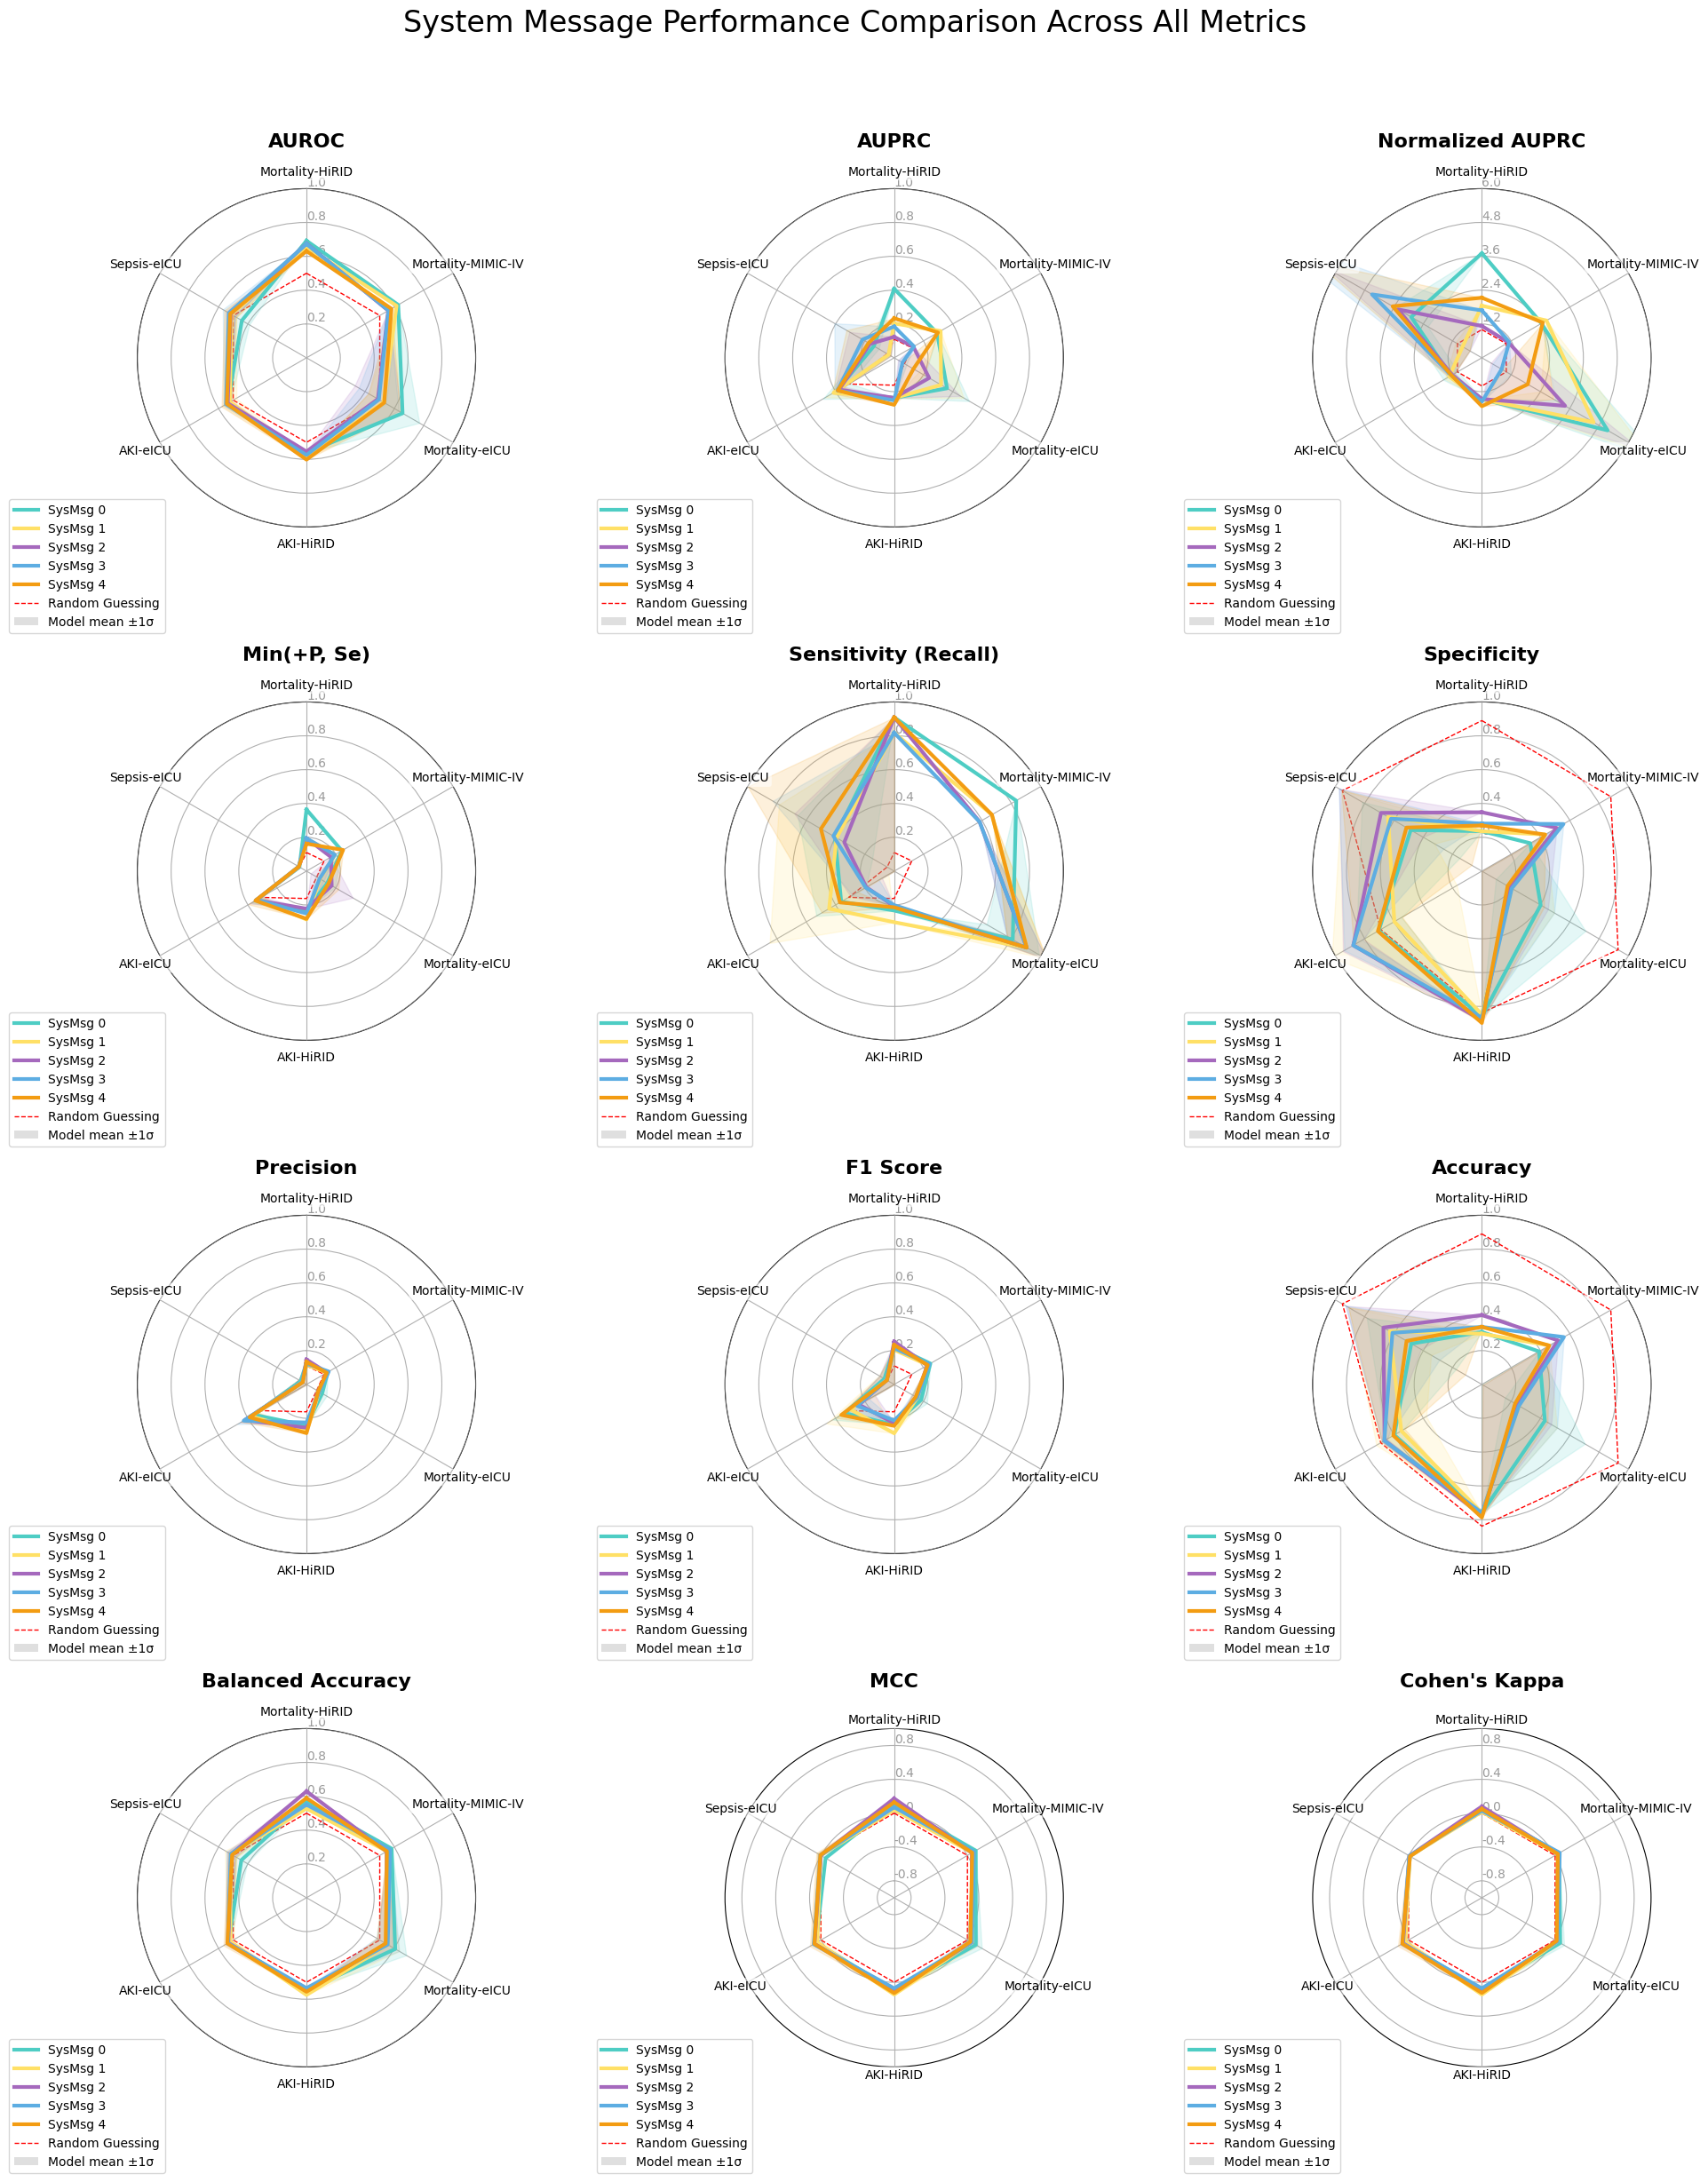

In [79]:
# Create a combined figure with all metric radar charts for easy comparison
fig, axes = plt.subplots(4, 3, figsize=(20, 25), subplot_kw=dict(polar=True))
fig.suptitle("System Message Performance Comparison Across All Metrics", fontsize=24)
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.95)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    if i < len(axes_flat) and metric in df.columns:
        # Create the radar chart on the current subplot
        create_radar_chart_for_metric(
            metric=metric,
            data=df,
            sys_msg_indices=sys_msg_indices,
            ax=axes_flat[i]
        )
    elif i < len(axes_flat):
        axes_flat[i].text(0.5, 0.5, f'No data for {metric}', 
                          ha='center', va='center', transform=axes_flat[i].transAxes)

# Hide any unused subplots
for i in range(len(metrics), len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout but leave room for suptitle
plt.savefig(f"{output_dir}/combined_metrics_radar_chart.png", dpi=300, bbox_inches='tight')
plt.show()

---

# Radar Charts by Task-Dataset Combinations

The following section generates radar charts where each chart represents a specific task-dataset combination, with axes showing different performance metrics compared across system message indices.

In [80]:
def radar_chart_sys_msg(task, dataset, data, sys_msg_indices=None, save_path=None, ax=None, metric_ranges=None):
    """
    Create a radar chart comparing system message performance with custom ranges for each metric.
    Shows mean performance with standard deviation areas across models.
    """
    # Filter data for the specific task and dataset
    filtered_data = data[(data["Task"] == task) & (data["Dataset"] == dataset)]

    # If no system message indices specified, use all in the filtered data
    if sys_msg_indices is None:
        sys_msg_indices = sorted(filtered_data["System_Message_Index"].unique())

    # Select metrics for the radar chart
    metrics = [
        "AUROC",
        "AUPRC",
        "Normalized AUPRC",
        "Min(+P, Se)", 
        "Sensitivity (Recall)",
        "Specificity",
        "Precision",
        "F1 Score",
        "Accuracy",
        "Balanced Accuracy",
        "MCC",
        "Cohen's Kappa",
    ]

    # Default ranges if not specified
    if metric_ranges is None:
        metric_ranges = {metric: (0, 1) for metric in metrics}

    # Define custom ranges for each metric
    max_normalized_auprc = (
        df["Normalized AUPRC"].max() if "Normalized AUPRC" in df.columns else 1.5
    )
    max_normalized_auprc_rounded = math.ceil(max_normalized_auprc)

    metric_ranges = {
        "AUROC": (0, 1),
        "AUPRC": (0, 1),
        "Normalized AUPRC": (0, max_normalized_auprc_rounded),
        "Min(+P, Se)": (0, 1),
        "Sensitivity (Recall)": (0, 1),
        "Specificity": (0, 1),
        "Precision": (0, 1),
        "F1 Score": (0, 1),
        "Accuracy": (0, 1),
        "Balanced Accuracy": (0, 1),
        "MCC": (-1, 1),
        "Cohen's Kappa": (-1, 1),
    }

    # Define the class prevalence for each task-dataset combination
    class_prevalence_task_dataset = {
        "Mortality": {"HiRID": 0.110, "MIMIC-IV": 0.120, "eICU": 0.070},
        "AKI": {"HiRID": 0.162, "MIMIC-IV": 0.233, "eICU": 0.31},
        "Sepsis": {"HiRID": 0.075, "MIMIC-IV": 0.025, "eICU": 0.048},
    }

    # Dynamically calculate baseline values based on class prevalence
    prevalence = class_prevalence_task_dataset.get(task, {}).get(dataset, 0)
    baseline_values = {
        "AUROC": 0.5,
        "AUPRC": prevalence,
        "Normalized AUPRC": 1,
        "Min(+P, Se)": prevalence,
        "Sensitivity (Recall)": prevalence,
        "Specificity": 1 - prevalence,
        "Precision": prevalence,
        "F1 Score": prevalence,
        "Accuracy": max(prevalence, 1 - prevalence),
        "Balanced Accuracy": 0.5,
        "MCC": 0,
        "Cohen's Kappa": 0,
    }

    # Number of metrics (variables)
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the polygon

    # Initialize the plot if no ax provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    else:
        fig = plt.gcf()

    # Set the angle for each metric
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_theta_direction(-1)  # Go clockwise

    # Plot baseline values
    baseline_normalized = []
    for metric in metrics:
        min_val, max_val = metric_ranges.get(metric, (0, 1))
        baseline = baseline_values.get(metric, 0)
        normalized_baseline = (
            (baseline - min_val) / (max_val - min_val) if max_val > min_val else 0
        )
        baseline_normalized.append(min(normalized_baseline, 1.0))
    baseline_normalized += baseline_normalized[:1]  # Close the polygon

    # Plot the baseline line
    ax.plot(
        angles,
        baseline_normalized,
        linewidth=1,
        linestyle="dashed",
        color="red",
        label="Random Guessing",
        zorder=5,
    )

    # Clear existing labels and grid first
    ax.set_xticklabels([])
    ax.grid(False)

    # Plot each system message index with std deviation areas
    for sys_msg_idx in sys_msg_indices:
        sys_msg_data = filtered_data[filtered_data["System_Message_Index"] == sys_msg_idx]

        if not sys_msg_data.empty:
            # Extract and normalize values for each metric
            values = []
            stds = []
            
            for m, metric in enumerate(metrics):
                if metric in sys_msg_data.columns and not pd.isna(sys_msg_data[metric].values[0]):
                    val = sys_msg_data[metric].values[0]
                    std_val = sys_msg_data[f"{metric}_std"].values[0] if f"{metric}_std" in sys_msg_data.columns else 0

                    # Get the range for this metric
                    min_val, max_val = metric_ranges.get(metric, (0, 1))

                    # Normalize the value and std to 0-1 scale
                    normalized_val = (val - min_val) / (max_val - min_val) if max_val > min_val else 0
                    normalized_std = std_val / (max_val - min_val) if max_val > min_val else 0
                    
                    values.append(min(normalized_val, 1.0))
                    stds.append(normalized_std)
                else:
                    values.append(0)
                    stds.append(0)

            # Close the polygon by repeating the first value
            values += values[:1]
            stds += stds[:1]
            
            # Calculate upper and lower bounds for std deviation area
            upper_bounds = [min(1.0, max(0, val + std)) for val, std in zip(values, stds)]
            lower_bounds = [max(0, val - std) for val, std in zip(values, stds)]

            # Get the color for the current system message index
            color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")

            # Fill the standard deviation area first (so it's behind the line)
            if any(std > 0 for std in stds[:-1]):  # Check if we have any non-zero std
                ax.fill_between(
                    angles,
                    lower_bounds,
                    upper_bounds,
                    color=color,
                    alpha=0.15,  # Increased alpha for better visibility
                    zorder=5
                )
            
            # Plot the mean line on top
            ax.plot(
                angles,
                values,
                linewidth=3,  # Make line thicker
                linestyle="solid",
                color=color,
                label=f"SysMsg {sys_msg_idx}",
                zorder=10
            )

    # Set up the axes, grid, and labels
    ax.grid(True, zorder=0)

    # Set up standard y-ticks
    ax.set_rlabel_position(0)
    yticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(yticks)
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10, color="grey", alpha=0.8, zorder=50)
    ax.set_ylim(0, 1)

    # Create labels with metric name and range
    labels = []
    for m, metric in enumerate(metrics):
        min_val, max_val = metric_ranges.get(metric, (0, 1))
        labels.append(f"{metric}\n[{min_val} - {max_val}]")

    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Clear labels first

    # Add labels
    for label, angle in zip(labels, angles[:-1]):
        text = ax.text(
            angle, 
            1.1, 
            label, 
            horizontalalignment='center',
            verticalalignment='center',
            zorder=100
        )
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # Make sure spines are behind everything
    for spine in ax.spines.values():
        spine.set_zorder(-50)

    # Add title 
    ax.set_title(f"{task} - {dataset}", size=16, color="black", weight="bold", y=1.1)
    
    # Add custom legend with std explanation
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create custom legend elements
    legend_elements = []
    
    # Add system message lines
    for sys_msg_idx in sys_msg_indices:
        color = SYSTEM_MESSAGE_COLORS.get(sys_msg_idx, "#000000")
        legend_elements.append(Line2D([0], [0], color=color, linewidth=3, label=f"SysMsg {sys_msg_idx}"))
    
    # Add baseline
    legend_elements.append(Line2D([0], [0], color="red", linewidth=1, linestyle="dashed", label="Random Guessing"))
    
    # Add std explanation with gray fill
    legend_elements.append(Patch(facecolor="gray", alpha=0.25, label="Model mean ±1σ"))
    
    # Create legend
    legend = ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=10)
    legend.set_zorder(100)
    for text in legend.get_texts():
        text.set_zorder(100)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    return fig, ax

In [81]:
# Get unique tasks, datasets, and system message indices
tasks_td = df["Task"].unique()
datasets_td = df["Dataset"].unique()
sys_msg_indices_td = sorted(df["System_Message_Index"].unique())

# Create output directory for task-dataset charts
output_dir_td = os.path.join(OUTPUT_BASE_DIR, 'radar_charts_by_task_dataset')
os.makedirs(output_dir_td, exist_ok=True)

# Generate individual plots for each task-dataset combination
for task in tasks_td:
    for dataset in datasets_td:
        # Check if this combination exists in the data
        if len(df[(df['Task'] == task) & (df['Dataset'] == dataset)]) > 0:
            print(f"Creating plot for {task}-{dataset}")
            fig, ax = radar_chart_sys_msg(
                task=task,
                dataset=dataset,
                data=df,
                save_path=f"{output_dir_td}/{task}_{dataset}_radar_chart.png"
            )
            plt.close(fig)  # Close the figure to free memory
        else:
            print(f"No data found for {task}-{dataset}")

Creating plot for Mortality-MIMIC-IV
Creating plot for Mortality-HiRID
Creating plot for Mortality-HiRID
Creating plot for Mortality-eICU
Creating plot for Mortality-eICU
No data found for AKI-MIMIC-IV
Creating plot for AKI-HiRID
No data found for AKI-MIMIC-IV
Creating plot for AKI-HiRID
Creating plot for AKI-eICU
Creating plot for AKI-eICU
No data found for Sepsis-MIMIC-IV
No data found for Sepsis-HiRID
Creating plot for Sepsis-eICU
No data found for Sepsis-MIMIC-IV
No data found for Sepsis-HiRID
Creating plot for Sepsis-eICU


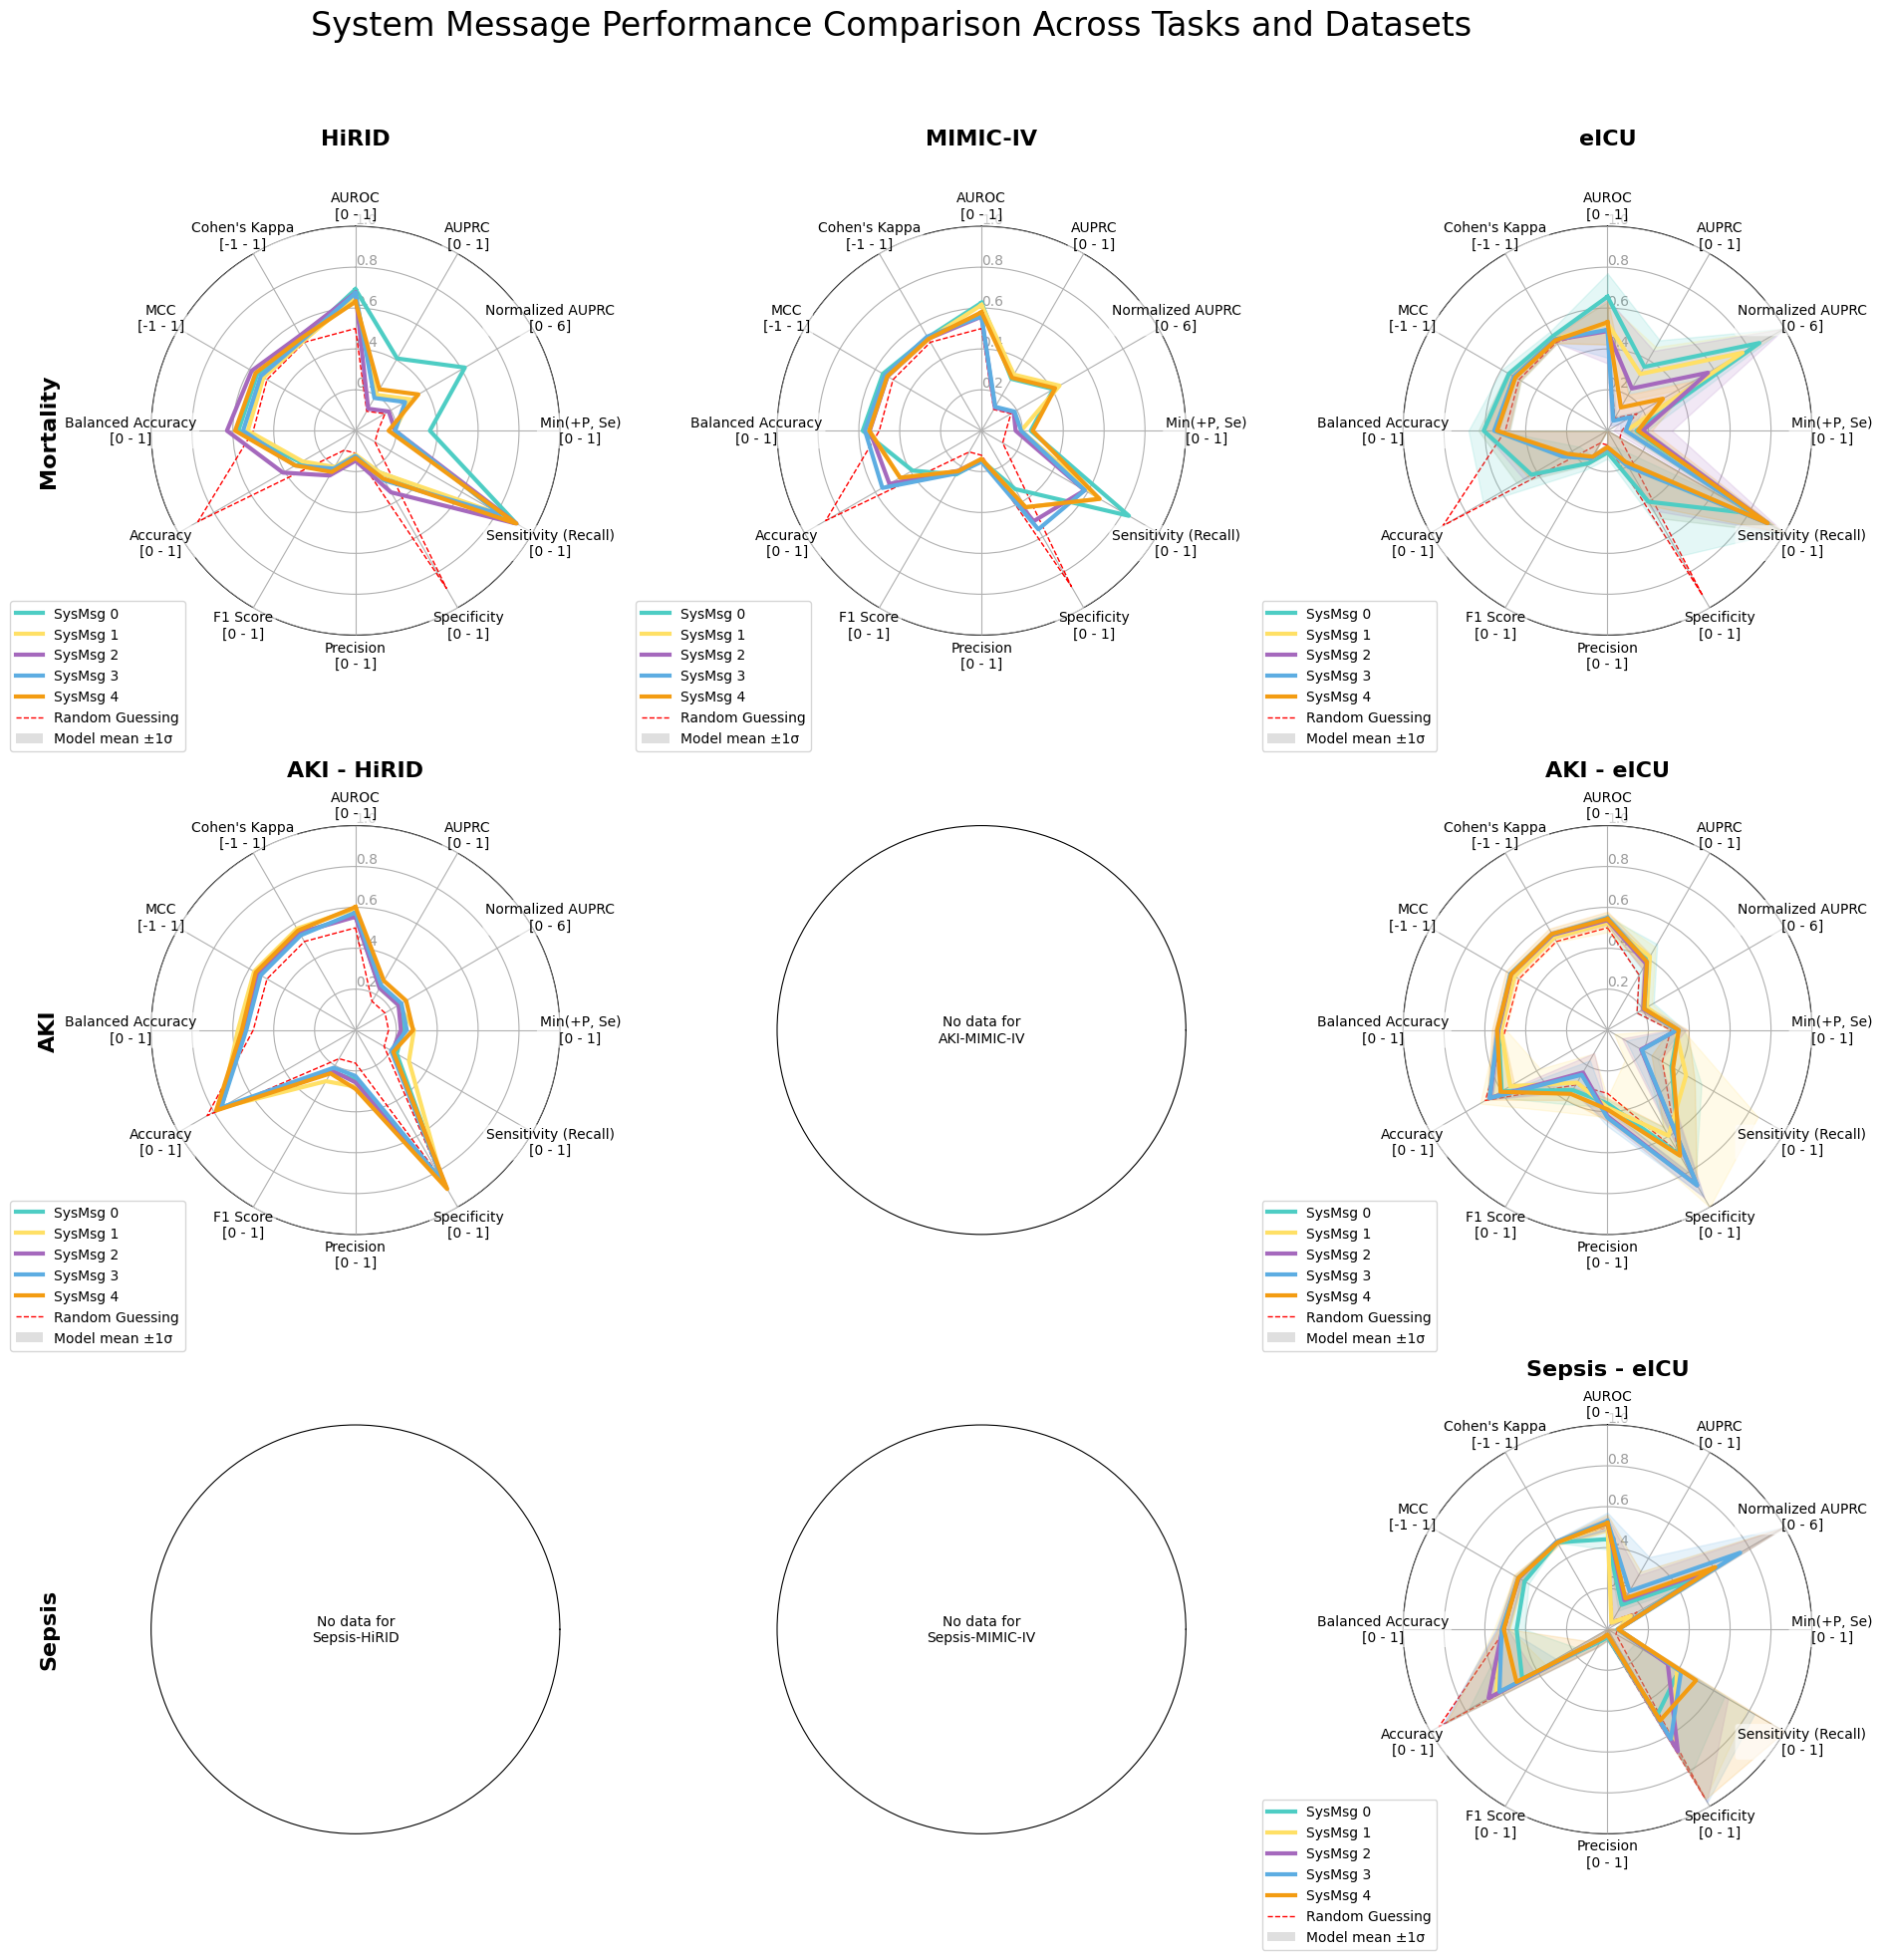

In [82]:
# Create a combined figure with all task-dataset plots for easy comparison
fig, axes = plt.subplots(len(task_order), len(dataset_order), figsize=(20, 20), subplot_kw=dict(polar=True))
fig.suptitle("System Message Performance Comparison Across Tasks and Datasets", fontsize=24)
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.95)

# Loop over tasks (rows) and datasets (columns) in the desired order
for i, task in enumerate(task_order):
    for j, dataset in enumerate(dataset_order):
        ax = axes[i, j]
        # Check if this combination exists in the data
        if len(df[(df['Task'] == task) & (df['Dataset'] == dataset)]) > 0:
            radar_chart_sys_msg(
                task=task,
                dataset=dataset,
                data=df,
                ax=ax
            )
        else:
            ax.text(0.5, 0.5, f'No data for\n{task}-{dataset}', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])

# Add column labels for datasets at the top
for j, dataset in enumerate(dataset_order):
    axes[0, j].set_title(dataset, fontsize=16, weight='bold', y=1.18)

# Add row labels for tasks on the left
for i, task in enumerate(task_order):
    axes[i, 0].text(-0.25, 0.5, task, ha='center', va='center', 
                    transform=axes[i, 0].transAxes, fontsize=16, weight='bold', rotation=90)

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.savefig(f"{output_dir_td}/combined_radar_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Comprehensive Analysis of System Message Performance

This enhanced notebook now provides a complete evaluation framework for system message variations across multiple dimensions:

### Radar Chart Visualizations
The radar charts above provide comprehensive visual comparisons of different system message variations' performance from two perspectives:

**Radar Charts by Metrics**: These charts show how all system message indices perform across different task-dataset combinations for each specific metric, making it easy to identify which system message variations excel in specific areas.

**Radar Charts by Task-Dataset Combinations**: These charts show how system message variations perform across all metrics for specific task-dataset pairs, revealing balanced performance patterns.

### Statistical Analysis Components

**Operational Metrics**: Analysis of tokenization time, inference time, and token usage provides insights into computational efficiency and deployment considerations.

**Aggregated Performance**: Cross-model, cross-task analysis reveals overall system message effectiveness patterns with confidence intervals.

**Model-Specific Analysis**: Detailed breakdowns for individual models help identify model-specific strengths and optimal system message choices.

**Distribution Analysis**: Prediction probability distributions reveal model calibration quality and help identify potential prediction bias patterns.

### Key Insights for System Message Selection

1. **Performance vs. Complexity Trade-off**: More detailed system messages (with examples, calibration guidelines) may improve performance but increase computational cost.

2. **Task-Specific Optimization**: Different system messages may excel for different clinical prediction tasks (mortality, AKI, sepsis).

3. **Dataset Sensitivity**: System message effectiveness can vary significantly across different datasets, highlighting the importance of validation across multiple data sources.

4. **Calibration Quality**: The distribution analysis helps identify whether models are well-calibrated or show systematic over/under-confidence patterns.

5. **Consistency vs. Specialization**: Some system messages provide consistent performance across all metrics, while others may excel in specific areas - the choice depends on clinical application requirements.

### Recommendations for Clinical Deployment

- **Use radar charts** to identify system messages with balanced performance across multiple metrics
- **Consider operational constraints** when choosing between simple and complex system messages
- **Validate on multiple datasets** to ensure robust performance across different clinical settings
- **Monitor prediction distributions** in production to detect calibration drift
- **Consider task-specific optimization** for specialized clinical applications

This comprehensive analysis framework enables data-driven system message selection for clinical LLM applications, balancing performance, efficiency, and reliability considerations.

---

# System Message Documentation

Documentation of the different system message variations tested in this analysis for reproducibility and understanding.

In [83]:
# System Message Variations Documentation
# The following are the different system message variations that were tested

print("System Message Variations Used in This Analysis:")
print("="*60)

system_messages = {
    1: """
System Message 1 (Basic):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.
""",
    
    2: """
System Message 2 (With Examples):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Here is a positive example:
{
  "diagnosis": "aki",
  "probability": "89",
  "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
}

Here is a negative example:
{
  "diagnosis": "not-aki",
  "probability": "8",
  "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
}

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.
""",
    
    3: """
System Message 3 (With Calibration Guidelines):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Here is a positive example:
{
  "diagnosis": "aki",
  "probability": "89",
  "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
}

Here is a negative example:
{
  "diagnosis": "not-aki",
  "probability": "8",
  "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
}

CRITICAL: Probability calibration guidelines:
- 0-20: Very unlikely, clear absence of condition with normal parameters
- 20-40: Unlikely, some concerning signs but insufficient evidence
- 40-60: Uncertain, mixed evidence or borderline findings
- 60-80: Likely, multiple indicators support diagnosis
- 80-100: Very likely, strong evidence with clear clinical criteria met

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.
""",
    
    4: """
System Message 4 (With ICU Context):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Here is a positive example:
{
  "diagnosis": "aki",
  "probability": "89",
  "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
}

Here is a negative example:
{
  "diagnosis": "not-aki",
  "probability": "8",
  "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
}

CRITICAL: Probability calibration guidelines:
- 0-20: Very unlikely, clear absence of condition with normal parameters
- 20-40: Unlikely, some concerning signs but insufficient evidence
- 40-60: Uncertain, mixed evidence or borderline findings
- 60-80: Likely, multiple indicators support diagnosis
- 80-100: Very likely, strong evidence with clear clinical criteria met

Note: ICU patients often present with abnormal baseline values due to their critical condition. Consider the clinical context and severity of deviations when assessing for the target condition.

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.
""",
    
    5: """
System Message 5 (With JSON Schema):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Here is a positive example:
{
  "diagnosis": "aki",
  "probability": "89",
  "explanation": "Acute kidney injury evident: serum creatinine increased from baseline 1.1 to 2.7 mg/dL within 24 hours (>2x increase), urine output decreased to 0.3 mL/kg/h over 6 hours, meeting KDIGO Stage 2 criteria."
}

Here is a negative example:
{
  "diagnosis": "not-aki",
  "probability": "8",
  "explanation": "Kidney function stable: creatinine 1.3 mg/dL (minimal change from baseline 1.2), adequate urine output at 1.1 mL/kg/h, no signs of acute kidney injury."
}

CRITICAL: Probability calibration guidelines:
- 0-20: Very unlikely, clear absence of condition with normal parameters
- 20-40: Unlikely, some concerning signs but insufficient evidence
- 40-60: Uncertain, mixed evidence or borderline findings
- 60-80: Likely, multiple indicators support diagnosis
- 80-100: Very likely, strong evidence with clear clinical criteria met

--- JSON Schema ---
{
  "diagnosis": "string"  // Must be either "aki" or "not-aki"
  "probability": "integer" // Value between 0 (no diagnosis) and 100 (definite diagnosis)
  "explanation": "string" // Concise clinical reasoning for the diagnosis and probability
}

Note: ICU patients often present with abnormal baseline values due to their critical condition. Consider the clinical context and severity of deviations when assessing for the target condition.

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.
"""
}

for idx, msg in system_messages.items():
    print(f"\n{'-'*40}")
    print(f"SYSTEM MESSAGE {idx}:")
    print(f"{'-'*40}")
    print(msg.strip())
    print(f"\nCharacter count: {len(msg)}")
    print(f"Word count: {len(msg.split())}")

System Message Variations Used in This Analysis:

----------------------------------------
SYSTEM MESSAGE 1:
----------------------------------------
System Message 1 (Basic):
You are a helpful assistant and experienced medical professional analyzing ICU time-series data for detecting acute kidney injury (AKI) ≥ stage 1 according to KDIGO 2012 criteria.

Your response must strictly follow this format:
Output a valid JSON object with three keys: 'diagnosis', 'probability' and 'explanation'.

1. 'diagnosis' a string with either 'diagnosis' or 'not-diagnosis'
2. 'probability' an integer between 0 and 100, where 0 means not diagnosed and 100 means diagnosed.
3. 'explanation' should be a string providing a brief explanation of your diagnosis.

Do not include any other text or explanations outside of the JSON object.
Think about the probability of your prediction carefully before answering.

Character count: 749
Word count: 112

----------------------------------------
SYSTEM MESSAGE 2:
----